In [ ]:
#Data analysis for change in ext work

In [79]:
#All functions needed 
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()


from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo


import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors 

import matplotlib.animation as animation
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#pick={inhomo_v2,inhomov1,inhomov2,random} pick one of these to properly store images with the correct labels
dataset_label = "inhomo_v2"
num=12

In [2]:
newdata1_th = dict(h5py.File("../data/unnati_submit_12_therm_random/unnati_submit_12_therm_random.hdf5"))
newdata2_th = dict(h5py.File("../data/unnati_submit_12_therm_greedy/unnati_submit_12_therm_greedy.hdf5"))
newdata3_th = dict(h5py.File("../data/unnati_submit_12_therm_mimic/unnati_submit_12_therm_mimic.hdf5"))
newdata4_th = dict(h5py.File("../data/unnati_submit_12_therm_landmax/unnati_submit_12_therm_landmax.hdf5"))
newdata5_th = dict(h5py.File("../data/unnati_submit_12_therm_strong_max/unnati_submit_12_therm_strong_max.hdf5"))

newdata1_pure = dict(h5py.File("../data/unnati_submit_12_pure_random/unnati_submit_12_pure_random.hdf5"))
newdata2_pure = dict(h5py.File("../data/unnati_submit_12_pure_greedy/unnati_submit_12_pure_greedy.hdf5"))
newdata3_pure = dict(h5py.File("../data/unnati_submit_12_pure_mimic/unnati_submit_12_pure_mimic.hdf5"))
newdata4_pure = dict(h5py.File("../data/unnati_submit_12_pure_landmax/unnati_submit_12_pure_landmax.hdf5"))
newdata5_pure = dict(h5py.File("../data/unnati_submit_12_pure_strongmax/unnati_submit_12_pure_strongmax.hdf5"))

newdata1_v1 = dict(h5py.File("../data/unnati_submit_12_inhomo_v1_random/unnati_submit_12_inhomo_v1_random.hdf5"))
newdata2_v1 = dict(h5py.File("../data/unnati_submit_12_inhomo_v1_greedy/unnati_submit_12_inhomo_v1_greedy.hdf5"))
newdata3_v1 = dict(h5py.File("../data/unnati_submit_12_inhomo_v1_mimic/unnati_submit_12_inhomo_v1_mimic.hdf5"))
newdata4_v1 = dict(h5py.File("../data/unnati_submit_12_inhomo_v1_landmax/unnati_submit_12_inhomo_v1_landmax.hdf5"))
newdata5_v1 = dict(h5py.File("../data/unnati_submit_12_inhomo_v1_strong_max/unnati_submit_12_inhomo_v1_strong_max.hdf5"))

newdata1_v2 = dict(h5py.File("../data/unnati_submit_12_inhomo_v2_random/unnati_submit_12_inhomo_v2_random.hdf5"))
newdata2_v2 = dict(h5py.File("../data/unnati_submit_12_inhomo_v2_greedy/unnati_submit_12_inhomo_v2_greedy.hdf5"))
newdata3_v2 = dict(h5py.File("../data/unnati_submit_12_inhomo_v2_mimic/unnati_submit_12_inhomo_v2_mimic.hdf5"))
newdata4_v2 = dict(h5py.File("../data/unnati_submit_12_inhomo_v2_landmax/unnati_submit_12_inhomo_v2_landmax.hdf5"))
newdata5_v2 = dict(h5py.File("../data/unnati_submit_12_inhomo_v2_strongmax/unnati_submit_12_inhomo_v2_strongmax.hdf5"))

In [3]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [4]:
def ensemble_averaged_one_point_measures_mean_std(datasets):
    # Assuming datasets is a list of 100 datasets, where each dataset is a 2D array of shape (100, N)
    # Stack datasets into a 3D array
    stacked_data = np.stack(datasets)  # Shape (100, 100, N)

    # Take the ensemble average along the first axis (averaging over all datasets)
    ensemble_average = np.mean(stacked_data, axis=0)  # Shape (100, N)

    # Calculate the standard deviation along the first axis
    ensemble_std = np.std(stacked_data, axis=0) 
    return (ensemble_average, ensemble_std)

In [5]:
def extractable_work_of_one_trial(pops,trial):
    return np.array([measure.extractable_work_of_each_qubit_from_pops(p) for p in pops[trial]])

def extractable_work_of_all_trials(pops):
    ext_work_all = []
    for trial in range(len(pops)):
        ext_work_all.append(extractable_work_of_one_trial(pops,trial))
    return ext_work_all

def change_in_ext_work(ext_work_one_trial):
    return np.diff(ext_work_one_trial,axis = 0)

def change_in_ext_work_all_trials(ext_work_all_trial):
    change_in_ext_all =[]
    for trial in range(len(ext_work_all_trial)):
        change_in_ext_all.append(np.diff(ext_work_all_trial[trial],axis = 0))
    return change_in_ext_all

In [6]:
#Histogram functions
#where list of lists is change in ext work for one trial
#index is qubit index
#Gives a list where first element is the total number of positive steps and the second is a list of when/length of the positive change
def count_positive_steps(list_of_lists, index):
    total_positive_steps = 0
    consecutive_positive_steps = 0
    consecutive_lengths = []  # List to store lengths of consecutive positive sequences
    for lst in list_of_lists:
        if lst[index] > 0:
            total_positive_steps += 1
            consecutive_positive_steps += 1
        else:
            consecutive_lengths.append(consecutive_positive_steps)  # Record length of consecutive positive sequence
            consecutive_positive_steps = 0  # Reset consecutive count if value becomes non-positive
            
    # Add the last consecutive count if the list ends with a positive value
    if consecutive_positive_steps > 0:
        consecutive_lengths.append(consecutive_positive_steps)
        
    return total_positive_steps, consecutive_lengths

#returns a dictionary of step length with positive change in extractable work and how many times it occurs
def tally_elements(lst):
    tally = {}
    for element in lst:
        tally[element] = tally.get(element, 0) + 1
    return tally

#Get the total number of positive steps per qubit on the network as a list
def Num_steps_positive(change_in_ex_work):
    Num_steps_positive=[]
    for qubit_index in range(8):
        Num_steps_positive.append(count_positive_steps(change_in_ex_work,qubit_index)[0])
    return Num_steps_positive

#Get the list of when positive changes occur per qubit on the network as a list
def list_of_consecutive_positive_steps(change_in_ex_work,num):
    sum=[0]
    for qubit_id in range(num):
        sum = sum+count_positive_steps(change_in_ex_work,qubit_id)[1]
    return sum


#Gives the average length of interaval for which the qubit has positive change; does for each qubit and returns a list
def average_time_step_Q_positive(num_qubits,changein_Wex):
    average_time_positive = []
    for qubit_index in range(num_qubits):
        average_time_positive.append(np.mean(count_positive_steps(changein_Wex, qubit_index)[1]))
    return average_time_positive
    
#takes in a dictionary
def avg_time_step_positive(tally):
    num=0
    denom=0
    for key,values in tally.items():
        num = values*key+num
        denom=values+denom
    return num/denom

#get average of the cumulative positive change in extractable work since this is the value you can extract at any point from the landscape as resource
def replace_negatives_with_zero(lst):
    for sublist in lst:
        for i in range(len(sublist)):
            if sublist[i] < 0:
                sublist[i] = 0
    return lst

def average_ex_resource_landscape(change_in_ex_work):
    means=[]
    for qubit in range(8):
        means.append(np.mean(replace_consecutive_positives_with_cumulative_sum(replace_negatives_with_zero(change_in_ex_work))[qubit]))
    return np.mean(means)

def average_cumulative_Wex(num_qubits,changein_Wex):
    average_time_positive = []
    for qubit_index in range(num_qubits):
        average_time_positive.append(np.mean(count_positive_steps(changein_Wex, qubit_index)[1]))
    return average_time_positive
    
def total_wex(num_qubits,changein_Wex):
    total_wex = []
    for qubit_index in range(num_qubits):
        changein_Wex[0:99,qubit_index]
        total_wex.append(sum(changein_Wex[0:99,qubit_index]))
    return total_wex

def replace_consecutive_positives_with_cumulative_sum(list_of_lists):
    lst = [list(column) for column in zip(*list_of_lists)]
    for sublist in lst:
        cumulative_sum = 0
        consecutive_positive_count = 0
        for i in range(len(sublist)):
            if sublist[i] > 0:
                cumulative_sum += sublist[i]
                consecutive_positive_count += 1
                if i == len(sublist) - 1 or sublist[i + 1] == 0:
                    if consecutive_positive_count > 1:
                        for j in range(i - consecutive_positive_count + 1, i + 1):
                            sublist[j] = 0
                        sublist[i] = cumulative_sum
                    cumulative_sum = 0
                    consecutive_positive_count = 0
            else:
                cumulative_sum = 0
                consecutive_positive_count = 0
    return lst

def list_of_consec_positive_steps_no_zeros(change_in):
    listt=[]
    for ele in list_of_consecutive_positive_steps(change_in):
        if ele != 0:
            listt.append(ele)
    return listt

def consecutive_positives_with_cumulative_sum_no_zeores(change_in):
    list2=[]
    for ele in np.array(replace_consecutive_positives_with_cumulative_sum(replace_negatives_with_zero(change_in))).flatten():
        if ele!=0:
            list2.append(ele)
    return list2


def plot_histogram(ax, tally_data, label, total_points=8000, color=None):
    """
    Plot histogram showing the distribution of interval lengths
    
    Parameters:
    ax -- matplotlib axis to plot on
    tally_data -- dictionary where keys are interval lengths and values are their frequencies
    label -- label for the legend
    total_points -- total number of data points (default: 8000)
    color -- optional color specification
    """
    # Extract interval lengths and their frequencies
    interval_lengths = list(tally_data.keys())
    frequencies = list(tally_data.values())
    
    # Convert to numpy arrays for easier manipulation
    interval_lengths = np.array(interval_lengths)
    frequencies = np.array(frequencies)
    
    # Sort by interval length for consistent display
    sort_idx = np.argsort(interval_lengths)
    interval_lengths = interval_lengths[sort_idx]
    frequencies = frequencies[sort_idx]
    
    # Calculate total occurrences of all intervals
    total_intervals = np.sum(frequencies)
    
    # Calculate percentage of each interval length relative to total intervals
    percentage = (frequencies / total_intervals) * 100
    
    # Plot as a bar chart
    if color:
        ax.bar(interval_lengths, percentage, alpha=0.6, label=label, color=color)
    else:
        ax.bar(interval_lengths, percentage, alpha=0.6, label=label)
    
    # Set appropriate labels
    ax.set_xlabel('Interval Length',fontsize=16)
    ax.set_ylabel('Percentage of Total Intervals (%)',fontsize=16)
    #ax.set_title(f'Interval Distribution for {label}',fontsize=20)
    ax.legend()

    # Add text showing total number of intervals
    #ax.text(0.95, 0.95, f'Total intervals: {total_intervals}', 
     #       transform=ax.transAxes, ha='right', va='top',
      #      bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    return ax, interval_lengths, percentage


def create_grouped_bar_chart_with_zoom(title,tally_dict_list, labels, colors=None, zoom_threshold=10):
    """
    Create a grouped bar chart for multiple tally dictionaries with zoomed inset
    
    Parameters:
    tally_dict_list -- list of tally dictionaries
    labels -- list of labels for each dictionary
    colors -- list of colors for each dictionary (optional)
    zoom_threshold -- value to start zooming from (default: 10)
    """
    if colors is None:
        # Brighter colors that are still colorblind-friendly
        colors = ['#1F78B4', '#FF7F00', '#9467BD', '#4DAF4A', '#E41A1C']
    
    # Get all unique interval lengths across all dictionaries
    all_intervals = set()
    for tally in tally_dict_list:
        all_intervals.update(tally.keys())
    
    all_intervals = sorted(list(all_intervals))
    
    # Width of a bar
    bar_width = 0.15
    
    # Position on x-axis
    positions = np.arange(len(all_intervals))
    
    # Create a new figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Store data for the inset plot
    inset_data = []
    
    # Loop through all tally dictionaries
    for i, (tally, label, color) in enumerate(zip(tally_dict_list, labels, colors)):
        # Calculate percentages
        total_intervals = sum(tally.values())
        percentages = []
        
        # For each interval length, find its percentage or set to 0 if not present
        for interval in all_intervals:
            if interval in tally:
                percentages.append((tally[interval] / total_intervals) * 100)
            else:
                percentages.append(0)
        
        # Store the data for inset plot
        inset_data.append((percentages, label, color))
        
        # Set the position for this set of bars
        bar_positions = positions + (i - len(tally_dict_list)/2 + 0.5) * bar_width
        
        # Create the bars
        ax.bar(bar_positions, percentages, bar_width, alpha=0.7, label=label, color=color)
    
    # Set labels and title
    ax.set_xlabel('Interval Length',fontsize=16)
    ax.set_ylabel('Percentage of Total Intervals (%)',fontsize=16)
    ax.set_title('Comparison of Interval Length Distributions',fontsize=20)
    
    # Set the x-axis ticks to the interval lengths
    ax.set_xticks(positions)
    ax.set_xticklabels(all_intervals)
    
    # Add a legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create a zoomed inset axes in the top right
    axins = inset_axes(ax, width="40%", height="40%", loc=1, borderpad=2)
    
    # Filter intervals for zoom (interval_length >= zoom_threshold)
    zoom_indices = [i for i, interval in enumerate(all_intervals) if interval >= zoom_threshold]
    
    if zoom_indices:  # Only proceed if there are intervals to zoom in on
        zoom_positions = np.array([positions[i] for i in zoom_indices])
        zoom_intervals = [all_intervals[i] for i in zoom_indices]
        
        # Plot the zoomed data for each tally dictionary
        for i, (percentages, label, color) in enumerate(inset_data):
            zoom_percentages = [percentages[i] for i in zoom_indices]
            bar_positions = zoom_positions + (i - len(tally_dict_list)/2 + 0.5) * bar_width
            axins.bar(bar_positions, zoom_percentages, bar_width, alpha=0.7, color=color)
        
        # Set labels for the inset axes
        axins.set_title(f'Zoomed view (interval ≥ {zoom_threshold})')
        axins.set_xticks(zoom_positions)
        axins.set_xticklabels(zoom_intervals, rotation=45)
        
        # Adjust the y-axis to show the data better
        if zoom_indices:
            max_zoom_val = max(max(percentages[i] for i in zoom_indices) for percentages, _, _ in inset_data)
            # Add a little headroom
            axins.set_ylim(0, max_zoom_val * 1.1)
    else:
        axins.text(0.5, 0.5, "No intervals ≥ 10", 
                  ha='center', va='center', transform=axins.transAxes)
    
    plt.tight_layout()
    plt.savefig(f'grouped_interval_comparison_with_zoom_{title}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [7]:
num=12
#pops_random_c2_th = get_pops(newdata1_th, num, "c2_2local", "random")
pops_greedy_c2_th = get_pops(newdata2_th, num, "c2_2local", "greedy")
#pops_mimic_c2_th = get_pops(newdata3_th, num, "c2_2local", "mimic")
#pops_landmax_c2_th = get_pops(newdata4_th, num, "c2_2local", "landscape_maximizes")
#pops_strongmax_c2_th = get_pops(newdata5_th, num, "c2_2local", "strongest_maximizes")

num=12
#pops_random_c2_v1 = get_pops(newdata1_v1, num, "c2_2local", "random")
pops_greedy_c2_v1 = get_pops(newdata2_v1, num, "c2_2local", "greedy")
#pops_mimic_c2_v1 = get_pops(newdata3_v1, num, "c2_2local", "mimic")
#pops_landmax_c2_v1 = get_pops(newdata4_v1, num, "c2_2local", "landscape_maximizes")
#pops_strongmax_c2_v1 = get_pops(newdata5_v1, num, "c2_2local", "strongest_maximizes")


num=12
#pops_random_c2_v2 = get_pops(newdata1_v2, num, "c2_2local", "random")
pops_greedy_c2_v2 = get_pops(newdata2_v2, num, "c2_2local", "greedy")
#pops_mimic_c2_v2 = get_pops(newdata3_v2, num, "c2_2local", "mimic")
#pops_landmax_c2_v2 = get_pops(newdata4_v2, num, "c2_2local", "landscape_maximizes")
#pops_strongmax_c2_v2 = get_pops(newdata5_v2, num, "c2_2local", "strongest_maximizes")

num=12
#pops_random_c2_pure = get_pops(newdata1_pure, num, "c2_2local", "random")
pops_greedy_c2_pure = get_pops(newdata2_pure, num, "c2_2local", "greedy")
#pops_mimic_c2_pure = get_pops(newdata3_pure, num, "c2_2local", "mimic")
#pops_landmax_c2_pure = get_pops(newdata4_pure, num, "c2_2local", "landscape_maximizes")
#pops_strongmax_c2_pure = get_pops(newdata5_pure, num, "c2_2local", "strongest_maximizes")

In [8]:
num=12
pops_random_c4_th = get_pops(newdata1_th, num, "c4_2local", "random")
pops_greedy_c4_th = get_pops(newdata2_th, num, "c4_2local", "greedy")
pops_mimic_c4_th = get_pops(newdata3_th, num, "c4_2local", "mimic")
pops_landmax_c4_th = get_pops(newdata4_th, num, "c4_2local", "landscape_maximizes")
pops_strongmax_c4_th = get_pops(newdata5_th, num, "c4_2local", "strongest_maximizes")

num=12
pops_random_c4_v1 = get_pops(newdata1_v1, num, "c4_2local", "random")
pops_greedy_c4_v1 = get_pops(newdata2_v1, num, "c4_2local", "greedy")
pops_mimic_c4_v1 = get_pops(newdata3_v1, num, "c4_2local", "mimic")
pops_landmax_c4_v1 = get_pops(newdata4_v1, num, "c4_2local", "landscape_maximizes")
pops_strongmax_c4_v1 = get_pops(newdata5_v1, num, "c4_2local", "strongest_maximizes")


num=12
pops_random_c4_v2 = get_pops(newdata1_v2, num, "c4_2local", "random")
pops_greedy_c4_v2 = get_pops(newdata2_v2, num, "c4_2local", "greedy")
pops_mimic_c4_v2 = get_pops(newdata3_v2, num, "c4_2local", "mimic")
pops_landmax_c4_v2 = get_pops(newdata4_v2, num, "c4_2local", "landscape_maximizes")
pops_strongmax_c4_v2 = get_pops(newdata5_v2, num, "c4_2local", "strongest_maximizes")

num=12
pops_random_c4_pure = get_pops(newdata1_pure, num, "c4_2local", "random")
pops_greedy_c4_pure = get_pops(newdata2_pure, num, "c4_2local", "greedy")
pops_mimic_c4_pure = get_pops(newdata3_pure, num, "c4_2local", "mimic")
pops_landmax_c4_pure = get_pops(newdata4_pure, num, "c4_2local", "landscape_maximizes")
pops_strongmax_c4_pure = get_pops(newdata5_pure, num, "c4_2local", "strongest_maximizes")

In [80]:
num=12
pops_random_c2_th = get_pops(newdata1_th, num, "c2_2local", "random")
pops_greedy_c2_th = get_pops(newdata2_th, num, "c2_2local", "greedy")
pops_mimic_c2_th = get_pops(newdata3_th, num, "c2_2local", "mimic")
pops_landmax_c2_th = get_pops(newdata4_th, num, "c2_2local", "landscape_maximizes")
pops_strongmax_c2_th = get_pops(newdata5_th, num, "c2_2local", "strongest_maximizes")

num=12
pops_random_c2_v1 = get_pops(newdata1_v1, num, "c2_2local", "random")
pops_greedy_c2_v1 = get_pops(newdata2_v1, num, "c2_2local", "greedy")
pops_mimic_c2_v1 = get_pops(newdata3_v1, num, "c2_2local", "mimic")
pops_landmax_c2_v1 = get_pops(newdata4_v1, num, "c2_2local", "landscape_maximizes")
pops_strongmax_c2_v1 = get_pops(newdata5_v1, num, "c2_2local", "strongest_maximizes")


num=12
pops_random_c2_v2 = get_pops(newdata1_v2, num, "c2_2local", "random")
pops_greedy_c2_v2 = get_pops(newdata2_v2, num, "c2_2local", "greedy")
pops_mimic_c2_v2 = get_pops(newdata3_v2, num, "c2_2local", "mimic")
pops_landmax_c2_v2 = get_pops(newdata4_v2, num, "c2_2local", "landscape_maximizes")
pops_strongmax_c2_v2 = get_pops(newdata5_v2, num, "c2_2local", "strongest_maximizes")

num=12
pops_random_c2_pure = get_pops(newdata1_pure, num, "c2_2local", "random")
pops_greedy_c2_pure = get_pops(newdata2_pure, num, "c2_2local", "greedy")
pops_mimic_c2_pure = get_pops(newdata3_pure, num, "c2_2local", "mimic")
pops_landmax_c2_pure = get_pops(newdata4_pure, num, "c2_2local", "landscape_maximizes")
pops_strongmax_c2_pure = get_pops(newdata5_pure, num, "c2_2local", "strongest_maximizes")

In [81]:
ext_work_all_random_c2_th = extractable_work_of_all_trials(pops_random_c2_th)
#ext_work_all_random_c4_th = extractable_work_of_all_trials(pops_random_c4_th)
ext_work_all_greedy_c2_th = extractable_work_of_all_trials(pops_greedy_c2_th)
#ext_work_all_greedy_c4_th = extractable_work_of_all_trials(pops_greedy_c4_th)
ext_work_all_mimic_c2_th = extractable_work_of_all_trials(pops_mimic_c2_th)
#ext_work_all_mimic_c4_th = extractable_work_of_all_trials(pops_mimic_c4_th)
ext_work_all_landscape_maximizes_c2_th = extractable_work_of_all_trials(pops_landmax_c2_th)
#ext_work_all_landscape_maximizes_c4_th = extractable_work_of_all_trials(pops_landmax_c4_th)
ext_work_all_strongest_maximizes_c2_th = extractable_work_of_all_trials(pops_strongmax_c2_th)
#ext_work_all_strongest_maximizes_c4_th = extractable_work_of_all_trials(pops_strongmax_c4_th)

ext_work_all_random_c2_v1 = extractable_work_of_all_trials(pops_random_c2_v1)
#ext_work_all_random_c4_v1 = extractable_work_of_all_trials(pops_random_c4_v1)
ext_work_all_greedy_c2_v1 = extractable_work_of_all_trials(pops_greedy_c2_v1)
#ext_work_all_greedy_c4_v1 = extractable_work_of_all_trials(pops_greedy_c4_v1)
ext_work_all_mimic_c2_v1 = extractable_work_of_all_trials(pops_mimic_c2_v1)
#ext_work_all_mimic_c4_v1 = extractable_work_of_all_trials(pops_mimic_c4_v1)
ext_work_all_landscape_maximizes_c2_v1 = extractable_work_of_all_trials(pops_landmax_c2_v1)
#ext_work_all_landscape_maximizes_c4_v1 = extractable_work_of_all_trials(pops_landmax_c4_v1)
ext_work_all_strongest_maximizes_c2_v1 = extractable_work_of_all_trials(pops_strongmax_c2_v1)
ext_work_all_strongest_maximizes_c4_v1 = extractable_work_of_all_trials(pops_strongmax_c4_v1)

ext_work_all_random_c2_v2 = extractable_work_of_all_trials(pops_random_c2_v2)
#ext_work_all_random_c4_v2 = extractable_work_of_all_trials(pops_random_c4_v2)
ext_work_all_greedy_c2_v2 = extractable_work_of_all_trials(pops_greedy_c2_v2)
#ext_work_all_greedy_c4_v2 = extractable_work_of_all_trials(pops_greedy_c4_v2)
ext_work_all_mimic_c2_v2 = extractable_work_of_all_trials(pops_mimic_c2_v2)
#ext_work_all_mimic_c4_v2 = extractable_work_of_all_trials(pops_mimic_c4_v2)
ext_work_all_landscape_maximizes_c2_v2 = extractable_work_of_all_trials(pops_landmax_c2_v2)
#ext_work_all_landscape_maximizes_c4_v2 = extractable_work_of_all_trials(pops_landmax_c4_v2)
ext_work_all_strongest_maximizes_c2_v2 = extractable_work_of_all_trials(pops_strongmax_c2_v2)
ext_work_all_strongest_maximizes_c4_v2 = extractable_work_of_all_trials(pops_strongmax_c4_v2)

In [458]:
ext_work_all_random_c2_pure = extractable_work_of_all_trials(pops_random_c2_pure)
ext_work_all_greedy_c2_pure = extractable_work_of_all_trials(pops_greedy_c2_pure)
ext_work_all_landscape_maximizes_c2_pure = extractable_work_of_all_trials(pops_landmax_c2_pure)
ext_work_all_strongest_maximizes_c2_pure = extractable_work_of_all_trials(pops_strongmax_c2_pure)
ext_work_all_mimic_c2_pure = extractable_work_of_all_trials(pops_mimic_c2_pure)

ens_avg_change_in_ext_work_random_c2_pure=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c2_pure))[0]
ens_avg_change_in_ext_work_greedy_c2_pure=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c2_pure))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c2_pure=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c2_pure))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c2_pure=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c2_pure))[0]
ens_avg_change_in_ext_work_mimic_c2_pure=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c2_pure))[0]

ens_avg_change_in_ext_work_random_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c2_th))[0]
#ens_avg_change_in_ext_work_random_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c4_th))[0]
ens_avg_change_in_ext_work_greedy_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c2_th))[0]
#ens_avg_change_in_ext_work_greedy_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c4_th))[0]
ens_avg_change_in_ext_work_mimic_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c2_th))[0]
#ens_avg_change_in_ext_work_mimic_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c4_th))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c2_th))[0]
#ens_avg_change_in_ext_work_landscape_maximizes_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c4_th))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c2_th))[0]
#ens_avg_change_in_ext_work_strongest_maximizes_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c4_th))[0]




/Users/unnatiakhouri/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:115: RuntimeWarning: divide by zero encountered in log
  tr_1 = (1 - pop_1) * np.log(1 - pop_1) + (pop_1) * np.log(pop_1)
/Users/unnatiakhouri/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:115: RuntimeWarning: invalid value encountered in scalar multiply
  tr_1 = (1 - pop_1) * np.log(1 - pop_1) + (pop_1) * np.log(pop_1)
/Users/unnatiakhouri/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:56: RuntimeWarning: invalid value encountered in log
  return 1 / (np.log((1 - pop) / pop))
/Users/unnatiakhouri/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:115: RuntimeWarning: invalid value encountered in log
  tr_1 = (1 - pop_1) * np.log(1 - pop_1) + (pop_1) * np.log(pop_1)
/Users/unnatiakhouri/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:64: RuntimeWarning: overflow encountered in exp
  pop = 1 / (1 + np.exp(1 / T))
/Users/unnatiakhouri/Documents/GitHub/Qnibble/Notebooks/.

In [82]:
ens_avg_change_in_ext_work_random_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c2_th))[0]
#ens_avg_change_in_ext_work_random_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c4_th))[0]
ens_avg_change_in_ext_work_greedy_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c2_th))[0]
#ens_avg_change_in_ext_work_greedy_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c4_th))[0]
ens_avg_change_in_ext_work_mimic_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c2_th))[0]
#ens_avg_change_in_ext_work_mimic_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c4_th))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c2_th))[0]
#ens_avg_change_in_ext_work_landscape_maximizes_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c4_th))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c2_th))[0]
#ens_avg_change_in_ext_work_strongest_maximizes_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c4_th))[0]

ens_avg_change_in_ext_work_random_c2_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c2_v1))[0]
#ens_avg_change_in_ext_work_random_c4_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c4_v1))[0]
ens_avg_change_in_ext_work_greedy_c2_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c2_v1))[0]
#ens_avg_change_in_ext_work_greedy_c4_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c4_v1))[0]
ens_avg_change_in_ext_work_mimic_c2_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c2_v1))[0]
#ens_avg_change_in_ext_work_mimic_c4_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c4_v1))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c2_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c2_v1))[0]
#ens_avg_change_in_ext_work_landscape_maximizes_c4_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c4_v1))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c2_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c2_v1))[0]
#ens_avg_change_in_ext_work_strongest_maximizes_c4_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c4_v1))[0]

ens_avg_change_in_ext_work_random_c2_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c2_v2))[0]
#ens_avg_change_in_ext_work_random_c4_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c4_v2))[0]
ens_avg_change_in_ext_work_greedy_c2_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c2_v2))[0]
#ens_avg_change_in_ext_work_greedy_c4_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c4_v2))[0]
ens_avg_change_in_ext_work_mimic_c2_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c2_v2))[0]
#ens_avg_change_in_ext_work_mimic_c4_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c4_v2))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c2_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c2_v2))[0]
#ens_avg_change_in_ext_work_landscape_maximizes_c4_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c4_v2))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c2_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c2_v2))[0]
#ens_avg_change_in_ext_work_strongest_maximizes_c4_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c4_v2))[0]

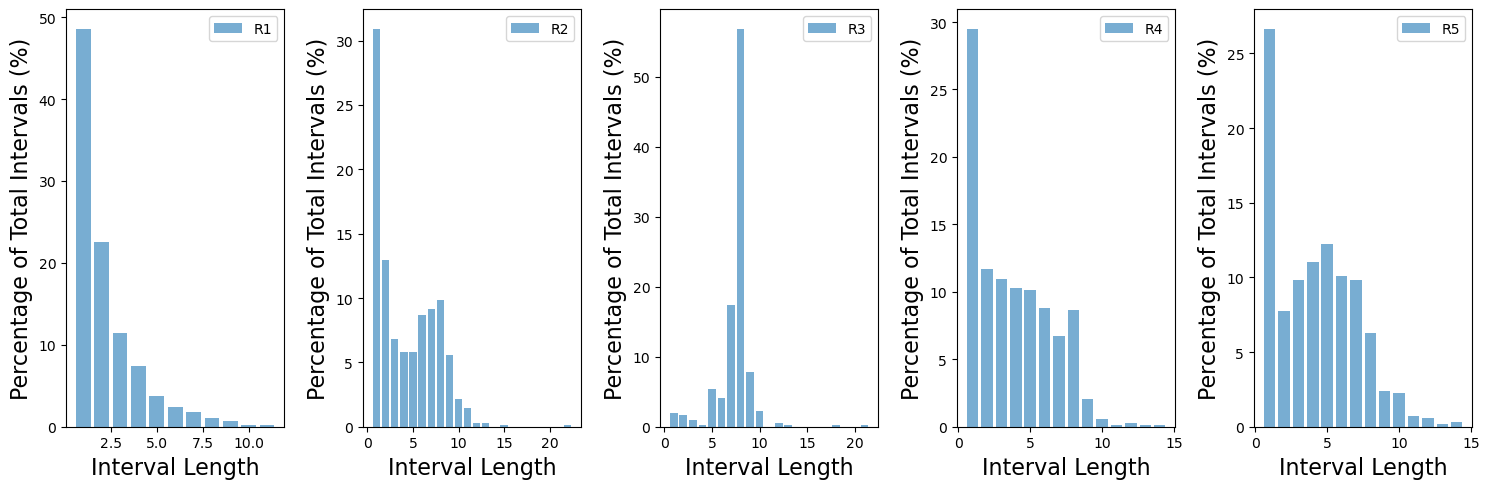

/var/folders/58/gxcqk5bd4055b6n0b6yszvlw0000gn/T/ipykernel_11314/2857402323.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


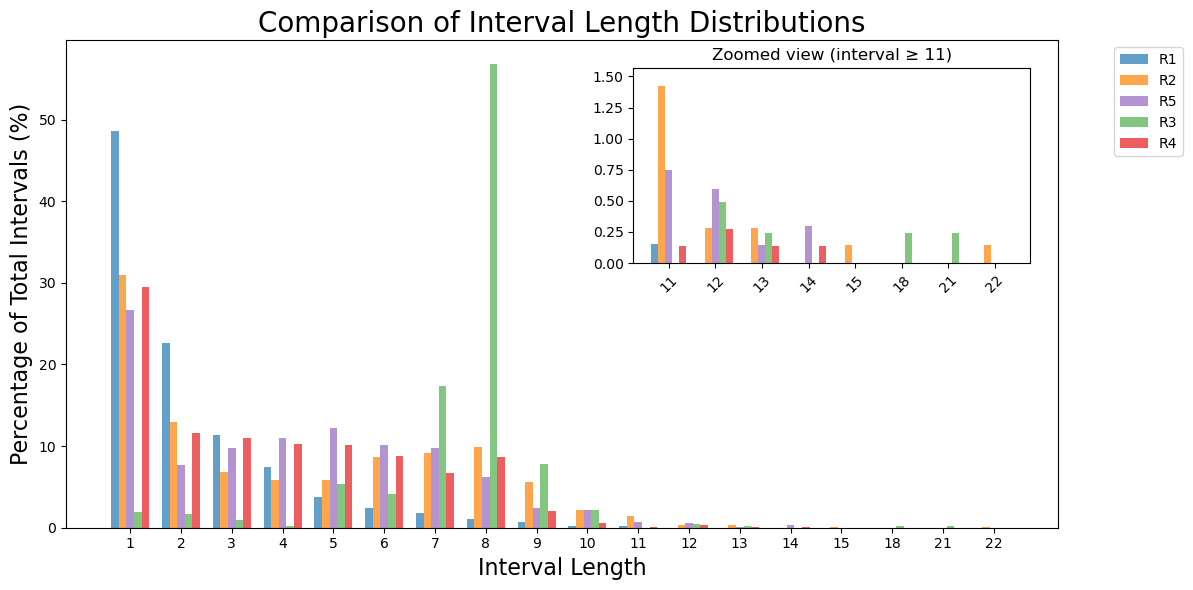

In [217]:
#Plot histograms
num=12
#ensavgs=[ens_avg_change_in_ext_work_random_c2,ens_avg_change_in_ext_work_greedy_c2,ens_avg_change_in_ext_work_landscape_maximizes_c2,ens_avg_change_in_ext_work_strongest_maximizes_c2,
#        ens_avg_change_in_ext_work_mimic_c2]
ensavgs=[ens_avg_change_in_ext_work_random_c4,ens_avg_change_in_ext_work_greedy_c4,ens_avg_change_in_ext_work_landscape_maximizes_c4,ens_avg_change_in_ext_work_strongest_maximizes_c4,
        ens_avg_change_in_ext_work_mimic_c4]
#Num_steps_positive_random = Num_steps_positive(ensavgs[0])
#Num_steps_positive_greedy = Num_steps_positive(ensavgs[1])
#Num_steps_positive_landmax = Num_steps_positive(ensavgs[2])
#Num_steps_positive_smax = Num_steps_positive(ensavgs[3])
#Num_steps_positive_mimic = Num_steps_positive(ensavgs[5])

        
tally_random=tally_elements(list_of_consecutive_positive_steps(ensavgs[0],num))
tally_greedy=tally_elements(list_of_consecutive_positive_steps(ensavgs[1],num))
tally_landmax=tally_elements(list_of_consecutive_positive_steps(ensavgs[2],num))
tally_mimic=tally_elements(list_of_consecutive_positive_steps(ensavgs[4],num))
tally_smax=tally_elements(list_of_consecutive_positive_steps(ensavgs[3],num))

        
del tally_landmax[0]
del tally_random[0]
del tally_greedy[0]
del tally_mimic[0]
del tally_smax[0]
    
# Individual subplots code remains the same
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
        
plot_histogram(axs[0], tally_random, 'R1')
plot_histogram(axs[1], tally_greedy, 'R2')
plot_histogram(axs[4], tally_mimic, 'R5')
plot_histogram(axs[2], tally_landmax, 'R3')
plot_histogram(axs[3], tally_smax, 'R4')

# Update all y-axis labels
for ax in axs:
    ax.set_ylabel('Percentage of Total Intervals (%)')

plt.tight_layout()
plt.savefig('Histogram_interval_distribution_12Q_inhomo_v2_c4.png')
plt.show()

# Create a grouped bar chart with zoomed inset
create_grouped_bar_chart_with_zoom("12Q_inhomo_v2_c4",
    [tally_random, tally_greedy, tally_mimic, tally_landmax, tally_smax],
    ['R1', 'R2', 'R5', 'R3', 'R4'],
    ['#1F78B4', '#FF7F00', '#9467BD', '#4DAF4A', '#E41A1C'],
    zoom_threshold=11  # Zoom in on interval lengths 10 and above
)

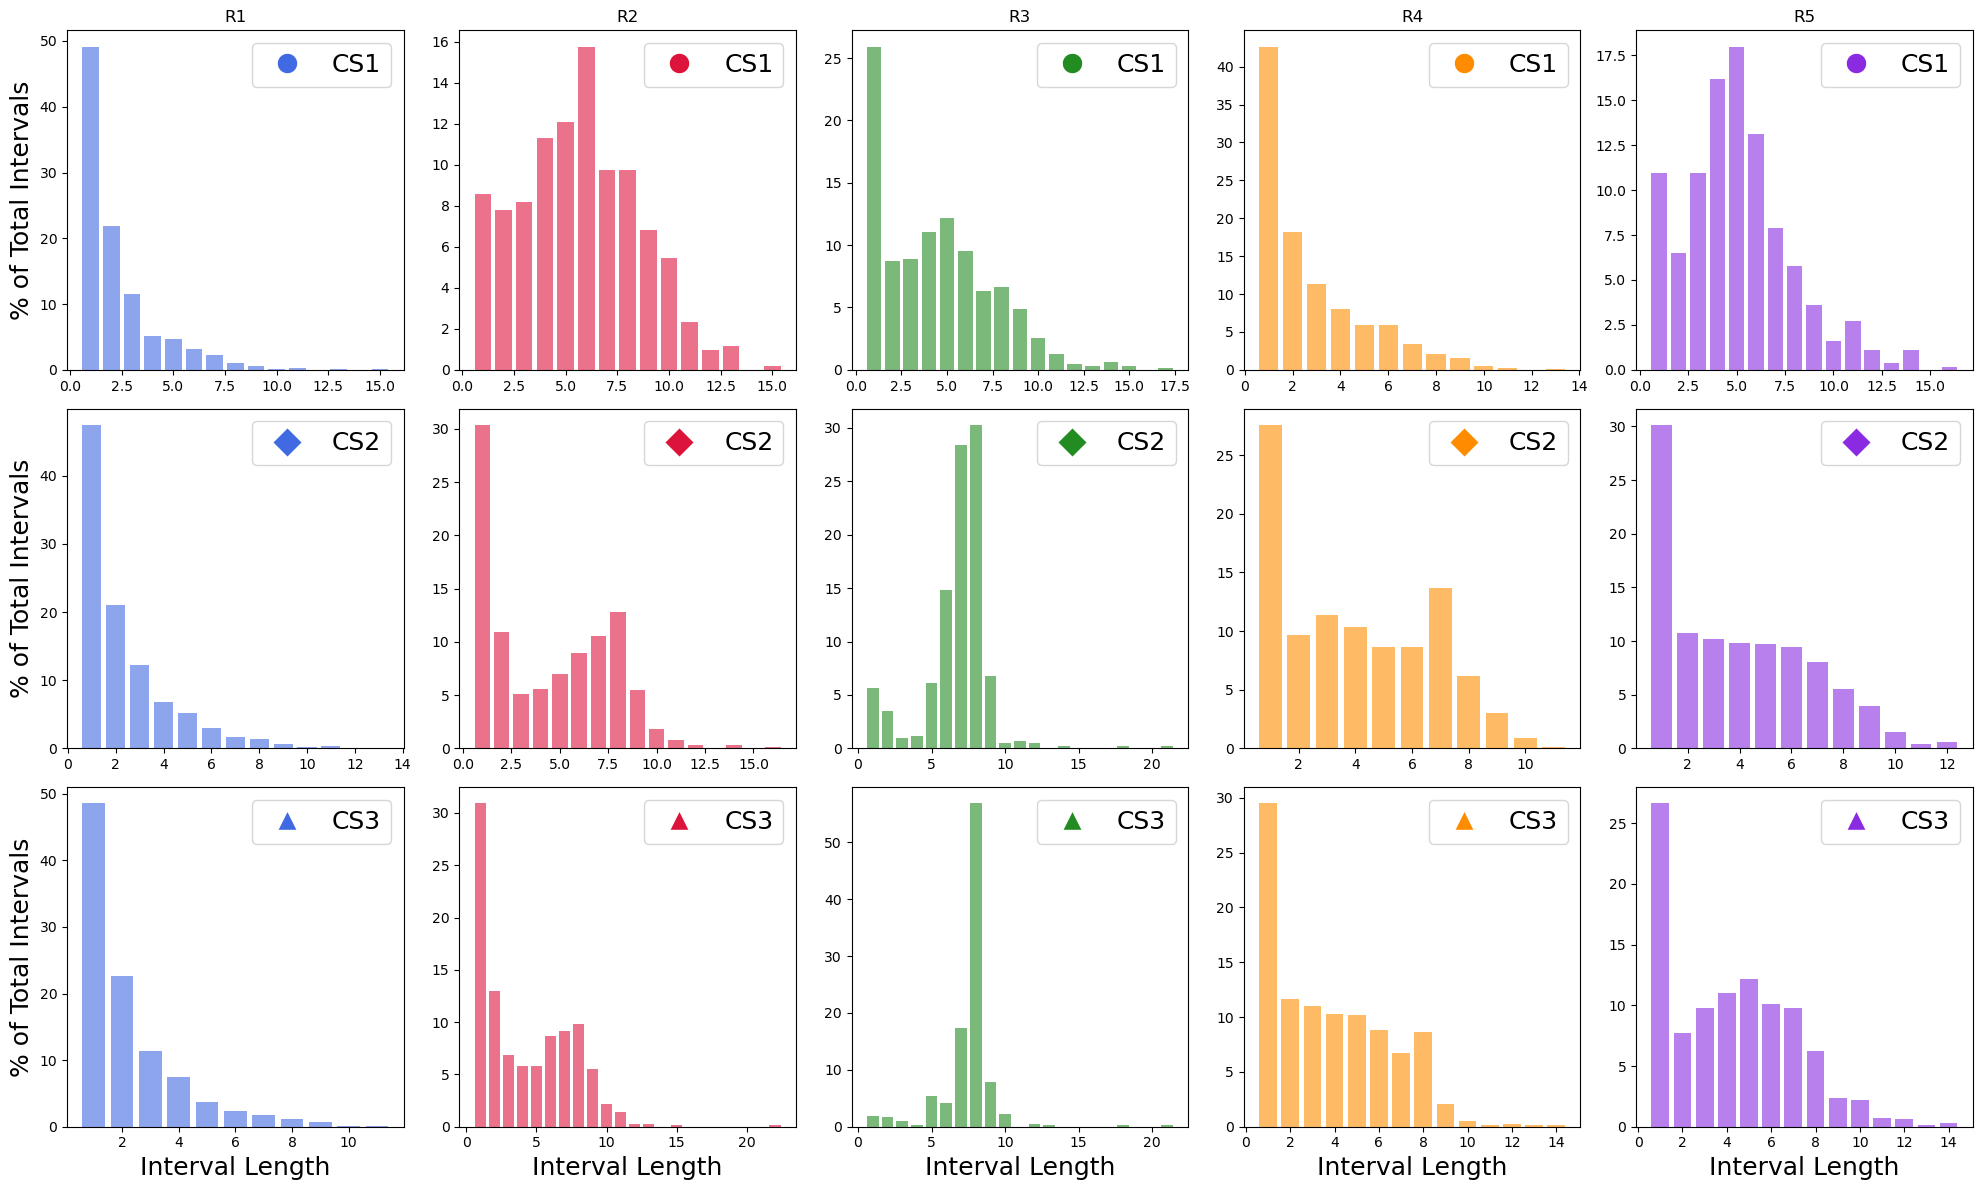

(<Figure size 2000x1200 with 15 Axes>,
 array([[<Axes: title={'center': 'R1'}, ylabel='% of Total Intervals'>,
         <Axes: title={'center': 'R2'}>, <Axes: title={'center': 'R3'}>,
         <Axes: title={'center': 'R4'}>, <Axes: title={'center': 'R5'}>],
        [<Axes: ylabel='% of Total Intervals'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: xlabel='Interval Length', ylabel='% of Total Intervals'>,
         <Axes: xlabel='Interval Length'>,
         <Axes: xlabel='Interval Length'>,
         <Axes: xlabel='Interval Length'>,
         <Axes: xlabel='Interval Length'>]], dtype=object))

In [11]:
def plot_multiple_distributions(data_sets, num, titles=None, filename=None, figsize=(20, 12)):
    """
    Plot histograms for multiple sets of ensemble average data.
    
    Parameters:
    -----------
    data_sets : list of lists
        Each inner list contains ensemble averages for different strategies
        [random, greedy, landscape_max, strongest_max, mimic]
    num : int
        Number of steps to consider
    titles : list of str, optional
        Titles for each row of plots
    filename : str, optional
        Filename to save the figure
    figsize : tuple, optional
        Figure size (width, height)
    """
    #if titles is None:
    #    titles = [f"Dataset {i+1}" for i in range(len(data_sets))]
    
    # Create figure with subplots
    fig, axs = plt.subplots(len(data_sets), 5, figsize=figsize)
    
    # For single dataset case, reshape axs to be 2D
    if len(data_sets) == 1:
        axs = np.array([axs])
    
    # Define strategy names
    strategy_names = ['R1', 'R2', 'R3', 'R4', 'R5']
    colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    markers=["o","D","^"]
    labels=["CS1","CS2","CS3"]
    # Add strategy names as column titles at the top of the figure
    for j, name in enumerate(strategy_names):
        axs[0, j].set_title(name)
    
    # Process each dataset
    for i, ensavgs in enumerate(data_sets):
        # Calculate tallies for each strategy
        tally_random = tally_elements(list_of_consecutive_positive_steps(ensavgs[0], num))
        tally_greedy = tally_elements(list_of_consecutive_positive_steps(ensavgs[1], num))
        tally_landmax = tally_elements(list_of_consecutive_positive_steps(ensavgs[2], num))
        tally_smax = tally_elements(list_of_consecutive_positive_steps(ensavgs[3], num))
        tally_mimic = tally_elements(list_of_consecutive_positive_steps(ensavgs[4], num))
        
        # Remove zero elements
        del tally_random[0]
        del tally_greedy[0]
        del tally_landmax[0]
        del tally_mimic[0]
        del tally_smax[0]
        
        # Plot histograms (without labels inside)
        # Create a modified version of plot_histogram that doesn't add the title
        plot_histogram_without_title(axs[i, 0], tally_random,colors[0],marker=markers[i],label=labels[i])
        plot_histogram_without_title(axs[i, 1], tally_greedy,colors[1],marker=markers[i],label=labels[i])
        plot_histogram_without_title(axs[i, 2], tally_landmax,colors[2],marker=markers[i],label=labels[i])
        plot_histogram_without_title(axs[i, 3], tally_smax,colors[3],marker=markers[i],label=labels[i])
        plot_histogram_without_title(axs[i, 4], tally_mimic,colors[4],marker=markers[i],label=labels[i])
        
        # Only add y-axis label to the leftmost column in each row
        axs[i, 0].set_ylabel("% of Total Intervals", fontsize=18)
        
        # Remove y-axis labels for all other plots in the row
        for j in range(1, 5):
            axs[i, j].set_ylabel("")
        
        # Add row title to the left of the leftmost plot
        #axs[i, 0].text(-0.3, 0.5, titles[i], transform=axs[i, 0].transAxes, 
        #              rotation=90, va='center', ha='center', fontsize=12)
        
        # Remove x-axis labels for all but the bottom row
        if i < len(data_sets) - 1:
            for j in range(5):
                axs[i, j].set_xlabel("")
        
    # Set common x-axis label for bottom row only
    for j in range(5):
        axs[-1, j].set_xlabel('Interval Length', fontsize=18)  # Change 14 to your desired font size
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()
    return fig, axs

def plot_histogram_without_title(ax, tally, col, marker,label):
    """
    Plot histogram without adding title.
    This is a modified version of your plot_histogram function
    that doesn't add the 'R1', 'R2', etc. titles inside each plot.
    """
    
    # Assuming your plot_histogram function looks something like this:
    keys = list(tally.keys())
    values = list(tally.values())
    
    # Calculate percentage values
    total = sum(values)
    percentages = [v / total * 100 for v in values]
    
    # Create the bar plot
    ax.bar(keys, percentages, color=col, alpha=0.6)
    
    # Create custom legend with the specified marker
    from matplotlib.lines import Line2D
    legend_element = [Line2D([0], [0], marker=marker, color='w', 
                             markerfacecolor=col, markersize=15,
                             label=label)]
    
    # Add the legend to the plot
    ax.legend(handles=legend_element, prop={'size': 18})
    # Don't set a title here
data_sets = [
    [ens_avg_change_in_ext_work_random_c4_th, ens_avg_change_in_ext_work_greedy_c4_th, 
     ens_avg_change_in_ext_work_landscape_maximizes_c4_th, ens_avg_change_in_ext_work_strongest_maximizes_c4_th,
     ens_avg_change_in_ext_work_mimic_c4_th],
    
    [ens_avg_change_in_ext_work_random_c4_v1, ens_avg_change_in_ext_work_greedy_c4_v1, 
     ens_avg_change_in_ext_work_landscape_maximizes_c4_v1, ens_avg_change_in_ext_work_strongest_maximizes_c4_v1,
     ens_avg_change_in_ext_work_mimic_c4_v1],

    [ens_avg_change_in_ext_work_random_c4_v2, ens_avg_change_in_ext_work_greedy_c4_v2, 
     ens_avg_change_in_ext_work_landscape_maximizes_c4_v2, ens_avg_change_in_ext_work_strongest_maximizes_c4_v2,
     ens_avg_change_in_ext_work_mimic_c4_v2]
]

# Plot with row titles
row_titles = ['CS1', 'CS2', 'CS3']
plot_multiple_distributions(data_sets, num=12, titles=row_titles, 
                            filename='Histogram_interval_distribution_Positive_delta_W_12Q_all_datasets_c4.png')

In [230]:
ens_avg_change_in_ext_work_random_c2_th[0]

NameError: name 'ens_avg_change_in_ext_work_random_c2_th' is not defined

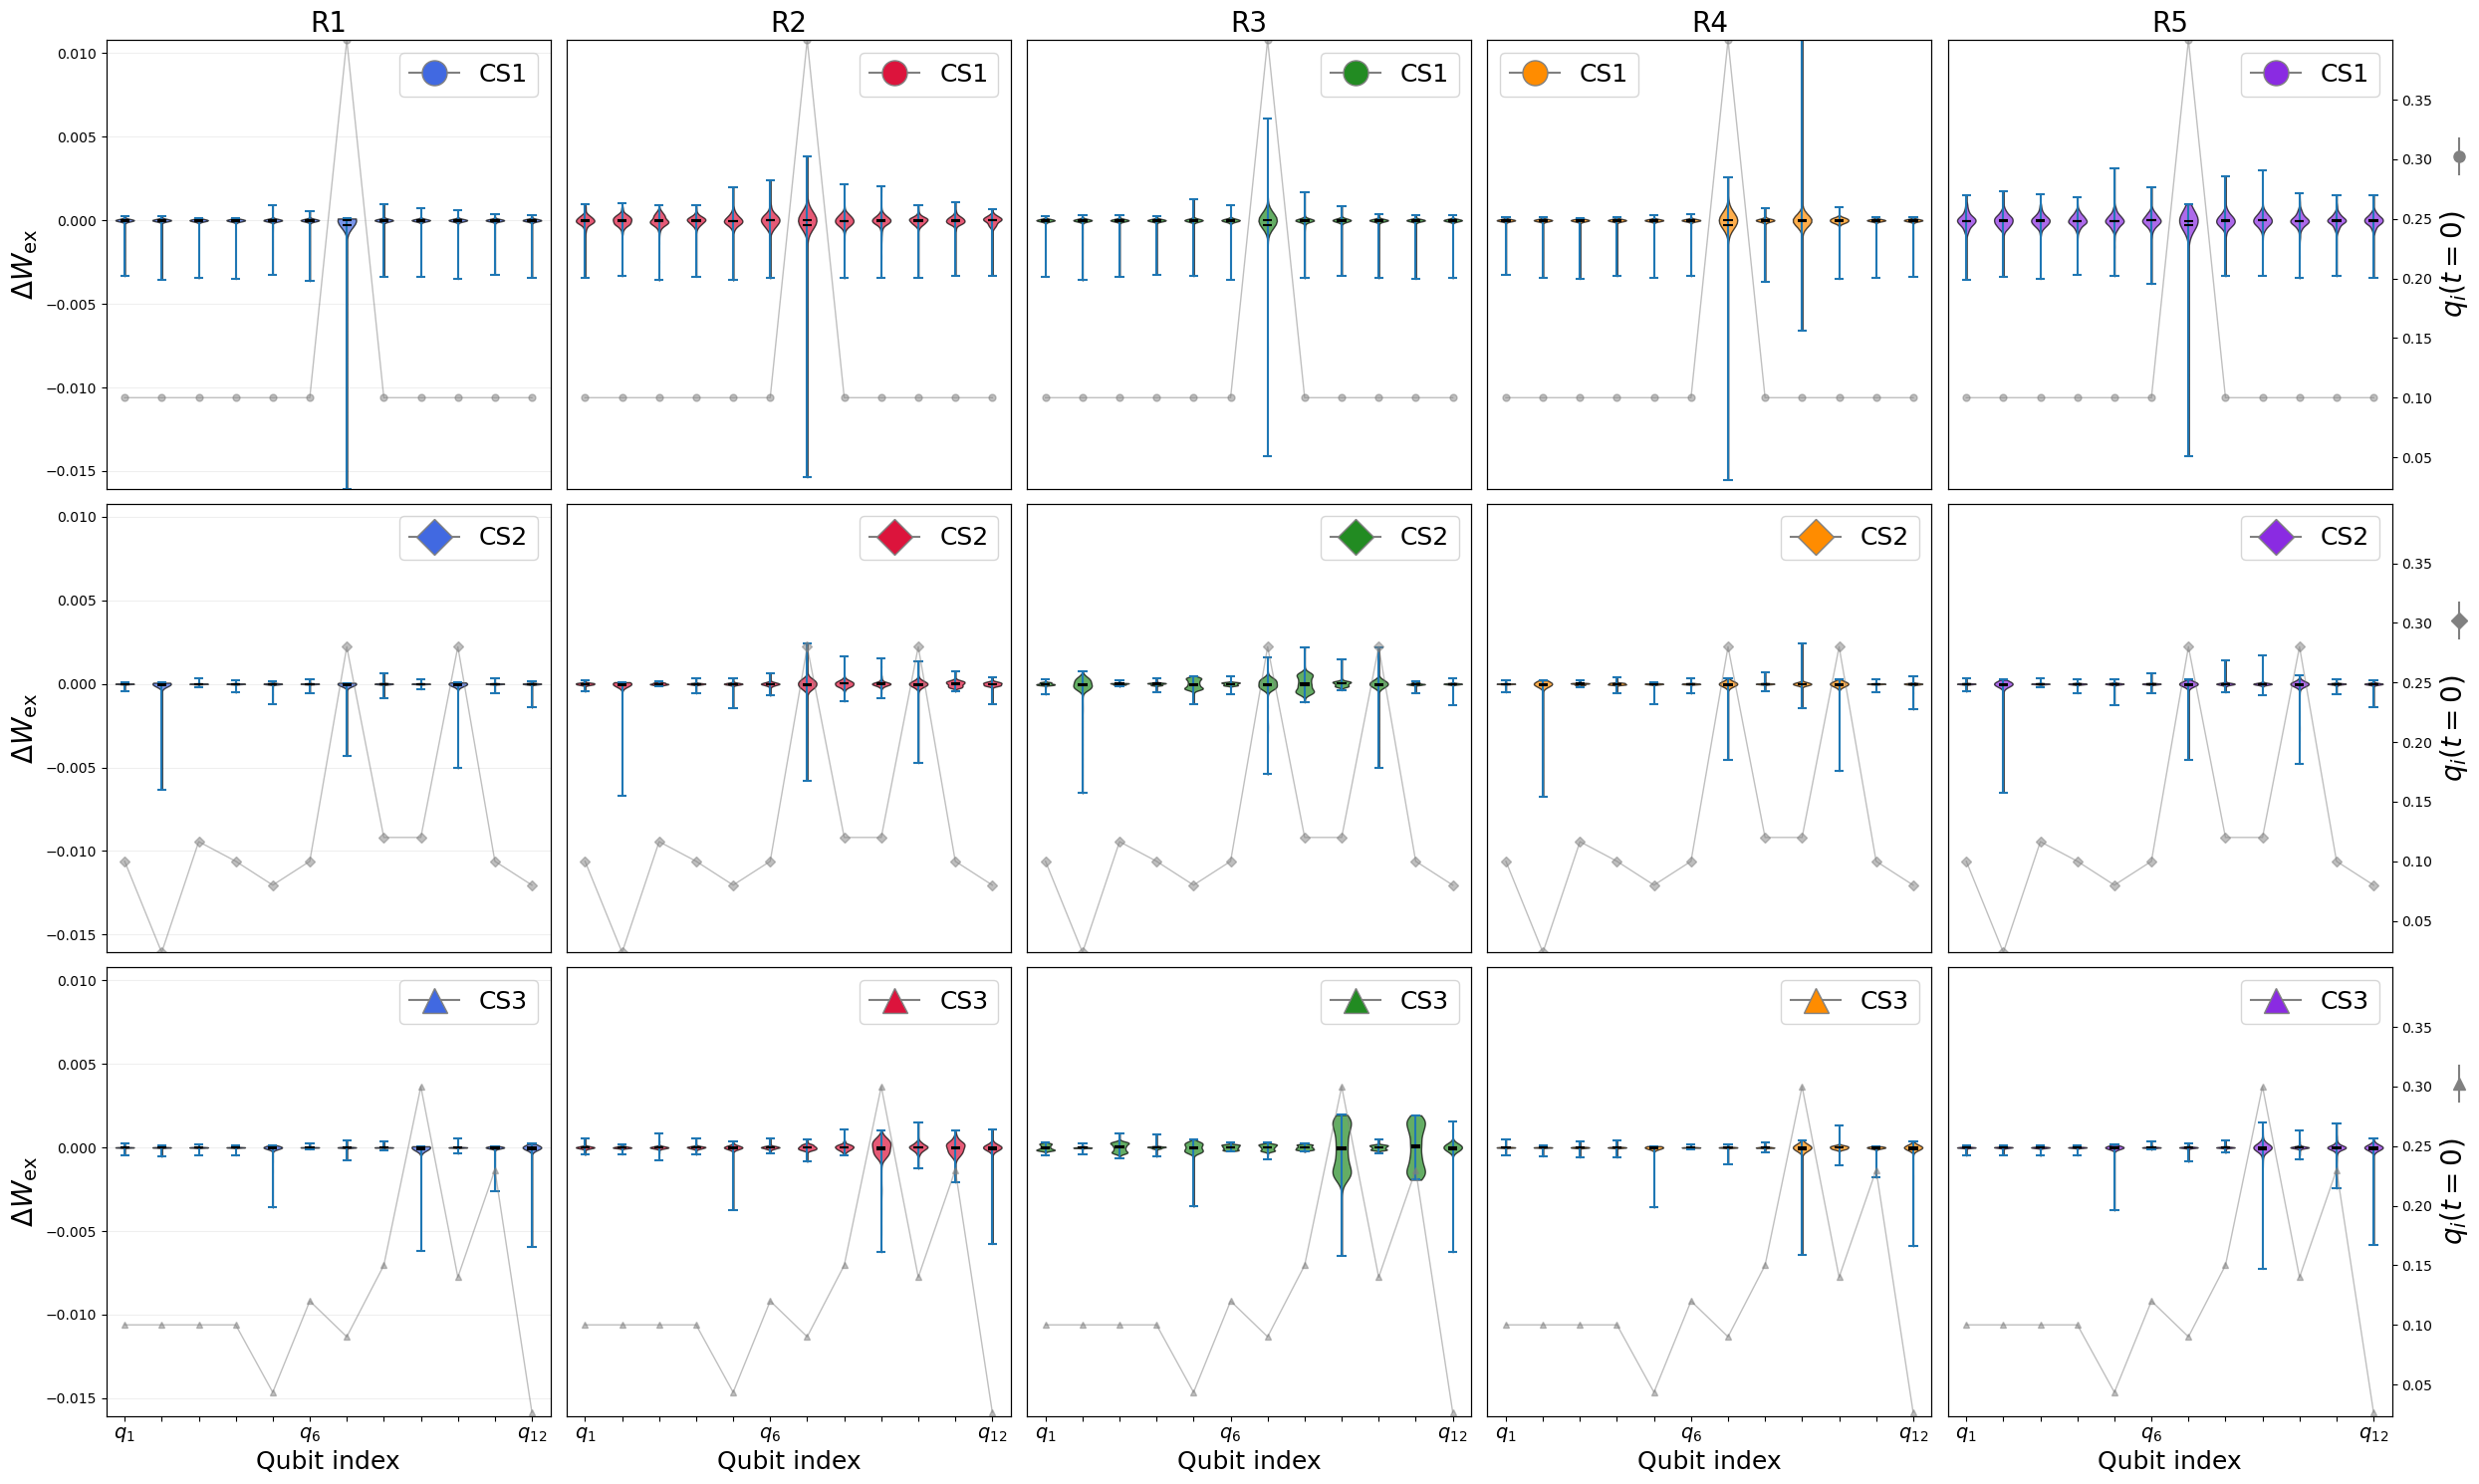

(<Figure size 2500x1500 with 30 Axes>,
 array([[<Axes: title={'center': 'R1'}, ylabel='$\\Delta W_{\\rm ex}$'>,
         <Axes: title={'center': 'R2'}>, <Axes: title={'center': 'R3'}>,
         <Axes: title={'center': 'R4'}>, <Axes: title={'center': 'R5'}>],
        [<Axes: ylabel='$\\Delta W_{\\rm ex}$'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: xlabel='Qubit index', ylabel='$\\Delta W_{\\rm ex}$'>,
         <Axes: xlabel='Qubit index'>, <Axes: xlabel='Qubit index'>,
         <Axes: xlabel='Qubit index'>, <Axes: xlabel='Qubit index'>]],
       dtype=object))

In [12]:
def plot_multiple_violin_distributions(data_sets, titles=None, filename=None, figsize=(25, 15)):
    """
    Plot violin plots for multiple sets of ensemble average data with additional line plots.
    
    Parameters:
    -----------
    data_sets : list of lists
        Each inner list contains ensemble averages for different strategies
        [random, greedy, landscape_max, strongest_max, mimic]
    titles : list of str, optional
        Titles for each row of plots
    filename : str, optional
        Filename to save the figure
    figsize : tuple, optional
        Figure size (width, height)
    """
    if titles is None:
        titles = [f"Dataset {i+1}" for i in range(len(data_sets))]
    
    # Define strategy names
    strategy_names = ['R1', 'R2', 'R3', 'R4', 'R5']
    colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    markers = ["o", "D", "^"]
    labels = ["CS1", "CS2", "CS3"]
    
    # Data for line plots
    line_data = [
        [0.10000003, 0.10000003, 0.1, 0.1, 0.10000003, 0.10000003, 0.39999998, 0.1, 0.1, 0.1, 0.1, 0.1],  # th
        [0.09999999, 0.02352335, 0.11647666, 0.1, 0.07999999, 0.1, 0.28, 0.12, 0.12, 0.28000003, 0.1, 0.08],  # v1
        [0.09999999, 0.09999999, 0.10000001, 0.10000001, 0.04340705, 0.12, 0.09, 0.14999999, 0.3, 0.14000002, 0.22999999, 0.02659295]  # v2
    ]
    
    # Calculate global min and max for line plots
    line_min = min([min(data) for data in line_data])
    line_max = max([max(data) for data in line_data])
    
    # Create figure with subplots
    fig, axs = plt.subplots(len(data_sets), 5, figsize=figsize)
    
    # For single dataset case, reshape axs to be 2D
    if len(data_sets) == 1:
        axs = np.array([axs])
        
    # Calculate global min and max for consistent y-axis scaling
    all_data = []
    for ensavgs in data_sets:
        for data in ensavgs:
            all_data.extend(np.array(data).flatten())
    global_min = np.min(all_data)
    global_max = np.max(all_data)
    
    # Add strategy names as column titles at the top of the figure with larger font
    for j in range(5):
        axs[0, j].set_title(strategy_names[j], fontsize=20)
    
    # Process each dataset
    for i, ensavgs in enumerate(data_sets):
        for j, data in enumerate(ensavgs):
            # Create twin axis for line plots
            ax2 = axs[i, j].twinx()
            
            # Set consistent y limits for the twin axis
            ax2.set_ylim(line_min, line_max)
            
            # Only add y-axis label to the rightmost column in each row
            if j == 4:
                # Set the y-label
                ax2.set_ylabel(r'$q_i (t=0)$', fontsize=20)

                if i == 0:
                
                
                    ylabel = ax2.yaxis.label
                    x_pos = 1.15  # Position just outside the right edge of the plot
                    y_pos = 0.7  # Position just above the top edge of the plot
                    
                    # Add a vertical line with a circle
                    line_length = 0.08
                    ax2.plot([x_pos, x_pos], [y_pos, y_pos + line_length], 
                             color='gray', transform=ax2.transAxes, clip_on=False)
                    ax2.plot(x_pos, y_pos + line_length/2, 'o', 
                             color='gray', markersize=8, transform=ax2.transAxes, clip_on=False)
                if i == 1:
                    ylabel = ax2.yaxis.label
                    x_pos = 1.15  # Position just outside the right edge of the plot
                    y_pos = 0.7  # Position just above the top edge of the plot
                    
                    # Add a vertical line with a circle
                    line_length = 0.08
                    ax2.plot([x_pos, x_pos], [y_pos, y_pos + line_length], 
                             color='gray', transform=ax2.transAxes, clip_on=False)
                    ax2.plot(x_pos, y_pos + line_length/2, 'D', 
                             color='gray', markersize=8, transform=ax2.transAxes, clip_on=False)

                if i == 2:
                    ylabel = ax2.yaxis.label
                    x_pos = 1.15  # Position just outside the right edge of the plot
                    y_pos = 0.7  # Position just above the top edge of the plot
                    
                    # Add a vertical line with a circle
                    line_length = 0.08
                    ax2.plot([x_pos, x_pos], [y_pos, y_pos + line_length], 
                             color='gray', transform=ax2.transAxes, clip_on=False)
                    ax2.plot(x_pos, y_pos + line_length/2, '^', 
                             color='gray', markersize=8, transform=ax2.transAxes, clip_on=False)
            # Only show y-ticks on the rightmost column
            if j < 4:
                ax2.set_yticks([])

            
            # Plot the line data with proper markers
            x_positions = list(range(1, 13))
            ax2.plot(x_positions, line_data[i], color='grey', alpha=0.5, 
                    marker=markers[i], markersize=5, linestyle='-', linewidth=1,zorder=1)
            ax2.grid(False)
            
            # Reshape data - assuming data is a list of 500 rows with 12 values each
            # Convert to numpy array for easier manipulation
            data_array = np.array(data)

            # Create grid for all
            axs[i, j].grid(axis='y', linestyle='-', alpha=0.2)
            # Turn off grid on x-axis
            axs[i, j].grid(axis='x', visible=False)
            
            # Create a list of positions (1 through 12)
            positions = list(range(1, 13))
            
            # Create violin plot with color from the colors list based on column j
            vp = axs[i, j].violinplot(
                [data_array[:, k] for k in range(12)],
                positions=positions,
                showmeans=True,
                showmedians=True
            )
            
            # Customize violin plot colors to match the column color
            for pc in vp['bodies']:
                pc.set_facecolor(colors[j])
                pc.set_edgecolor('black')
                pc.set_alpha(0.7)
                pc.set_zorder(2) 
            
            # Customize mean and median markers
            vp['cmeans'].set_color('black')
            vp['cmeans'].set_zorder(3)
            vp['cmedians'].set_color('black')
            vp['cmedians'].set_zorder(3)
            
            # Set x-axis limits
            axs[i, j].set_xlim(0.5, 12.5)
            
            # Set consistent y-axis limits for all plots
            axs[i, j].set_ylim(global_min, global_max)
            
            # Remove x-axis ticks from all but the bottom row
            if i < len(data_sets) - 1:
                axs[i, j].set_xticks([])
                axs[i, j].set_xticklabels([])
            else:
                # For bottom row, set x-axis labels to q_1 through q_12 with large font
                axs[i, j].set_xticks(positions)
                x_labels = [''] * 12
                x_labels[0] = '$q_{1}$'  # First position (index 0)
                x_labels[5] = '$q_{6}$'  # Sixth position (index 5)
                x_labels[11] = '$q_{12}$'  # Twelfth position (index 11)
                axs[i, j].set_xticklabels(x_labels, fontsize=14)
                axs[i, j].set_xlabel('Qubit index', fontsize=18)
            
            # Only add y-axis label to the leftmost column in each row
            if j == 0:
                axs[i, j].set_ylabel(r'$\Delta W_{\rm ex}$', fontsize=20)
            else:
                axs[i, j].set_yticks([])
                axs[i, j].set_yticklabels([])
                axs[i, j].set_ylabel("")
            
            # Create custom legend with the row's marker
            from matplotlib.lines import Line2D
            legend_element = [Line2D([0], [0], marker=markers[i], color='grey', 
                                    markerfacecolor=colors[j], markersize=18, 
                                    label=labels[i])]
            
            # Add the legend with custom font size
            axs[i, j].legend(handles=legend_element, prop={'size': 18})
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300)  # Higher DPI for better quality
    
    plt.show()
    return fig, axs
# Example usage:
row_titles = ['CS1', 'CS2', 'CS3']
plot_multiple_violin_distributions(data_sets, titles=row_titles, 
                                  filename='Violin_plots_Delta_W_12Q_CS123_all_rules_c4.png')

In [13]:
#number of steps in any one evolution
steps=499
# insert the angle denominator chosen for Haar Q unitary eg pi/15 then denom =15
denom = 15 
#find the the numerical value of shift per qubit map in one trial index i.e. one full time series of evolution
def tz_two_q_dyns_map(pops_trial_index,denom): 
    tz = []
    np.array(pops_trial_index)
    for step_index in range(steps):
        tzi =  np.sin(np.pi/denom)*np.sin(np.pi/denom) -2*(pops_trial_index[step_index + 1 ] - np.cos(np.pi / denom)*np.cos(np.pi / denom)* pops_trial_index[step_index])
        tz.append(tzi)
    return tz

ytherm8= (7*0.1 + 0.4)/8
ytherm10=(9*0.1 + 0.4)/10
ytherm12=(11*0.1 + 0.4)/12

#CPcond()
#Note if this is broke the map is not only NCP also not P
def abs_tz(pops,denom):
    abs_tz=[]
    for step in tz_two_q_dyns_map(pops,denom):
        abs_step = [abs(ele) for ele in step]
        abs_tz.append(abs_step) 
    return abs_tz
def CPcond(abs_tz_pops) :
    cp_cond=[]
    for step in abs_tz_pops:
        cp_step = [ele + np.cos(np.pi / denom) * np. cos(np.pi / denom)  for ele in step]
        cp_cond.append(cp_step) 
    return cp_cond

def means_stds_of_tz_of_one_sim_index(tz_trial_index):
    mean_stds_list = []
    for step_index in range(steps):
        stds = np.std(tz_trial_index [step_index])
        means = np.mean(tz_trial_index[step_index])
        mean_stds_list.append([means, stds])
    return mean_stds_list

def means_stds_mode_of_tz_of_one_sim_index(tz_trial_index):
    mean_stds_mode_list = []
    for step_index in range(steps):
        total = sum(tz_trial_index[step_index])
        stds = np.std(tz_trial_index[step_index])
        means = np.mean(tz_trial_index[step_index])
        mode = max(tz_trial_index[step_index])
        mean_stds_mode_list.append([total,stds,means,mode])
    return mean_stds_mode_list

def extract_total(list_of_lists):
    return [sublist[0] for sublist in list_of_lists]
def extract_stds(list_of_lists):
    return [sublist[1] for sublist in list_of_lists]
def extract_means(list_of_lists):
    return [sublist[2] for sublist in list_of_lists]
def extract_mode(list_of_lists):
    return [sublist[3] for sublist in list_of_lists]

def ensemble_averaged_one_point_measures_mean_std(datasets):
    # Assuming datasets is a list of 100 datasets, where each dataset is a 2D array of shape (100, N)
    # Stack datasets into a 3D array
    stacked_data = np.stack(datasets)  # Shape (100, 100, N)

    # Take the ensemble average along the first axis (averaging over all datasets)
    ensemble_average = np.mean(stacked_data, axis=0)  # Shape (100, N)

    # Calculate the standard deviation along the first axis
    ensemble_std = np.std(stacked_data, axis=0) 
    return (ensemble_average, ensemble_std)

def time_averaged_one_point_measures_at_t(dataset, t, n):
    # Assuming dataset is list of time series data
    # Calculate the time average using window size n
    # Make sure we don't go below index 0
    start_idx = max(0, t-n)
    sum_till_t = np.sum(dataset[start_idx:t], axis=0)
    # The actual window size might be smaller if t < n
    actual_window_size = t - start_idx
    # Avoid division by zero
    if actual_window_size == 0:
        return np.zeros_like(dataset[0])
    time_average_t = (1/actual_window_size) * sum_till_t
    return time_average_t

def time_averaged_one_point_measures_matrix_full_sim(dataset, n):
    # Calculate time averages for all time points with window size n
    time_average = []
    for t in range(len(dataset)):
        time_average.append(time_averaged_one_point_measures_at_t(dataset, t, n))
    return time_average
ytherm8= (7*0.1 + 0.4)/8
ytherm10=(9*0.1 + 0.4)/10
ytherm12=(11*0.1 + 0.4)/12
ytherm14=(13*0.1 + 0.4)/14

ypure8=(7*0 + 1)/8
ypure10=(9*0 + 1)/10
ypure12=(11*0 + 1)/12
ypure14=(13*0 + 1)/14

In [ ]:
dataset_names = ["$^{IC_{p}}R_{1;C2} ^{10Q}$", "$^{IC_{p}}R_{2;C2} ^{10Q}$", "$^{IC_{p}}R_{3;C2} ^{10Q}$", "$^{IC_{p}}R_{4;C2} ^{10Q}$", "$^{IC_{p}}R_{5;C2} ^{10Q}$"]  # Names corresponding to each dataset
datas=[pops_random_c2_pure,pops_greedy_c2_pure,pops_landscape_maximizes_c2_pure,pops_strongest_maximizes_c2_pure,pops_mimic_c2_pure]

global_max = 0
all_processed_data = []

for pops in datas:
    es_avg = ensemble_averaged_one_point_measures_mean_std(pops)[0]
    fulllist = []
    
    for timestep in CPcond(abs_tz(es_avg, denom)):
        timesteplist = []
        for ele in timestep:
            if ele <= 1:
                ele = 0
            timesteplist.append(ele)
        fulllist.append(timesteplist)
    
    rotated_data = np.rot90(fulllist[20:499])
    all_processed_data.append(rotated_data)
    current_max = np.max(rotated_data)
    if current_max > global_max:
        global_max = current_max

# Create a figure with subplots and a common colorbar
fig = plt.figure(figsize=(50, 30))

# Add super title (appears at the top of all subplots)
plt.suptitle('Breaking of CP condition for the qubit dynamical maps', fontsize=40, y=0.98)

# Create a layout with 5 rows and 1 column for the plots
# Plus extra space at the bottom for the colorbar
gs = gridspec.GridSpec(6, 1, height_ratios=[1, 1, 1, 1, 1, 0.1])

# Create a colormap with white for zeros and a plasma gradient for values > 1
n_bins = 100  # Number of color gradations
cmap_gradient = plt.cm.plasma(np.linspace(0.4, 1.0, n_bins))
    
# Add white for the zero values (making it black here, as specified in original code)
colors = np.vstack(([0, 0, 0, 1], cmap_gradient))
    
# Create the new colormap
custom_cmap = ListedColormap(colors)
    
# Set up the boundaries for the colormap
# First boundary is 0, then divide the range from 1 to global_max into n_bins parts
boundaries = np.concatenate(([0], np.linspace(1, global_max, n_bins)))
norm = BoundaryNorm(boundaries, custom_cmap.N)

# Create subplots
images = []
for i, (rotated_data, conn) in enumerate(zip(all_processed_data, dataset_names)):
    ax = plt.subplot(gs[i])
    img = ax.imshow(rotated_data, interpolation='none', aspect='auto', 
                   cmap=custom_cmap, norm=norm)
    ax.set_title(f'For {conn}', fontsize=35)
    images.append(img)

# Add a common colorbar at the bottom
cax = plt.subplot(gs[5])
tick_locations = np.linspace(1, global_max, 5)  # 5 ticks from 1 to global_max
cbar = fig.colorbar(images[0], cax=cax, orientation='horizontal', ticks=tick_locations)
cbar.ax.tick_params(labelsize=28)
cbar.set_label('Non-CP condition', fontsize=28)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout but leave room for suptitle
plt.savefig('Non_CP_10_Q_Pure.png', bbox_inches='tight')

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def time_averaged_one_point_measures_at_t(dataset, t, n):
    # Calculate time average using:
    # - At beginning: n/2 forward and everything behind
    # - At end: n/2 behind and everything forward
    # - In middle: use n/2 backward and n/2 forward
    
    half_window = n // 2
    data_length = len(dataset)
    
    # Case 1: Beginning of dataset (t < half_window)
    if t < half_window:
        # Use everything behind plus forward points up to half_window
        # This means from index 0 to t + half_window
        end_idx = min(data_length, t + half_window + 1)
        window_data = dataset[:end_idx]  # From start to t + half_window
    
    # Case 2: End of dataset (t >= data_length - half_window)
    elif t >= data_length - half_window:
        # Use backward points from t - half_window plus everything forward
        # This means from t - half_window to the end
        start_idx = max(0, t - half_window)
        window_data = dataset[start_idx:]  # From t - half_window to end
    
    # Case 3: Middle of dataset
    else:
        # Use both backward and forward points
        start_idx = t - half_window
        end_idx = t + half_window + 1
        window_data = dataset[start_idx:end_idx]
    
    # Calculate the average over the window
    if len(window_data) == 0:
        return np.zeros_like(dataset[0])
    
    time_average = np.mean(window_data, axis=0)
    return time_average

def plot_multiple_datasets(datasets, window_size=30, figsize=(28, 5)):
    """
    Plot multiple datasets in a row of subplots.
    
    Parameters:
    -----------
    datasets : list
        List of datasets to plot
    window_size : int
        Window size for time averaging
    figsize : tuple
        Figure size
    """
    num_datasets = len(datasets)
    
    # Create figure and axes
    fig, axes = plt.subplots(1, num_datasets, figsize=figsize)
    
    # If only one dataset, axes won't be an array
    if num_datasets == 1:
        axes = [axes]
    
    # Process each dataset
    for i, dataset in enumerate(datasets):
        dataset_length = len(dataset)
        
        # Calculate time averages for each time point
        time_averages = []
        for t in range(1, dataset_length):
            time_avg = time_averaged_one_point_measures_at_t(dataset, t, window_size)
            time_averages.append(time_avg)
        
        # Convert to numpy array for easier plotting
        time_averages = np.array(time_averages)
        
        # Plot on the corresponding subplot
        axes[i].plot(range(1, dataset_length), time_averages)
        axes[i].set_title(f'R{i+1}',fontsize=18)
        axes[i].set_xlabel('Time')
        if i==0:
            axes[i].set_ylabel(r'$\tau_{z,i}$')
    
    plt.tight_layout()
    return fig

# Example usage:
# Assuming you have 5 datasets in a list called 'datasets'
(0.1*11+0.4)/12

0.125

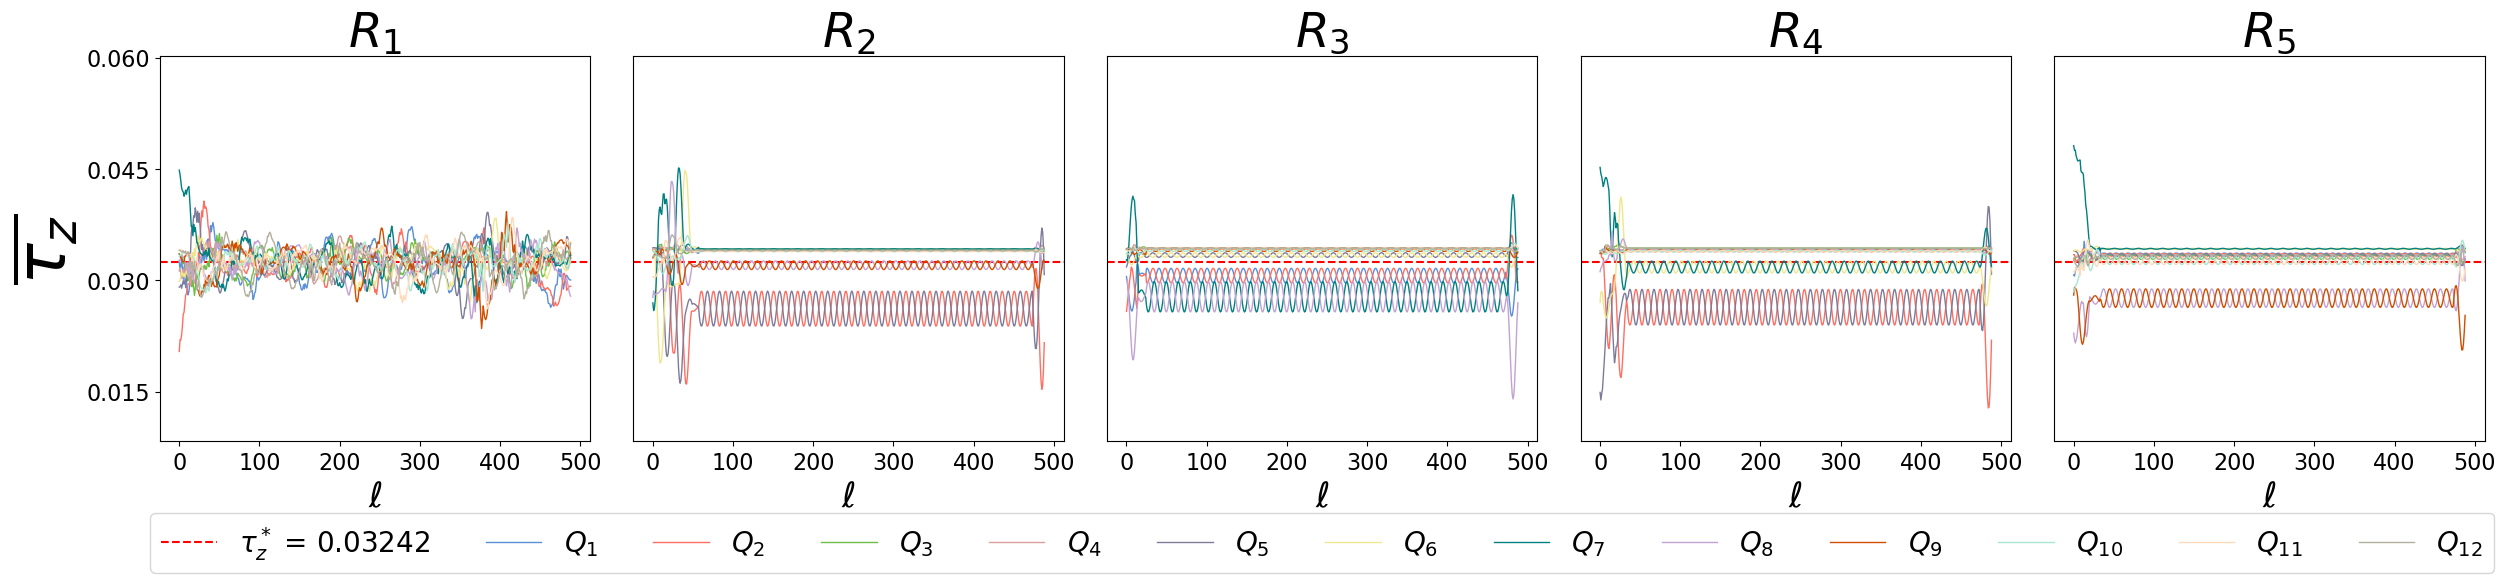

In [134]:
import matplotlib.gridspec as gridspec
def plot_connectivity_comparison(
    pops_dict, 
    seed=50, 
    denom=15, 
    ytherm12=(0.1*11+0.4)/12,  # Default value, adjust as needed
    colors=None,
    dataset_label="comparison",population_titles = ["$R_{1}$", "$R_{2}$", "$R_{3}$", "$R_{4}$", "$R_{5}$"]
):
    """
    Create a 2x5 grid of plots comparing C2 and C4 connectivity for different populations.
    
    Parameters:
    -----------
    pops_dict : dict
        Dictionary containing population data with keys:
        'time_averaged_c2', 'time_averaged_c4' - lists of 5 populations for time-averaged plots
        'ensemble_c2', 'ensemble_c4' - lists of 5 populations for ensemble-averaged plots
    seed : int
        Seed to use for time-averaged plots
    denom : int
        Denominator value for calculations
    ytherm10 : float
        Thermal value for reference line
    colors : list
        List of colors to use for plotting
    dataset_label : str
        Label to use in saved filenames
    """
    if colors is None:
        colors = ['#5B8FD8', '#FF6F61', '#6DBE45', '#D79F9D', '#7E7B9A','#F0E68C', '#008080', '#C2A2D2', '#D04E00', '#A8E6CF','#FFDAB9', '#B2B09C']
    
    # Create figure with GridSpec for better control
    fig = plt.figure(figsize=(30, 12))
    gs = gridspec.GridSpec(2, 5, figure=fig, wspace=0.1, hspace=0.4)
    
    # Row 1: Time-Averaged Plots for different populations (seed=50)
    row1_title = "Time-Averaged Plots (seed=50)"
    time_avg_pops_c2 = pops_dict['time_averaged_c2']
    time_avg_pops_c4 = pops_dict['time_averaged_c4']
    
    # Function to create time-averaged plot
    def create_time_averaged_plot(ax, pops, pop_idx, conn, title, y_global_min, y_global_max):
        data = time_averaged_one_point_measures_matrix_full_sim(tz_two_q_dyns_map(pops[pop_idx][seed], denom), 30)
        data = np.array(data[10:499])
        num_time_steps = len(data)
        t = np.arange(num_time_steps)
        data_transposed = data.T
        
        # Use the global min and max values for consistent y-axis scaling
        ax.set_ylim(y_global_min, y_global_max)
        
        # Set consistent number of y-axis ticks (e.g., 5 ticks)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        
        ax.axhline(y=(1-2*ytherm12)*(np.sin((np.pi)/denom))**2, color='r', linestyle='--', 
                  label=r'$\tau_z^*$'f' = {0.03242}')
        
        for i, y_values in enumerate(data_transposed):
            color = colors[i % len(colors)]
            ax.plot(t, y_values, label=f'$Q_{{{i+1}}}$', color=color, linewidth=1)

        if pop_idx == 0:
            ax.tick_params(axis='both', which='major', labelsize=14) 
        else:
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        ax.tick_params(axis='both',labelsize=16)
        
        ax.set_xlabel(r'$\ell$', fontsize=25)
        if pop_idx==0:
            ax.set_ylabel(r'$\overline{ \tau_{z}}$', fontsize=50)
        ax.set_title(f'{title}', fontsize=35)
        
        # Only add legend to the first plot in each row to save space
        if pop_idx == 2:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                     ncol=13, fontsize=20)
    
    # Main plotting code
    # First, determine global min/max across all datasets
    y_global_min = float('inf')
    y_global_max = float('-inf')
    
    for pop_idx in range(5):
        data = time_averaged_one_point_measures_matrix_full_sim(tz_two_q_dyns_map(time_avg_pops_c2[pop_idx][seed], denom), 30)
        data = np.array(data[10:499])
        curr_min = np.min(data)
        curr_max = np.max(data)
        
        # Add some padding as in your original code
        curr_min = curr_min - 0.35 * abs(curr_min)
        curr_max = curr_max + 0.25 * abs(curr_max)
        
        y_global_min = min(y_global_min, curr_min)
        y_global_max = max(y_global_max, curr_max)
    
    # Now create all plots with the same y-axis limits
    for pop_idx in range(5):
        ax1 = fig.add_subplot(gs[0, pop_idx])
        create_time_averaged_plot(ax1, time_avg_pops_c2, pop_idx, "C2", population_titles[pop_idx], 
                                 y_global_min, y_global_max)
    
    plt.savefig(f'tz_time_Averaged_comparison_c2_12)q_{dataset_label}.pdf', format='pdf', bbox_inches='tight')
    plt.show()
colors = ['#5B8FD8', '#FF6F61', '#6DBE45', '#D79F9D', '#7E7B9A','#F0E68C', '#008080', '#C2A2D2', '#D04E00', '#A8E6CF','#FFDAB9', '#B2B09C']

# Prepare your data dictionary
pops_dict = {
    # Time-averaged data (top row)
    'time_averaged_c2': [pops_random_c2_th, pops_greedy_c2_th, pops_landmax_c2_th, pops_strongmax_c2_th,pops_mimic_c2_th],
    'time_averaged_c4': [pops_random_c4_th, pops_greedy_c4_th, pops_landmax_c4_th, pops_strongmax_c4_th,pops_mimic_c4_th],
    
    # Ensemble-averaged data (bottom row)
    #'ensemble_c2':[pops_random_c2_th, pops_greedy_c2_th, pops_landscape_maximizes_c2_th, pops_strongest_maximizes_c2_th,pops_mimic_c2_th],
    #'ensemble_c4':[pops_random_c4_th, pops_greedy_c4_th, pops_landscape_maximizes_c4_th, pops_strongest_maximizes_c4_th,pops_mimic_c4_th]
    }

y_min=np.min([pops_random_c2_th, pops_greedy_c2_th, pops_landmax_c2_th, pops_strongmax_c2_th,pops_mimic_c2_th])
y_max = np.max([pops_random_c2_th, pops_greedy_c2_th, pops_landmax_c2_th, pops_strongmax_c2_th,pops_mimic_c2_th])
# Call the function with seed=50
plot_connectivity_comparison(
    pops_dict, 
    seed=35, 
    denom=15, 
    ytherm12=ytherm12,  # Adjust this value as needed
    colors=colors, 
    dataset_label="Tz_time_ens_avg_12_Q_th",population_titles = ["$R_{1}$", "$R_{2}$", "$R_{3}$", "$R_{4}$", "$R_{5}$"]
)


### 

In [109]:
(1-2*ytherm12)*(np.sin((np.pi)/denom))**2

np.float64(0.03242045338402466)

In [15]:
def full_sim_tz_NP(pops,denom):
    tz_per_trial_NP_cond = []
    for pop in pops:
        NP_list=[]
        for timestep in CPcond(abs_tz(pop, denom)):
            timesteplist = []
            for ele in timestep:
                if ele <= 1:
                    ele = 0
                timesteplist.append(ele)
            NP_list.append(timesteplist)
            np.array(NP_list)
        tz_per_trial_NP_cond.append(NP_list)
    return np.array(tz_per_trial_NP_cond)

def full_sim_tz_NP_prob(pops,denom):
    tz_per_trial_NP_cond = []
    for pop in pops:
        NP_list=[]
        for timestep in CPcond(abs_tz(pop, denom)):
            timesteplist = []
            for ele in timestep:
                if ele <= 1:
                    ele = 0
                if ele > 1:
                    ele = 1
                timesteplist.append(ele)
            NP_list.append(timesteplist)
            np.array(NP_list)
        tz_per_trial_NP_cond.append(NP_list)
    return np.array(tz_per_trial_NP_cond)



def full_sim_tz(pops,denom):
    tz_per_trial= []
    for pop in pops:
        tz_per_trial.append(tz_two_q_dyns_map(pop, denom))
    return np.array(tz_per_trial)
    
def plot_histograms_with_fits(datasets, time_range=(300, 499), figsize=(20, 15)):
    """
    Plot histograms with fit curves for multiple datasets.
    
    Parameters:
    -----------
    datasets : list
        List of datasets, each with shape (n_trials, n_timesteps, n_dimensions)
    time_range : tuple
        Range of time steps to include (start, end)
    figsize : tuple
        Figure size for the plot
    """
    n_datasets = len(datasets)
    start_time, end_time = time_range
    
    # Create figure
    fig, axes = plt.subplots(n_datasets, 1, figsize=figsize)
    
    # If only one dataset, make axes iterable
    if n_datasets == 1:
        axes = [axes]
    
    # Process each dataset
    for i, data in enumerate(datasets):
        n_trials, n_timesteps, n_dimensions = data.shape
        
        if n_dimensions != 12:
            raise ValueError(f"Dataset {i+1}: Expected 12 dimensions, but got {n_dimensions}")
        
        # Extract data for the specified time range
        time_slice = slice(start_time, end_time + 1)
        selected_data = data[:, time_slice, :]
        
        # Flatten the data for histogram
        flat_data = selected_data.reshape(-1)
        
        # Plot histogram on the corresponding subplot
        ax = axes[i]
        
        # Create histogram
        hist_values, bin_edges, _ = ax.hist(flat_data, bins=50, density=True, 
                                           alpha=0.6, color='skyblue', 
                                           label='Histogram')
        
        # Calculate bin centers for curve fitting
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Fit normal distribution
        mu, sigma = stats.norm.fit(flat_data)
        
        # Plot the fit curve
        x = np.linspace(np.min(flat_data), np.max(flat_data), 100)
        y = stats.norm.pdf(x, mu, sigma)
        ax.plot(x, y, 'r-', linewidth=2, label=f'Normal Fit: μ={mu:.3f}, σ={sigma:.3f}')
        
        # Calculate additional statistics
        median = np.median(flat_data)
        min_val = np.min(flat_data)
        max_val = np.max(flat_data)
        p25 = np.percentile(flat_data, 25)
        p75 = np.percentile(flat_data, 75)
        
        # Add text box with statistics
        stats_text = (f"Mean: {mu:.3f}\n"
                      f"Median: {median:.3f}\n"
                      f"Std Dev: {sigma:.3f}\n"
                      f"Min: {min_val:.3f}\n"
                      f"Max: {max_val:.3f}\n"
                      f"25th %: {p25:.3f}\n"
                      f"75th %: {p75:.3f}")
        
        # Add stats text box
        ax.text(0.95, 0.95, stats_text, 
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add vertical lines for mean and median
        ax.axvline(x=mu, color='red', linestyle='--', alpha=0.7)
        ax.axvline(x=median, color='green', linestyle='--', alpha=0.7)
        
        # Set titles and labels
        ax.set_title(f'Dataset {i+1}: Distribution (Time Steps {start_time}-{end_time})', fontsize=14)
        ax.set_xlabel('Value', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.legend(loc='upper left')
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return fig


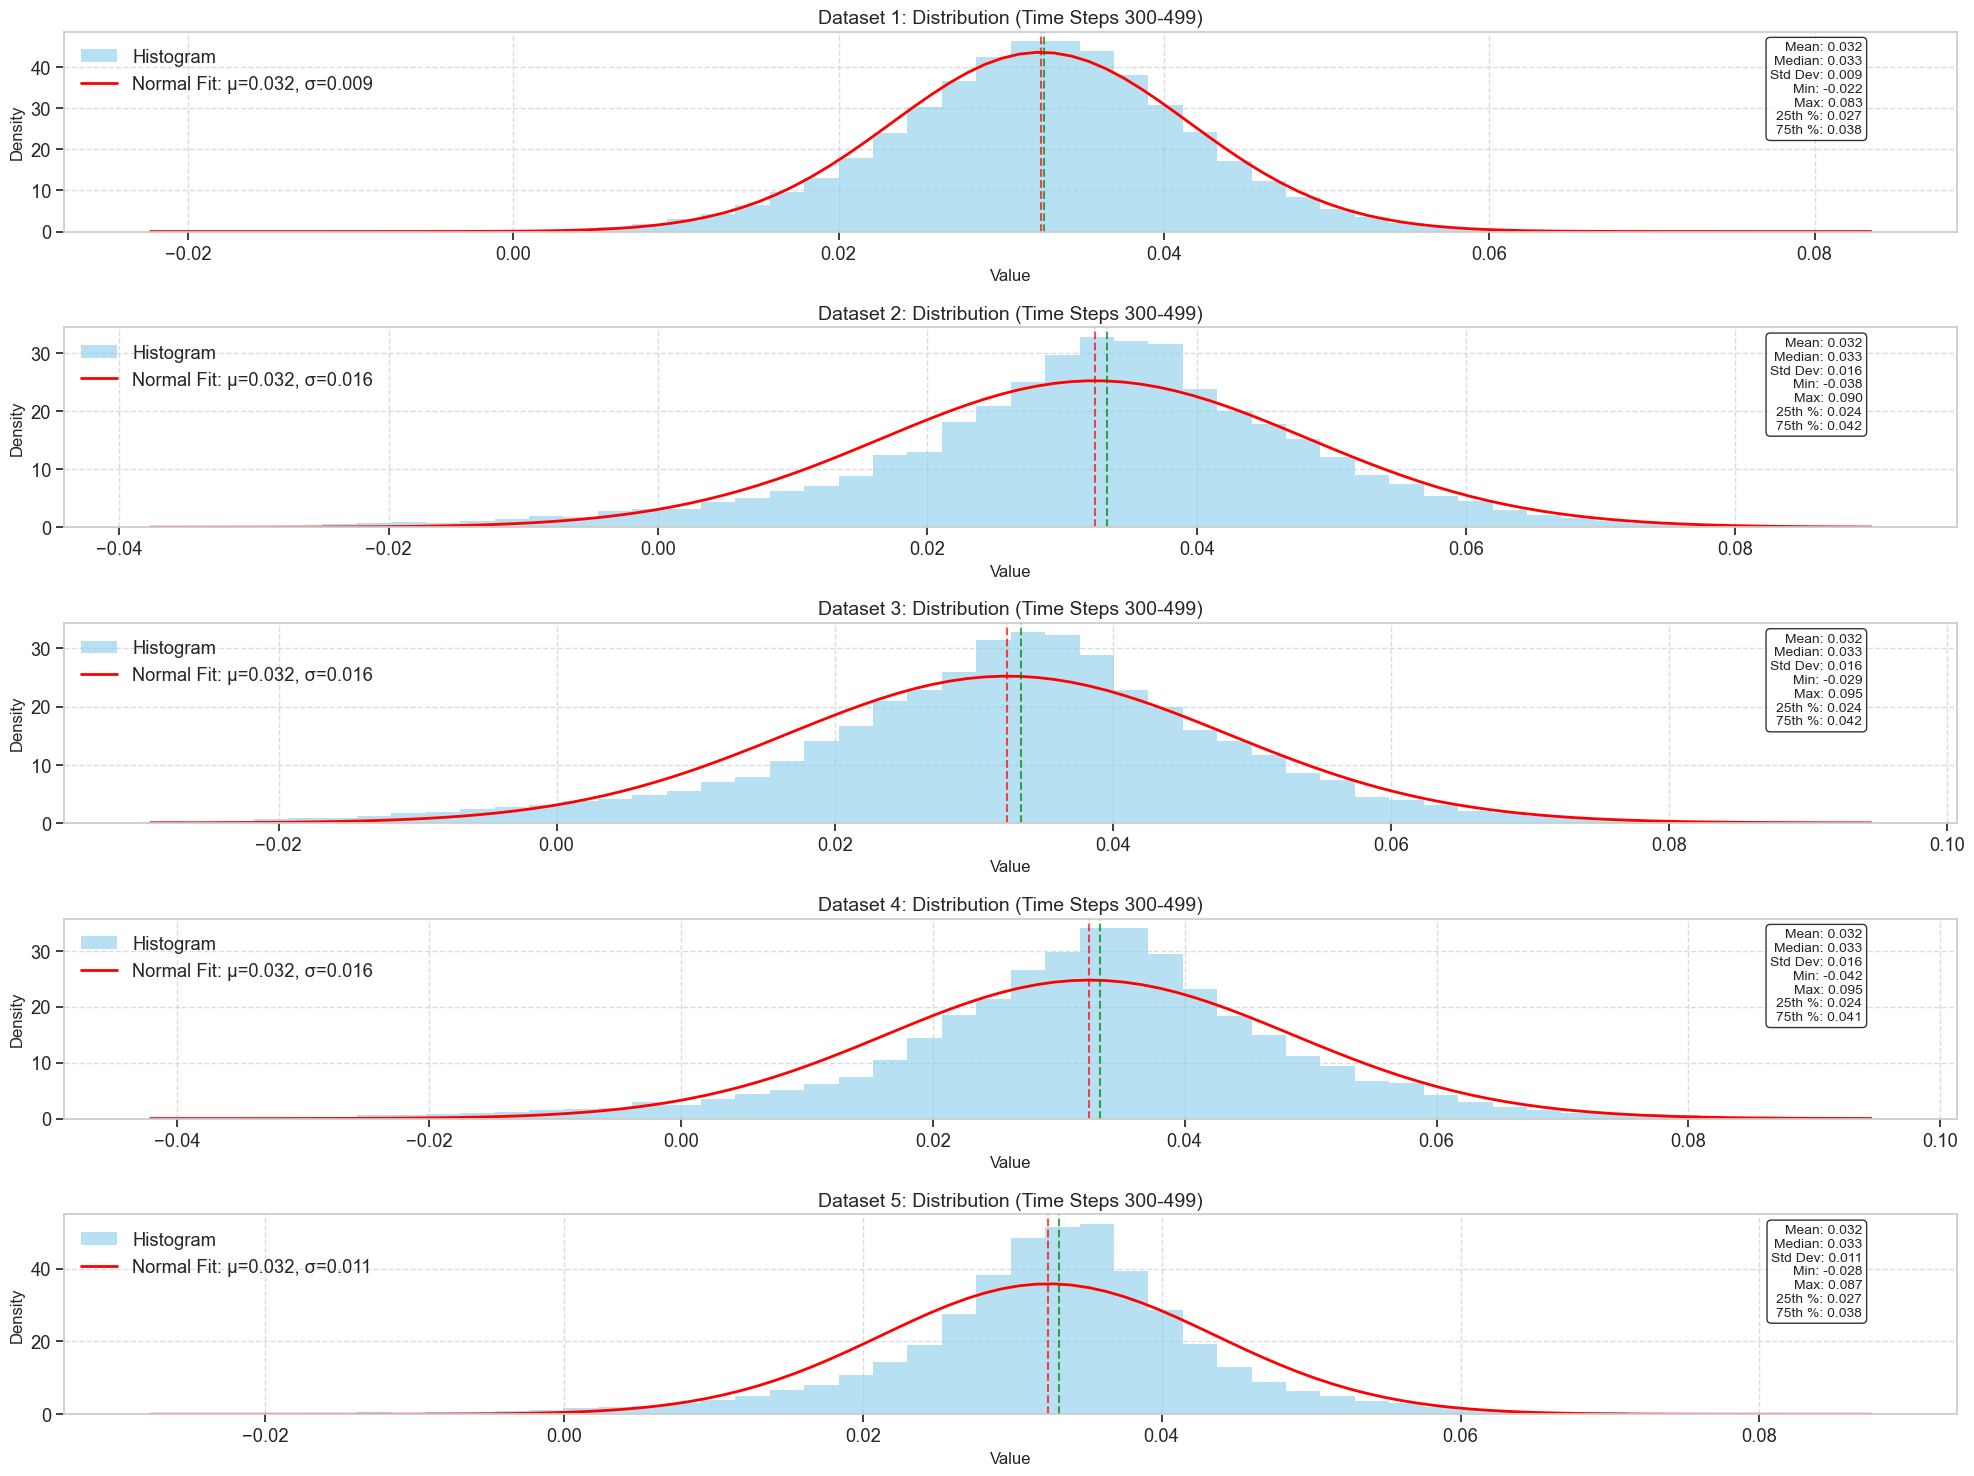

In [388]:
datasets = [full_sim_tz(pops_random_c2_v2,15),full_sim_tz(pops_greedy_c2_v2,15),full_sim_tz(pops_landmax_c2_v2,15),full_sim_tz(pops_strongmax_c2_v2,15),
           full_sim_tz(pops_mimic_c2_v2,15)]
fig = plot_histograms_with_fits(datasets)
plt.show()

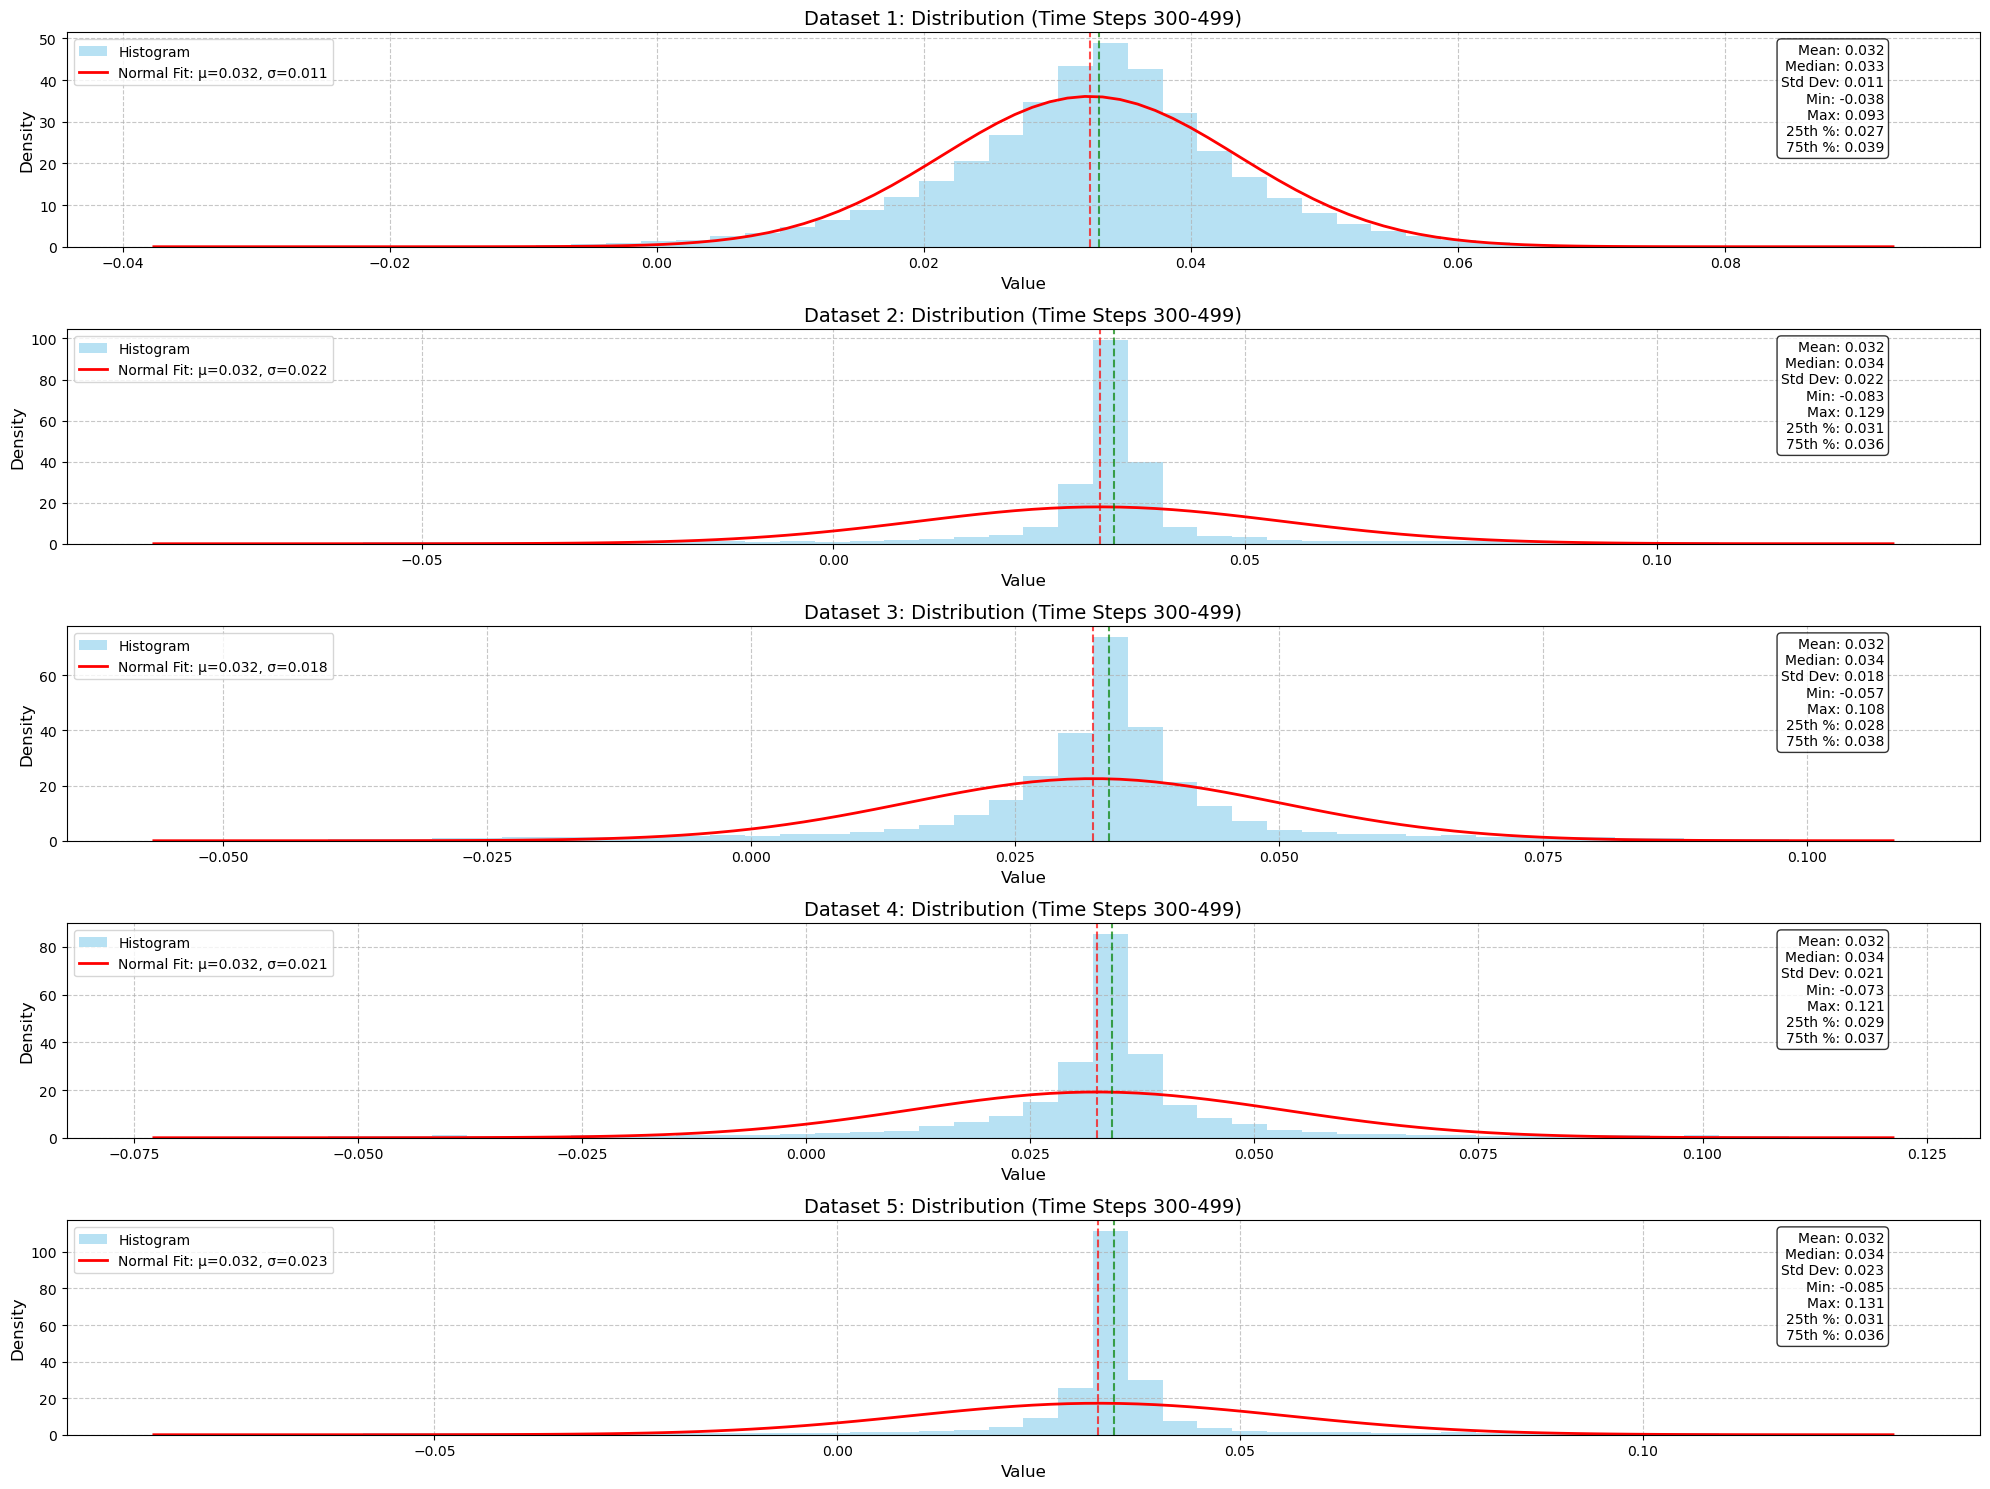

In [127]:
datasets = [full_sim_tz(pops_random_c2_th,15),full_sim_tz(pops_greedy_c2_th,15),full_sim_tz(pops_landmax_c2_th,15),full_sim_tz(pops_strongmax_c2_th,15),
           full_sim_tz(pops_mimic_c2_th,15)]
fig = plot_histograms_with_fits(datasets)
plt.show()

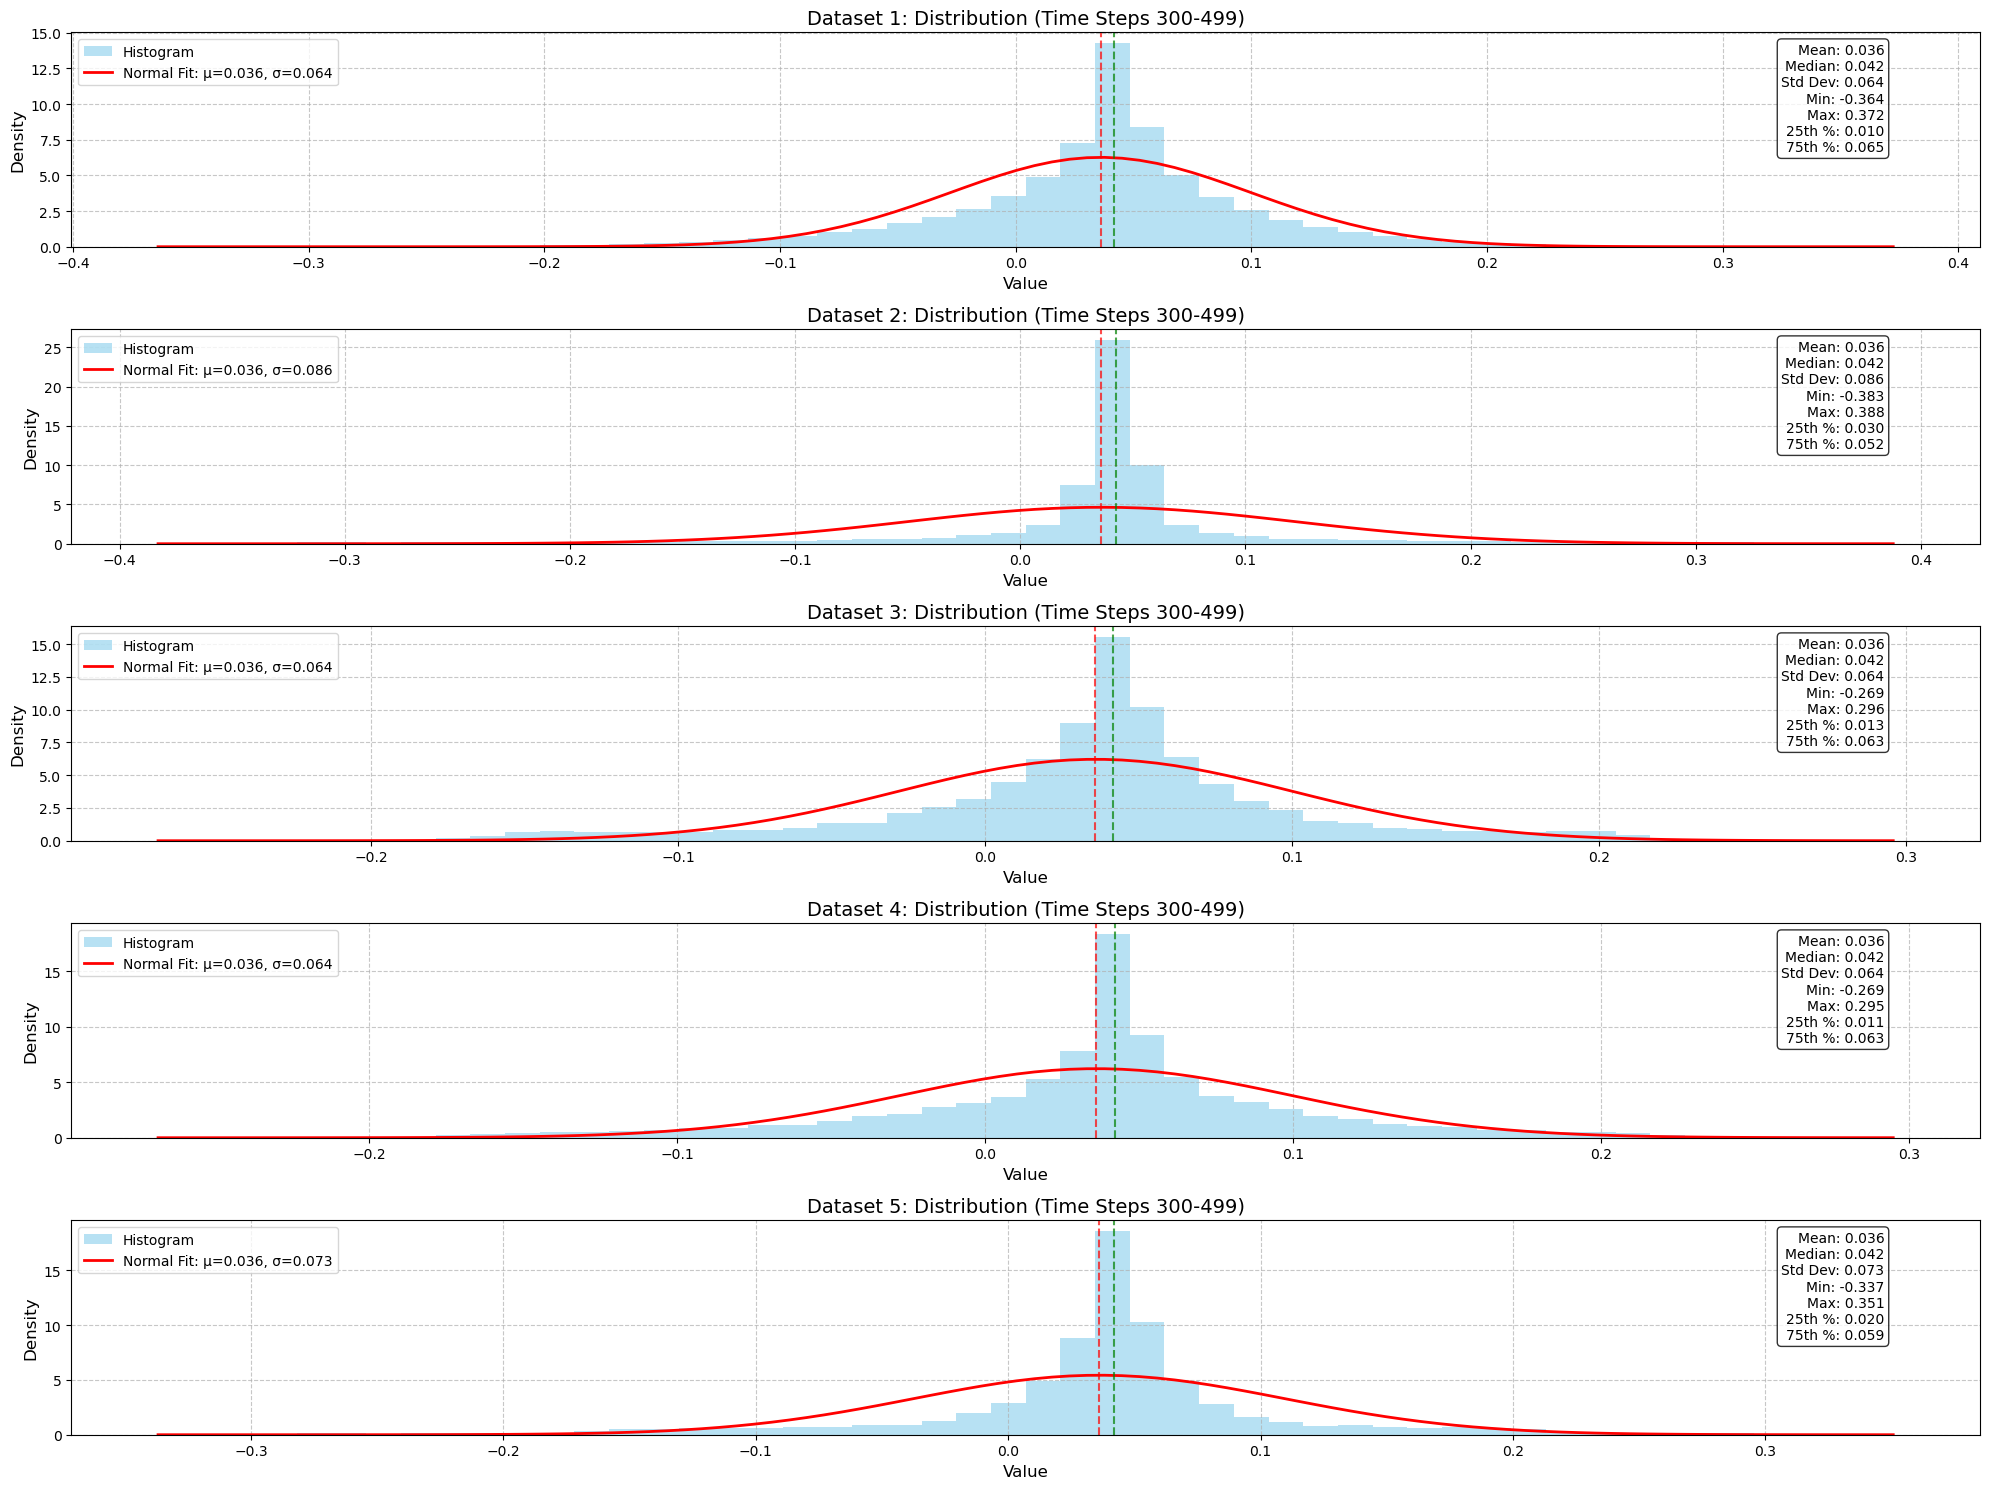

In [128]:
datasets = [full_sim_tz(pops_random_c2_pure,15),full_sim_tz(pops_greedy_c2_pure,15),full_sim_tz(pops_landmax_c2_pure,15),full_sim_tz(pops_strongmax_c2_pure,15),
           full_sim_tz(pops_mimic_c2_pure,15)]
fig = plot_histograms_with_fits(datasets)
plt.show()

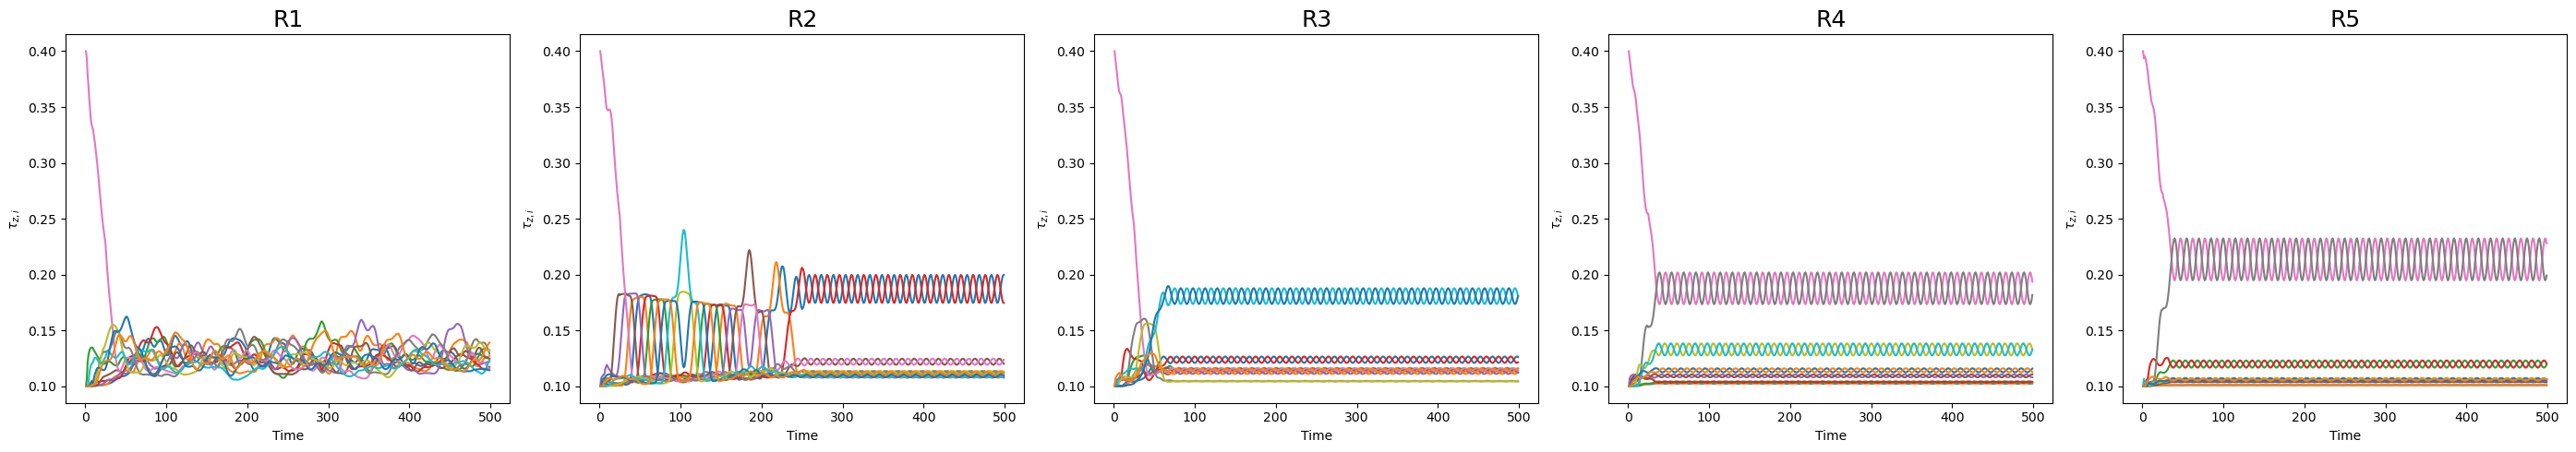

In [70]:
 n=19
datasets = [pops_random_c2_th[n], pops_greedy_c2_th[n], pops_landmax_c2_th[n], pops_strongmax_c2_th[n], pops_mimic_c2_th[n]]
fig = plot_multiple_datasets(datasets)
plt.show()

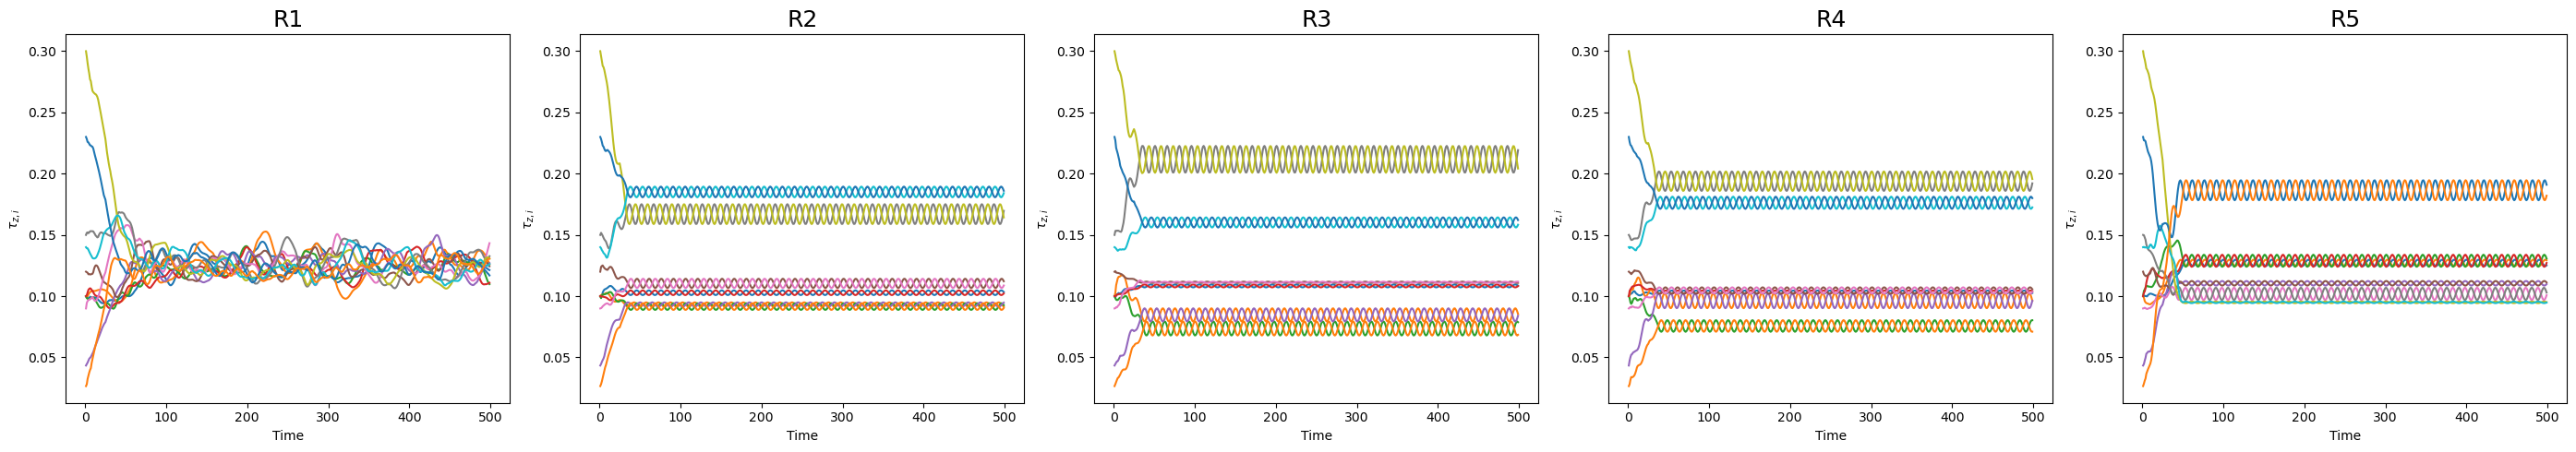

In [67]:
n=19
datasets = [pops_random_c2_v2[n], pops_greedy_c2_v2[n], pops_landmax_c2_v2[n], pops_strongmax_c2_v2[n], pops_mimic_c2_v2[n]]
fig = plot_multiple_datasets(datasets)
plt.show()

In [100]:
((1-np.cos(np.pi/15)*np.cos(np.pi/15))*(11*0.8 + 0.2))

np.float64(0.3890454406082946)

In [103]:
(1-2*ytherm12)*(np.sin((np.pi)/denom))**2

np.float64(0.03242045338402466)

In [120]:
#np.sum(full_sim_tz(pops_random_c2_th,15)[1],axis=1)

for timestep in pops_random_c2_th[1]:
    pop_at_t=[]
    for p in timestep:
        pop_at_t.append(1-2*p)
    print(np.sum(pop_at_t)*(1-np.cos(np.pi/15)*np.cos(np.pi/15)))


0.3890454406082946
0.3890454818330329
0.3890454406082946
0.3890454406082946
0.389045358158818
0.389045358158818
0.38904531693407973
0.389045358158818
0.38904531693407973
0.38904531693407973
0.38904527570934144
0.38904523448460315
0.38904527570934144
0.38904519325986486
0.38904519325986486
0.38904519325986486
0.38904519325986486
0.3890451520351266
0.38904519325986486
0.3890451520351266
0.3890451108103883
0.3890451108103883
0.3890451108103883
0.3890451108103883
0.38904506958565
0.3890450283609117
0.3890450283609117
0.3890450283609117
0.3890450283609117
0.3890449871361734
0.3890449459114351
0.3890449871361734
0.3890449459114351
0.3890449459114351
0.38904490468669684
0.38904490468669684
0.38904486346195855
0.38904486346195855
0.38904486346195855
0.38904482223722026
0.38904482223722026
0.3890447810124819
0.3890447810124819
0.3890447810124819
0.3890447397877436
0.3890447810124819
0.3890447397877436
0.38904469856300533
0.38904469856300533
0.38904469856300533
0.38904465733826704
0.389044616113

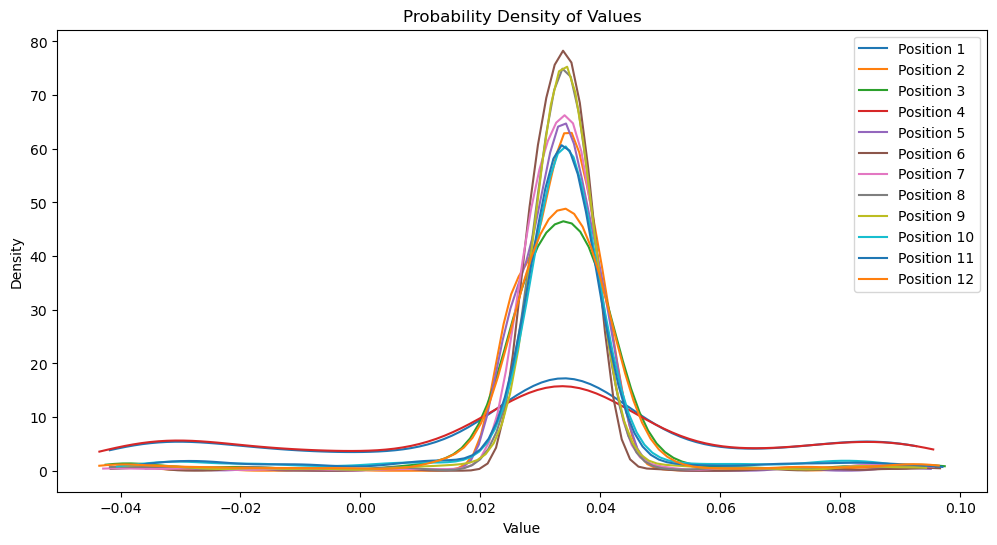

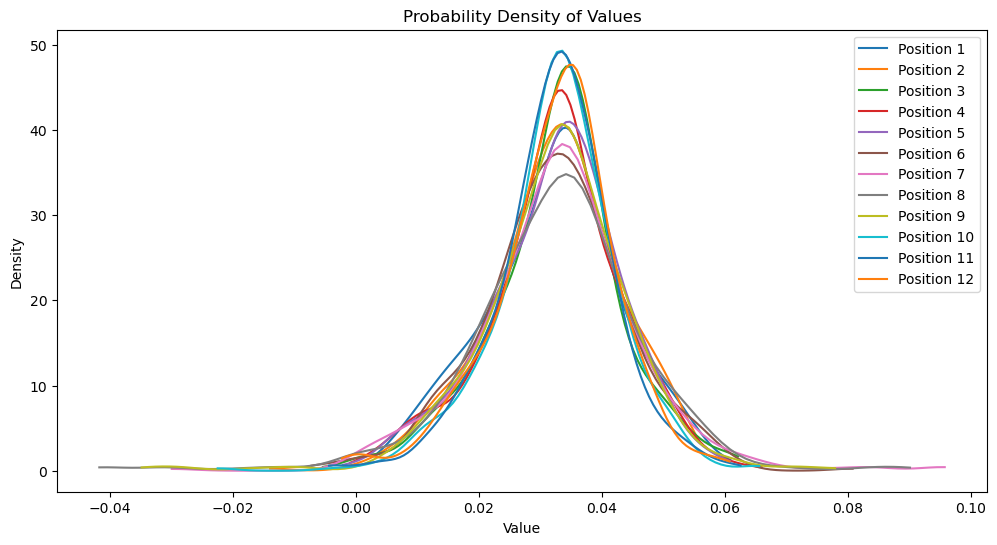

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming data is a numpy array with shape (num_timesteps, 12)
# Where each row is a time step and each column is one of the 12 positions

# 1. Probability Density Estimation
def plot_density(data):
    plt.figure(figsize=(12, 6))
    for i in range(data.shape[1]):
        position_values = data[:, i]
        kde = gaussian_kde(position_values)
        x = np.linspace(min(position_values), max(position_values), 100)
        plt.plot(x, kde(x), label=f'Position {i+1}')
    plt.title('Probability Density of Values')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# 2. Autocorrelation Function
def plot_acf(data, max_lag=20):
    plt.figure(figsize=(12, 6))
    for i in range(data.shape[1]):
        position_values = data[:, i]
        # Normalize the series
        series = (position_values - np.mean(position_values)) / np.std(position_values)
        # Calculate autocorrelation
        acf = np.correlate(series, series, mode='full')
        # Take only the positive lags and normalize
        acf = acf[len(acf)//2:len(acf)//2+max_lag+1] / acf[len(acf)//2]
        plt.plot(range(len(acf)), acf, label=f'Position {i+1}')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Autocorrelation Function')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.legend()
    plt.show()

# 3. Phase Space Plots
def plot_phase_space(data):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    for i in range(data.shape[1]):
        position_values = data[:, i]
        axes[i].scatter(position_values[:-1], position_values[1:], alpha=0.5)
        axes[i].set_title(f'Position {i+1}')
        axes[i].set_xlabel('Value at t')
        axes[i].set_ylabel('Value at t+1')
        axes[i].plot([min(position_values), max(position_values)], 
                     [min(position_values), max(position_values)], 'r--')
    plt.tight_layout()
    plt.show()

random_data = np.array(tz_two_q_dyns_map(pops_random_c2_th[2],15))
nonrandom_data = np.array(tz_two_q_dyns_map(pops_mimic_c2_th[13],15))
plot_density(nonrandom_data)
plot_density(random_data)

/var/folders/58/gxcqk5bd4055b6n0b6yszvlw0000gn/T/ipykernel_64421/232795664.py:419: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = axes[i].legend(title=f'CS{i+1}(R2)', fontsize=35)
/var/folders/58/gxcqk5bd4055b6n0b6yszvlw0000gn/T/ipykernel_64421/232795664.py:421: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = axes[i].legend(title=f'CSP(R2)', fontsize=35)


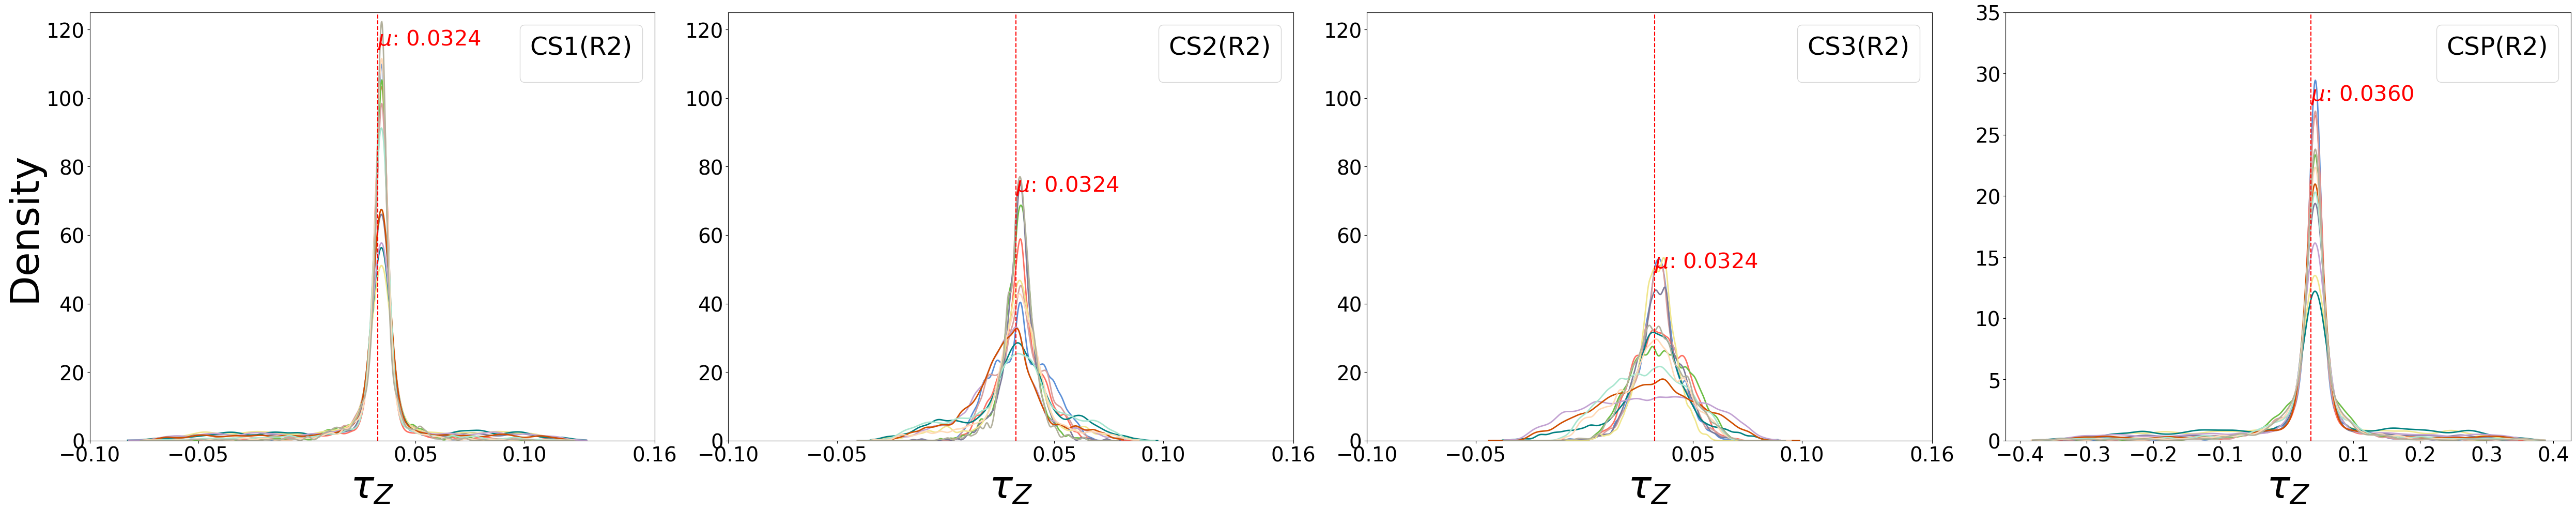

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

# Assuming data is a numpy array with shape (500, 100, 12)
# Where:
# - 500 datasets
# - 100 trials per dataset
# - 12 positions per trial

def plot_aggregate_density(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set up colors
    colors =['#5B8FD8', '#FF6F61', '#6DBE45', '#D79F9D', '#7E7B9A','#F0E68C', '#008080', '#C2A2D2', '#D04E00', '#A8E6CF','#FFDAB9', '#B2B09C']
    
    # For each position
    for pos in range(12):
        # Collect all values for this position across all datasets and trials
        all_position_values = data[:, :, pos].flatten()
        
        # Calculate the KDE
        x = np.linspace(np.min(all_position_values), np.max(all_position_values), 1000)
        kde = gaussian_kde(all_position_values)
        
        # Plot the density on the provided axis
        ax.plot(x, kde(x), color=colors[pos], linewidth=2)
        
        # Optional: Add a small rug plot to show actual data distribution
        #ax.plot(all_position_values, np.zeros_like(all_position_values) - 0.005 * (pos+1), 
        #        '|', color=colors[pos], alpha=1, markersize=5)

        ax.tick_params(axis='both',labelsize=28)
    
    # Add visual enhancements
    #ax.set_title('Aggregate Probability Density of Values Across All Datasets and Trials', fontsize=16)
    ax.set_xlabel(r'$\tau_Z$', fontsize=54)
    ax.set_ylabel('Density', fontsize=55)
    
    # Add mean line
    if data.sum() / (data.size) != 0:
        mean_value = data.mean()
        ax.axvline(x=mean_value, color='red', linestyle='--')
        ax.text(mean_value, ax.get_ylim()[1]*0.9, r'$\mu$'f': {mean_value:.4f}', 
               color='red', fontsize=30)
    
    return ax

# Alternative version to see if there are natural clusters of datasets
def plot_dataset_clusters(data):
    plt.figure(figsize=(16, 10))
    
    # We'll use a subset of datasets for clarity (e.g., first 50)
    num_datasets_to_plot = min(50, data.shape[0])
    
    # For each position
    for pos in range(12):
        plt.subplot(3, 4, pos+1)
        
        # For selected datasets
        for d in range(num_datasets_to_plot):
            # Get position values for this dataset across all trials
            position_values = data[d, :, pos]
            
            # Plot a small KDE for this dataset
            try:
                sns.kdeplot(position_values, alpha=0.3)
            except:
                # Fallback if KDE fails
                plt.hist(position_values, alpha=1, bins=20, density=True)
        
        plt.title(f'Position {pos+1}')
        plt.xlabel('Value')
        plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

def plot_average_density(data):
    plt.figure(figsize=(14, 8))
    
    # Calculate average values for each position across datasets
    # Shape: (100, 12) - average time series for each position
    average_data = data.mean(axis=0)
    
    for pos in range(12):
        position_values = average_data[:, pos]
        kde = gaussian_kde(position_values)
        x = np.linspace(min(position_values), max(position_values), 100)
        plt.plot(x, kde(x), label=f'Position {pos+1}')
    
    plt.title('Average Probability Density Across Datasets')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm

def plot_multiple_datasets_two_figures(datasets, labels=None, 
                                      fig_width_per_col=10, fig_height_per_row=6,
                                      uniform_x_axis=True, uniform_y_axis=False):
    """
    Plot distributions for multiple datasets in two separate figures.
    Figure 1: Th and Pure variants
    Figure 2: V1 and V2 variantsF
    
    Parameters:
    -----------
    datasets : list of numpy arrays
        List of 20 datasets in the order:
        [Random-Th, Greedy-Th, Landmax-Th, Strongmax-Th, Mimic-Th,
         Random-V1, Greedy-V1, Landmax-V1, Strongmax-V1, Mimic-V1,
         Random-V2, Greedy-V2, Landmax-V2, Strongmax-V2, Mimic-V2,
         Random-Pure, Greedy-Pure, Landmax-Pure, Strongmax-Pure, Mimic-Pure]
    labels : list of strings or None
        Labels for each dataset. If None, default labels will be used.
    fig_width_per_col : float
        Width of each column in inches
    fig_height_per_row : float
        Height of each row in inches
    uniform_x_axis : bool
        If True, use the same x-axis limits for all plots. If False, each plot uses its own limits.
    uniform_y_axis : bool
        If True, use the same y-axis limits for all plots. If False, each plot uses its own limits.
    """
    # Create default labels if none provided
# Create default labels if none provided
    if labels is None:
        # If your dataset is organized with algorithm first, variant second:
        algorithms = ["R1", "R2", "R3", "R4", "R5"]
        variants = ["CS1", "CS2", "CS3","CSP"]
        
        labels = []
        # For all variants
        for variant_idx, variant in enumerate(variants):
            # For all algorithms
            for alg_idx, alg in enumerate(algorithms):
                labels.append(f"{variant} - {alg}")

    # Verify we have the correct number of datasets
    if len(datasets) != 20:
        raise ValueError(f"Expected 20 datasets, but got {len(datasets)}")
        
    # Organize datasets by variant type
    th_datasets = [(datasets[i], labels[i], i) for i in range(0, 5)]         # First 5 datasets: Th variants
    v1_datasets = [(datasets[i], labels[i], i) for i in range(5, 10)]        # Next 5 datasets: V1 variants
    v2_datasets = [(datasets[i], labels[i], i) for i in range(10, 15)]       # Next 5 datasets: V2 variants
    pure_datasets = [(datasets[i], labels[i], i) for i in range(15, 20)]     # Last 5 datasets: Pure variants
    
    # Create data for two figures
    figure1_data = th_datasets + pure_datasets  # Figure 1: Th and Pure variants
    figure2_data = v1_datasets + v2_datasets    # Figure 2: V1 and V2 variants
    
    # Number of rows and columns for each figure
    num_rows = 5  # 5 algorithm types
    num_cols = 2  # 2 variants per figure
    
    # Set up colors for the 12 positions
    colors = plt.cm.viridis(np.linspace(0, 1, 12))
    
    # Calculate global statistics for all datasets
    all_means = []
    all_stds = []
    global_min = float('inf')
    global_max = float('-inf')
    global_max_density = 0
    
    # Process all datasets to calculate statistics
    for dataset in datasets:
        # Reshape data
        num_trials = dataset.shape[0]
        num_timesteps = dataset.shape[1]
        all_timestep_values = dataset.reshape(num_trials * num_timesteps, 12)
        
        # Update global min and max
        dataset_min = np.min(all_timestep_values)
        dataset_max = np.max(all_timestep_values)
        global_min = min(global_min, dataset_min)
        global_max = max(global_max, dataset_max)
        
        # Calculate system statistics
        all_values = all_timestep_values.flatten()
        system_mean = np.mean(all_values)
        system_std = np.std(all_values)
        
        # Store statistics for each dataset
        all_means.append(system_mean)
        all_stds.append(system_std)
    
    # Add padding to the global range
    padding = (global_max - global_min) * 0.1
    global_min -= padding
    global_max += padding
    
    # Create common x-axis range for all plots if uniform_x_axis is True
    x_global = np.linspace(global_min, global_max, 500)
    
    # Calculate total figure size
    fig_width = fig_width_per_col * num_cols
    fig_height = fig_height_per_row * num_rows
    
    # Create two figures with datasets and labels
    figure_data = [
        (figure1_data, "CS1 and CSP Variants", "distribution_fig_1.png"),
        (figure2_data, "CS2 and CS3 Variants", "distribution_fig_2.png")
    ]
    
    # To store max density values if needed for uniform y-axis
    max_densities = []
    
    # First pass to calculate density values if uniform_y_axis is True
    if uniform_y_axis:
        for fig_data, _, _ in figure_data:
            for dataset, _, _ in fig_data:
                num_trials = dataset.shape[0]
                num_timesteps = dataset.shape[1]
                all_timestep_values = dataset.reshape(num_trials * num_timesteps, 12)
                
                for pos in range(12):
                    position_values = all_timestep_values[:, pos]
                    try:
                        kde = gaussian_kde(position_values, bw_method='scott')
                        x = x_global if uniform_x_axis else np.linspace(np.min(position_values) - padding, 
                                                                       np.max(position_values) + padding, 500)
                        density = kde(x)
                        max_densities.append(np.max(density))
                    except Exception:
                        pass
        
        global_max_density = max(max_densities) if max_densities else 1.0
    
    # Create two figures
    for fig_idx, (fig_data, fig_title, filename) in enumerate(figure_data):
        # Create figure
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
        
        # Process each cell in the grid
        for i in range(num_rows):
            for j in range(num_cols):
                # Get dataset index in the current figure
                grid_idx = i + j * num_rows  # Column-major order
                
                # Check if we have data for this grid cell
                if grid_idx < len(fig_data):
                    dataset, label, original_idx = fig_data[grid_idx]
                else:
                    continue
                    
                # Get axis for this subplot
                ax = axes[i, j]
                
                # Reshape data
                num_trials = dataset.shape[0]
                num_timesteps = dataset.shape[1]
                all_timestep_values = dataset.reshape(num_trials * num_timesteps, 12)
                
                # Get statistics for this dataset
                system_mean = all_means[original_idx]
                system_std = all_stds[original_idx]
                
                # Determine local min and max if not using uniform x-axis
                if not uniform_x_axis:
                    local_min = np.min(all_timestep_values) - padding
                    local_max = np.max(all_timestep_values) + padding
                    x = np.linspace(local_min, local_max, 500)
                else:
                    x = x_global
                
                # Plot the mean line
                ax.axvline(x=system_mean, color='red', linewidth=2, label='Mean')
                
                # Store local max density for this subplot
                subplot_max_density = 0
                
                # Plot KDE for each of the 12 positions
                for pos in range(12):
                    # Get values for this position
                    position_values = all_timestep_values[:, pos]
                    
                    try:
                        # Calculate KDE with explicit bandwidth selection
                        kde = gaussian_kde(position_values, bw_method='scott')
                        density = kde(x)
                        
                        # Update max density for this subplot
                        subplot_max_density = max(subplot_max_density, np.max(density))
                        
                        # Plot the density curve
                        ax.plot(x, density, color=colors[pos], linewidth=1, alpha=1)
                    except Exception as e:
                        print(f"Warning: Failed to create KDE for position {pos} in dataset {original_idx}: {e}")
                        # Fallback to histogram if KDE fails
                        try:
                            counts, bins = np.histogram(position_values, bins=20, density=True)
                            bin_centers = 0.5 * (bins[1:] + bins[:-1])
                            ax.bar(bin_centers, counts, width=bins[1]-bins[0], color=colors[pos], alpha=0.3)
                        except Exception as hist_e:
                            print(f"  Histogram fallback also failed: {hist_e}")
                
                # Add title and stats
                ax.set_title(f'{label}')
                #\nμ={system_mean:.2f}, σ={system_std:.2f}')
                
                # Set x-axis limits based on option
                if uniform_x_axis:
                    ax.set_xlim(global_min, global_max)
                else:
                    ax.set_xlim(local_min, local_max)
                
                # Set y-axis limits based on option
                if uniform_y_axis and global_max_density > 0:
                    ax.set_ylim(0, global_max_density * 1.1)
                elif subplot_max_density > 0:
                    ax.set_ylim(0, subplot_max_density * 1.1)
                
                # Manage axis labels - show all labels if non-uniform axes, otherwise only on edges
                if not uniform_x_axis or not uniform_y_axis:
                    # Show all axis labels when using individual scales
                    ax.set_ylabel('Density')
                    ax.set_xlabel('Value')
                else:
                    # For uniform axes, only show labels on edges
                    if j == 0:  # First column
                        ax.set_ylabel('Density')
                    else:
                        ax.set_ylabel('')
                        ax.tick_params(labelleft=False)  # Remove y-axis tick labels
                        
                    if i == num_rows - 1:  # Last row
                        ax.set_xlabel('Value')
                    else:
                        ax.set_xlabel('')
                        ax.tick_params(labelbottom=False)  # Remove x-axis tick labels
                
                # Add y=0 horizontal line
                ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
                
                # Add vertical line at x=0 if the range includes 0
                if (uniform_x_axis and global_min <= 0 <= global_max) or \
                   (not uniform_x_axis and local_min <= 0 <= local_max):
                    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Create a legend in a separate figure area
        fig.subplots_adjust(bottom=0.1)
        legend_ax = fig.add_axes([0.15, 0.02, 0.7, 0.03])
        legend_ax.axis('off')
        
        # Add dummy plots for legend
        for pos in range(12):
            legend_ax.plot([], [], color=colors[pos], linewidth=2, label=f'q{pos+1}')
        legend_ax.plot([], [], 'r-', linewidth=2, label='Mean')
        
        # Create the legend
        legend = legend_ax.legend(loc='center', ncol=13, frameon=True)
        
        # Add super title
        #scale_note = "Uniform x-axis" if uniform_x_axis else "Individual x-axes"
        #scale_note += ", Uniform y-axis" if uniform_y_axis else ", Individual y-axes"
        
        #plt.suptitle(f'Distribution of 12 Values - {fig_title}\n({scale_note})',
                     #fontsize=16, y=0.98)
        
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        
        # Save the figure
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        
        # Show the figure
        plt.show()
    
    # Print comparison of datasets
    #print("\nDataset Comparison:")
    #for i, (mean, std) in enumerate(zip(all_means, all_stds)):
    #    if i < len(labels):
            #print(f"{labels[i]}: Mean = {mean:.4f}, Std = {std:.4f}")
    
    #print(f"\nAverage across all datasets: Mean = {np.mean(all_means):.4f}, Std = {np.mean(all_stds):.4f}")
    #print(f"Global value range: [{global_min:.4f}, {global_max:.4f}]")

 
#plot_aggregate_density(full_sim_tz(pops_greedy_c2_th,15))
#plot_aggregate_density(full_sim_tz(pops_landmax_c2_th,15))
#plot_aggregate_density(full_sim_tz(pops_strongmax_c2_th,15))
#plot_aggregate_density(full_sim_tz(pops_mimic_c2_th,15))
#plot_aggregate_density(full_sim_tz(pops_random_c2_th,15))


def plot_multiple_densities(data, num_plots=4):
    """
    Plot multiple density plots stacked vertically.
    
    Parameters:
    - data: The data to plot (output from full_sim_tz function)
    - num_plots: Number of plots to create (default: 4)
    """
    # Create a figure with subplots arranged vertically
    fig, axes = plt.subplots(1, num_plots, figsize=(50, 10))
    
    # If there's only one plot, axes won't be an array
    if num_plots == 1:
        axes = [axes]
    
    # Plot each density plot in its own subplot
    for i in range(num_plots):
        # Assuming plot_aggregate_density function accepts an axis to plot on
        plot_aggregate_density(data[i], ax=axes[i])
        
        # Create legend with larger font size for both text and title
        if i<3:
            leg = axes[i].legend(title=f'CS{i+1}(R2)', fontsize=35)
        if i==3:
            leg = axes[i].legend(title=f'CSP(R2)', fontsize=35)
        leg.get_title().set_fontsize(35)  # Set the title font size separately
        if i < 3:
            axes[i].set_ylim(0,125)
            axes[i].set_xlim(-0.1,0.16)
            axes[i].set_xticks([-0.1, -0.05, 0.05, 0.1, 0.16])
        if i==3:
            axes[i].set_ylim(0,35)
        if i > 0:
            axes[i].set_ylabel('')
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    return fig

# Example usage:
# Assuming pops_random_c2_th is already defined
data = [full_sim_tz(pops_greedy_c2_th, 15),full_sim_tz(pops_greedy_c2_v1, 15),full_sim_tz(pops_greedy_c2_v2, 15),
        full_sim_tz(pops_greedy_c2_pure, 15)]
fig = plot_multiple_densities(data)
plt.savefig("Tz_per_Q_12_Q.png",dpi=300,bbox_inches='tight')
plt.show()

In [114]:
np.mean(full_sim_tz(pops_greedy_c2_v1, 15))

np.float64(0.03242010088344563)

In [101]:
#plot_aggregate_density(full_sim_tz(pops_random_c2_v1,15))
#plot_aggregate_density(full_sim_tz(pops_greedy_c2_v1,15))
##plot_aggregate_density(full_sim_tz(pops_landmax_c2_v1,15))
##plot_aggregate_density(full_sim_tz(pops_strongmax_c2_v1,15))
#plot_aggregate_density(full_sim_tz(pops_mimic_c2_v1,15))
(11*0.1+0.4)/12

0.125

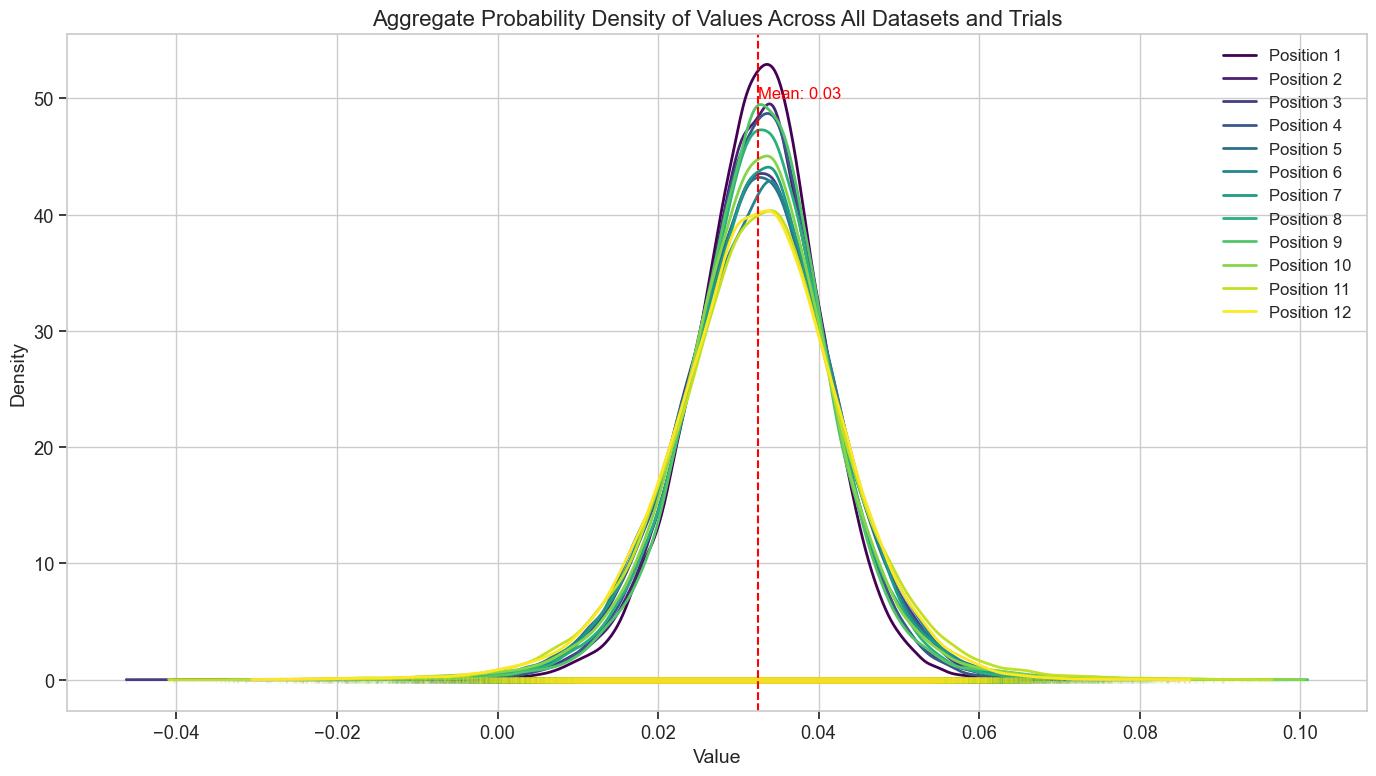

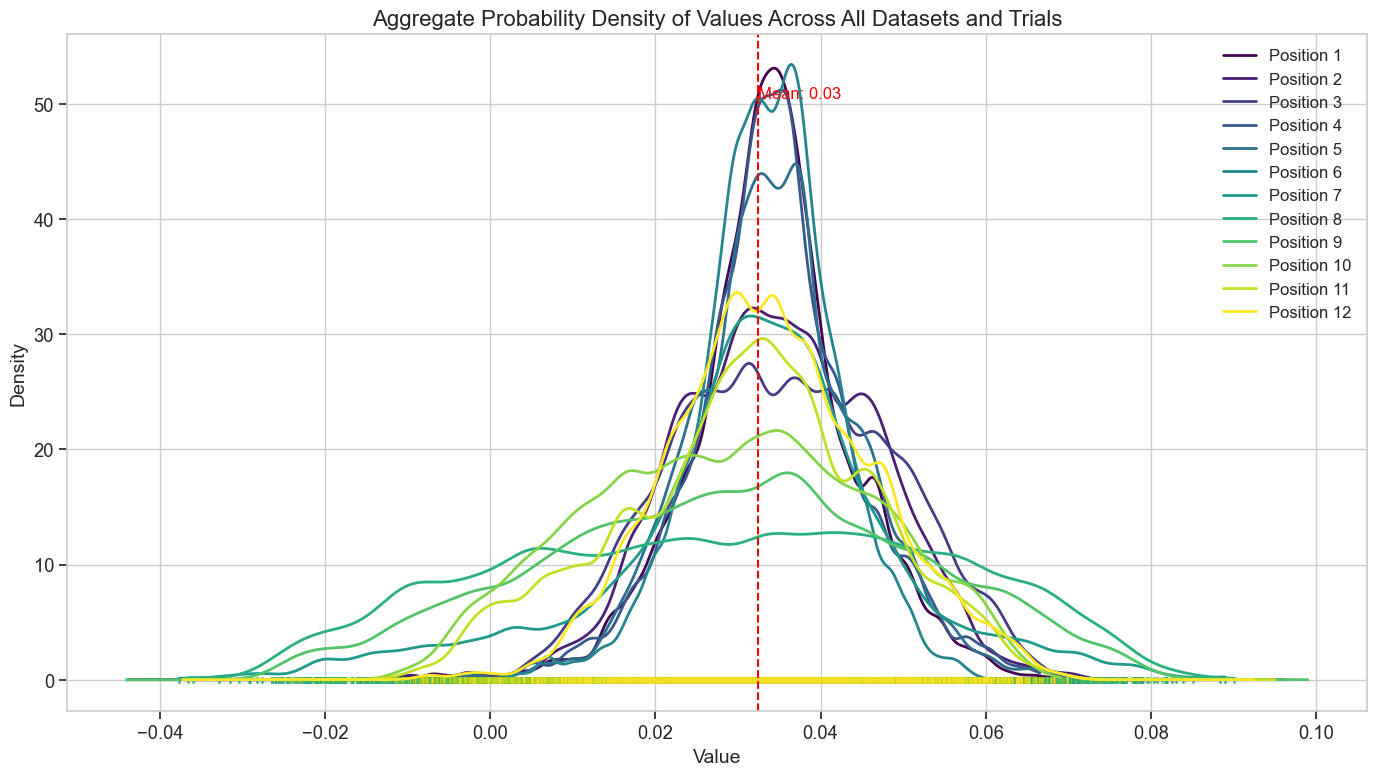

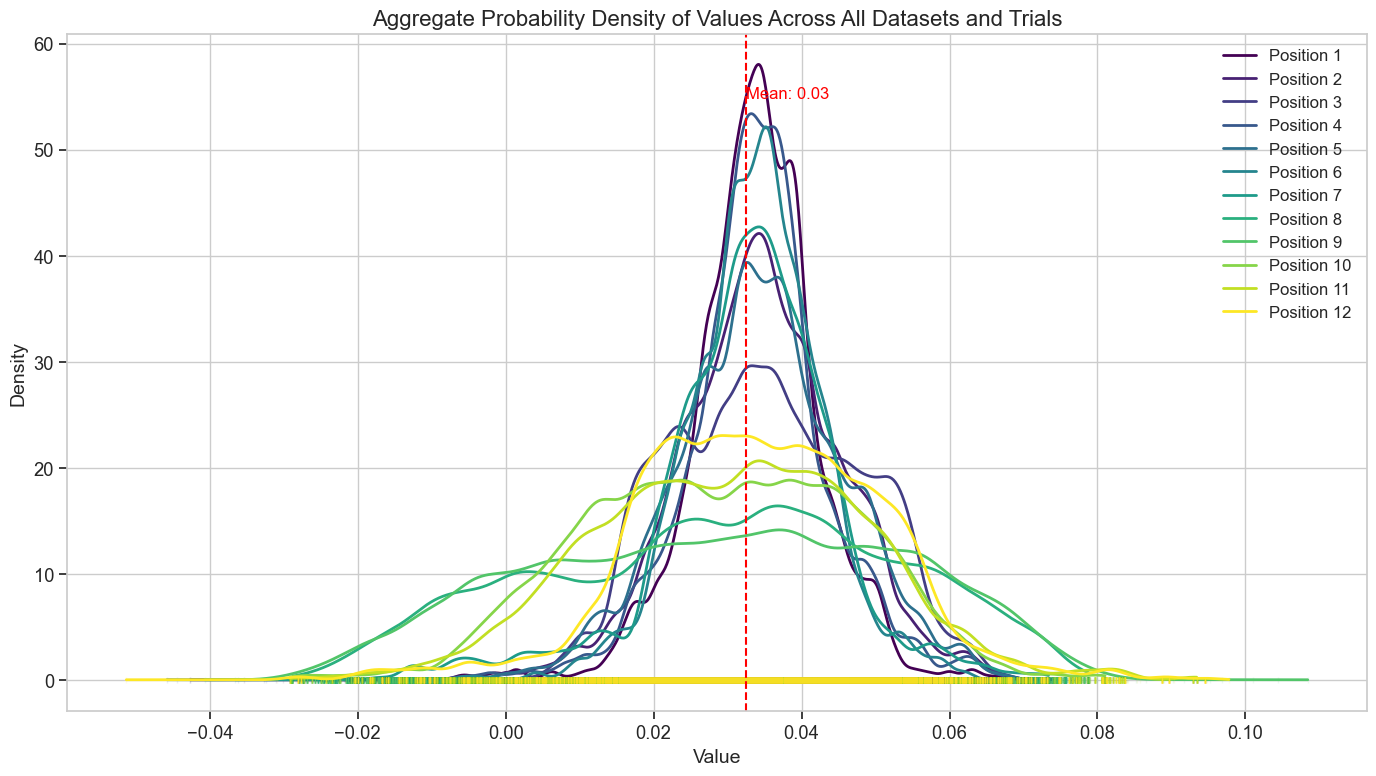

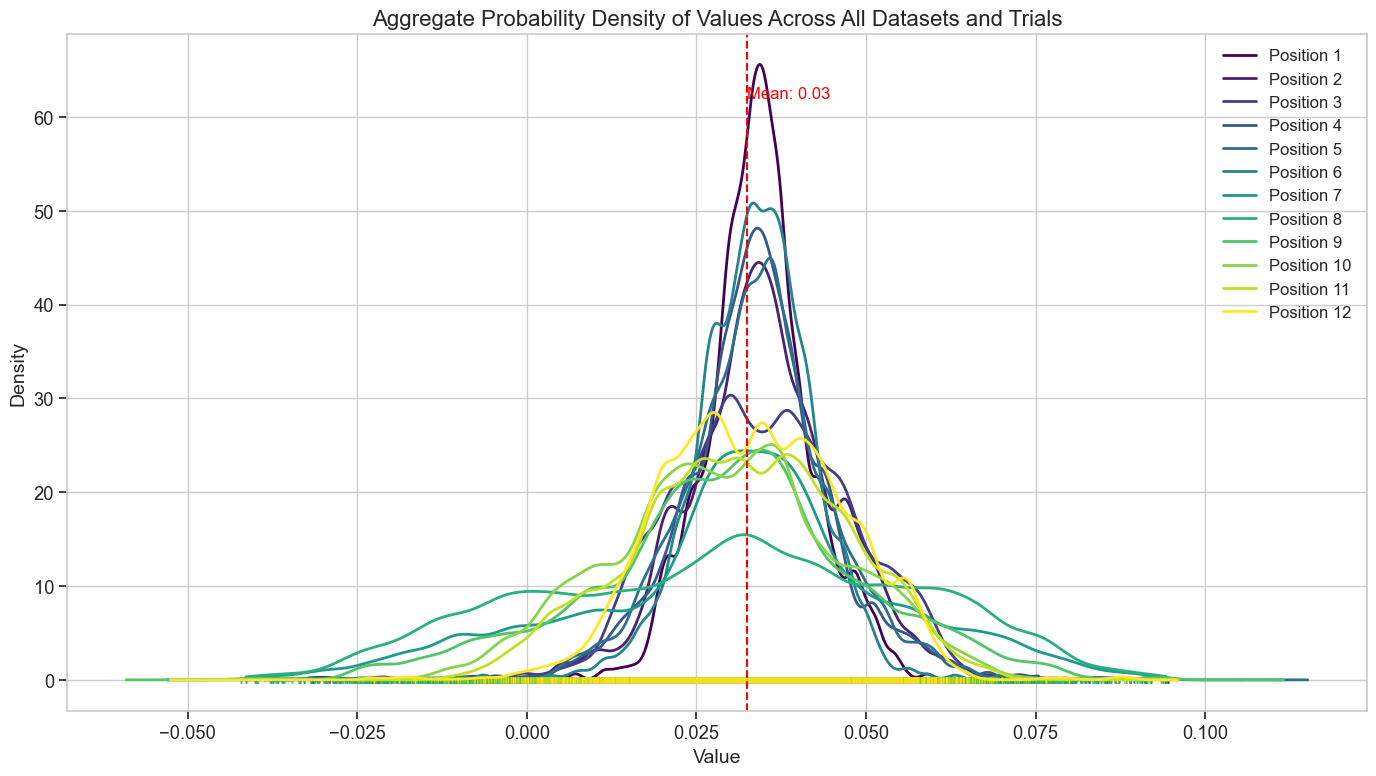

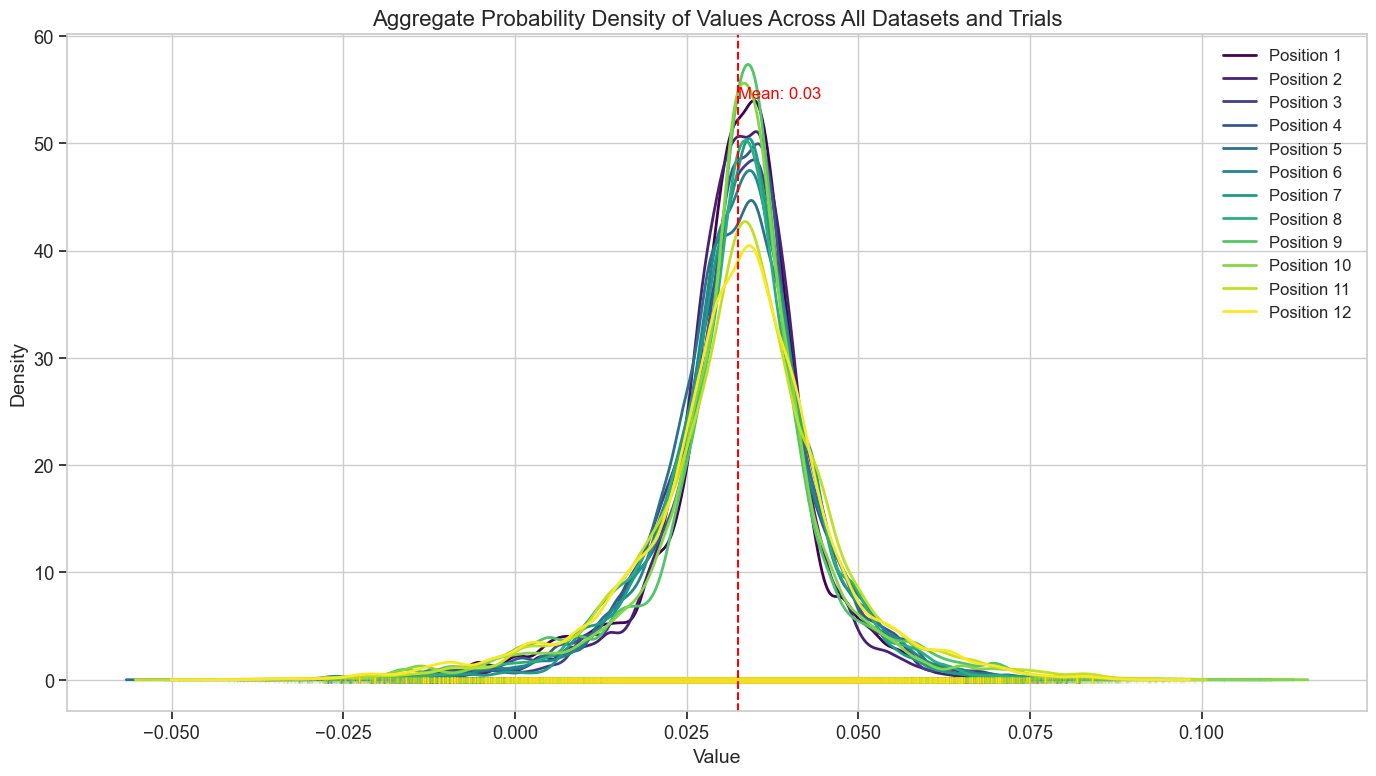

In [154]:
plot_aggregate_density(full_sim_tz(pops_random_c2_v2,15))
plot_aggregate_density(full_sim_tz(pops_greedy_c2_v2,15))
plot_aggregate_density(full_sim_tz(pops_landmax_c2_v2,15))
plot_aggregate_density(full_sim_tz(pops_strongmax_c2_v2,15))
plot_aggregate_density(full_sim_tz(pops_mimic_c2_v2,15))

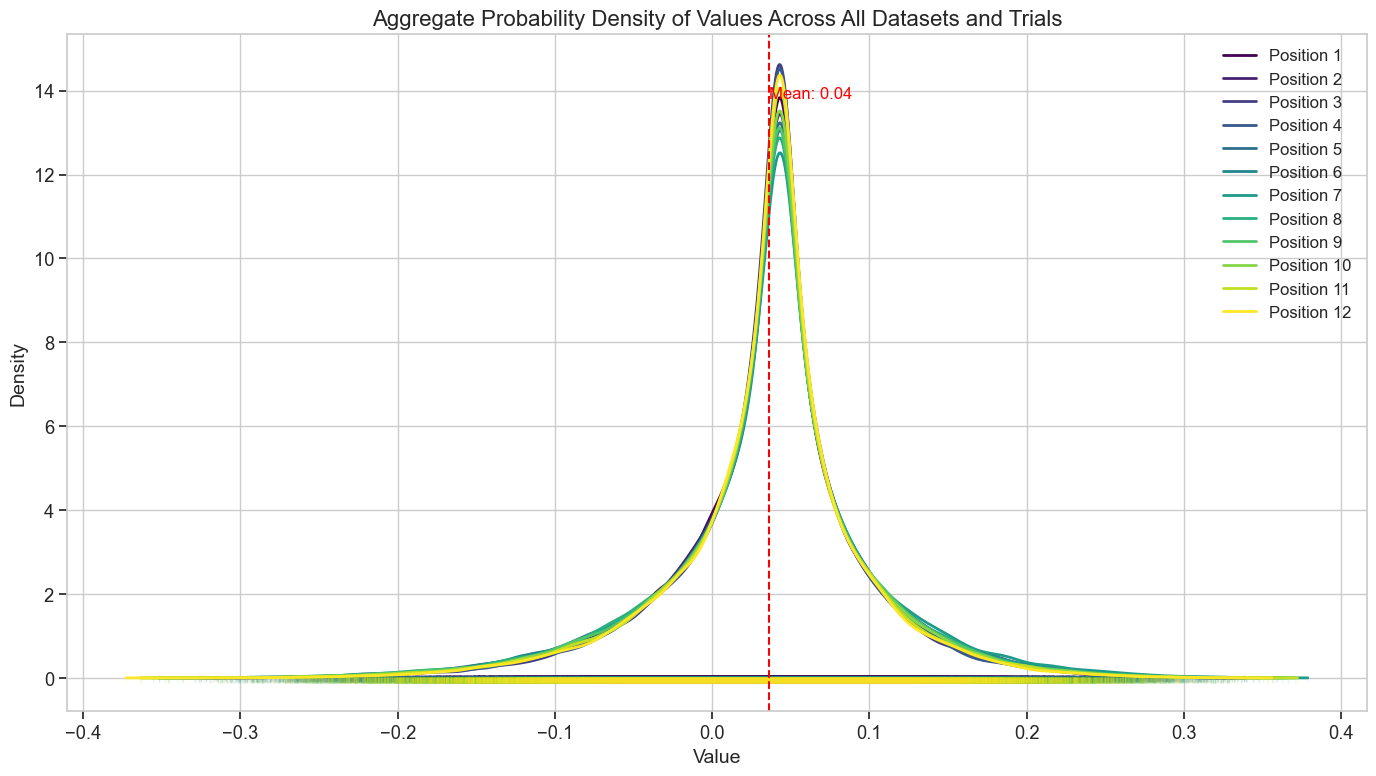

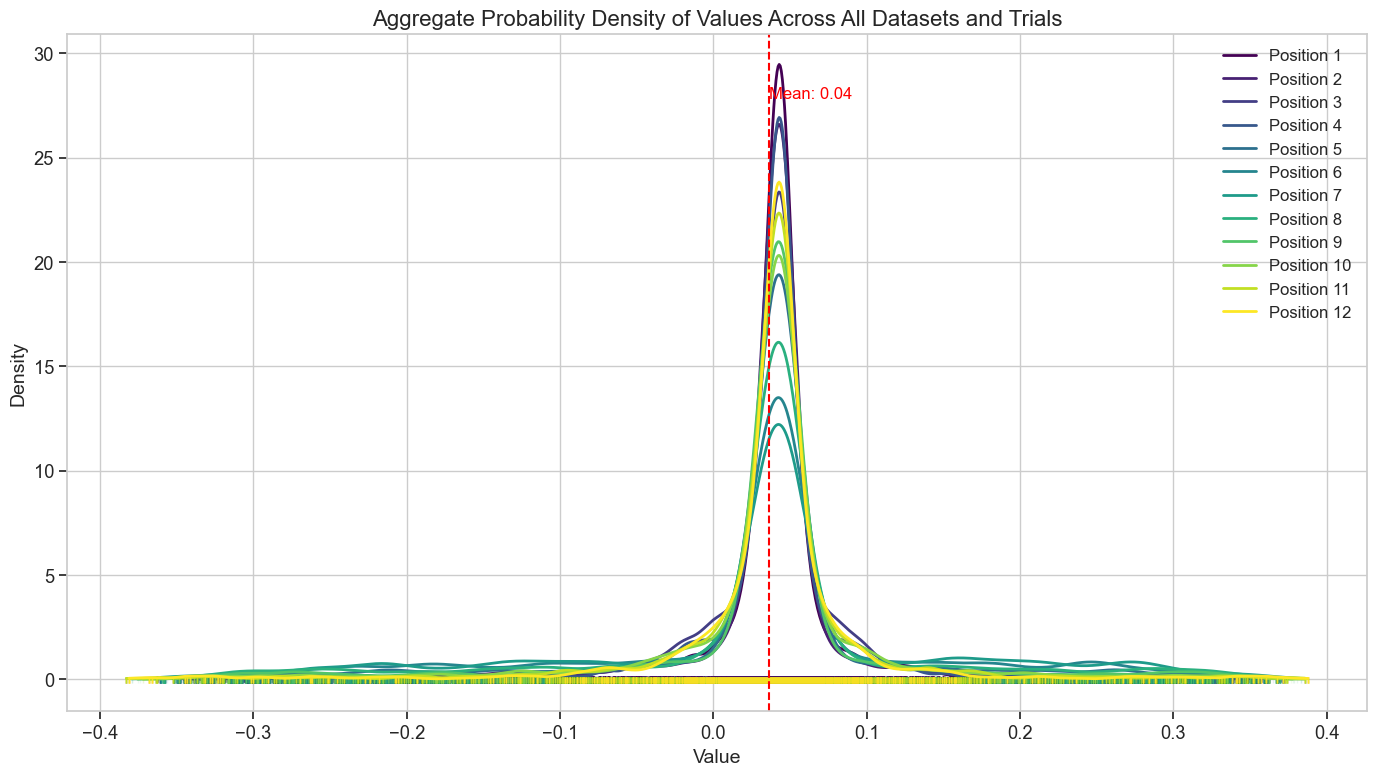

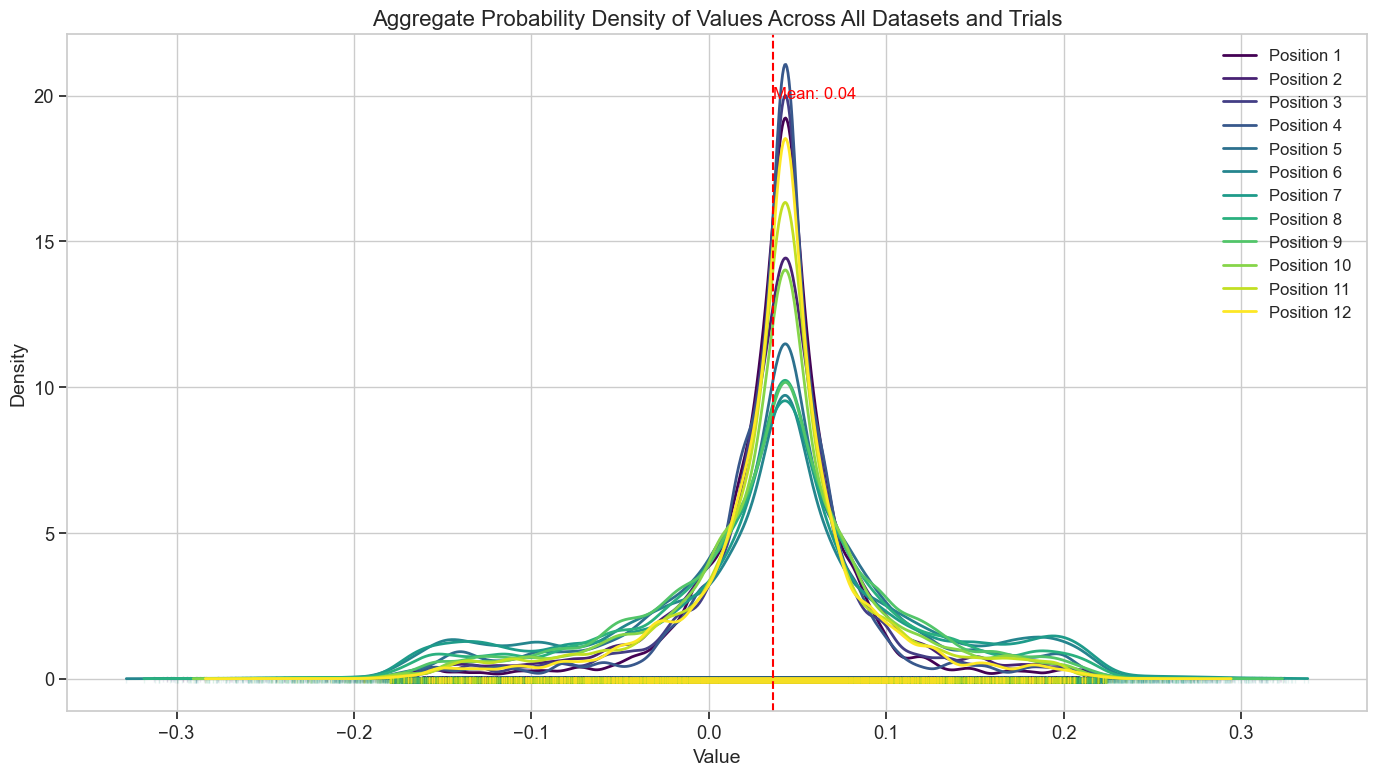

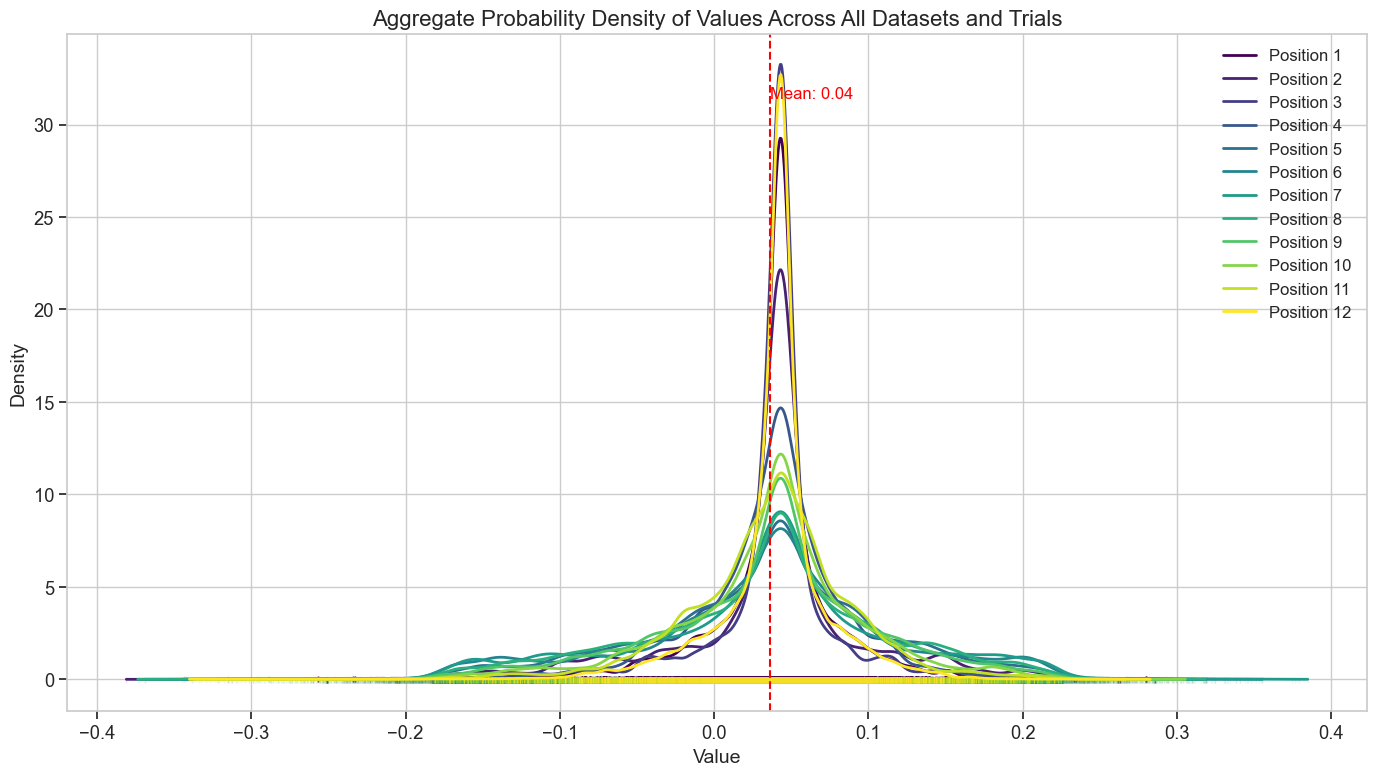

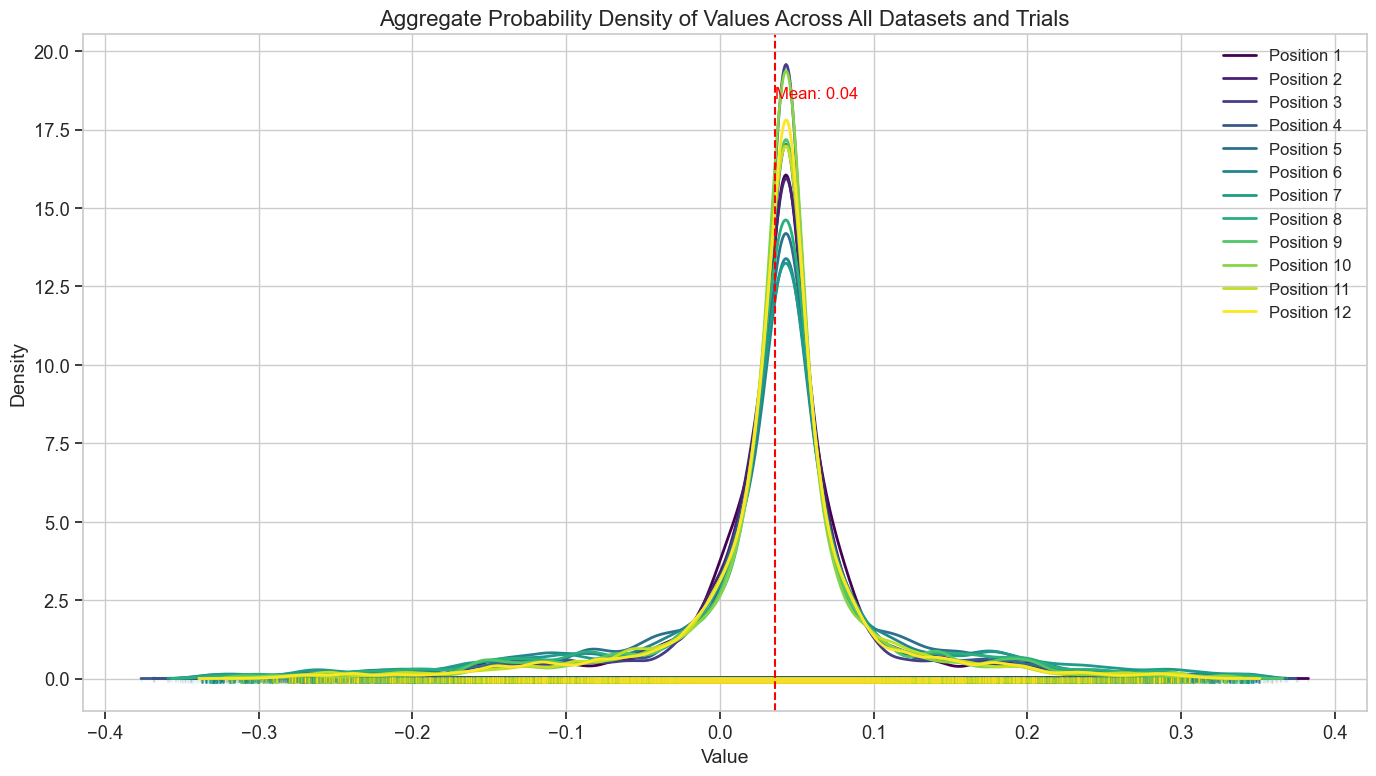

In [155]:
plot_aggregate_density(full_sim_tz(pops_random_c2_pure,15))
plot_aggregate_density(full_sim_tz(pops_greedy_c2_pure,15))
plot_aggregate_density(full_sim_tz(pops_landmax_c2_pure,15))
plot_aggregate_density(full_sim_tz(pops_strongmax_c2_pure,15))
plot_aggregate_density(full_sim_tz(pops_mimic_c2_pure,15))

/var/folders/58/gxcqk5bd4055b6n0b6yszvlw0000gn/T/ipykernel_62527/1440968090.py:372: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.95])


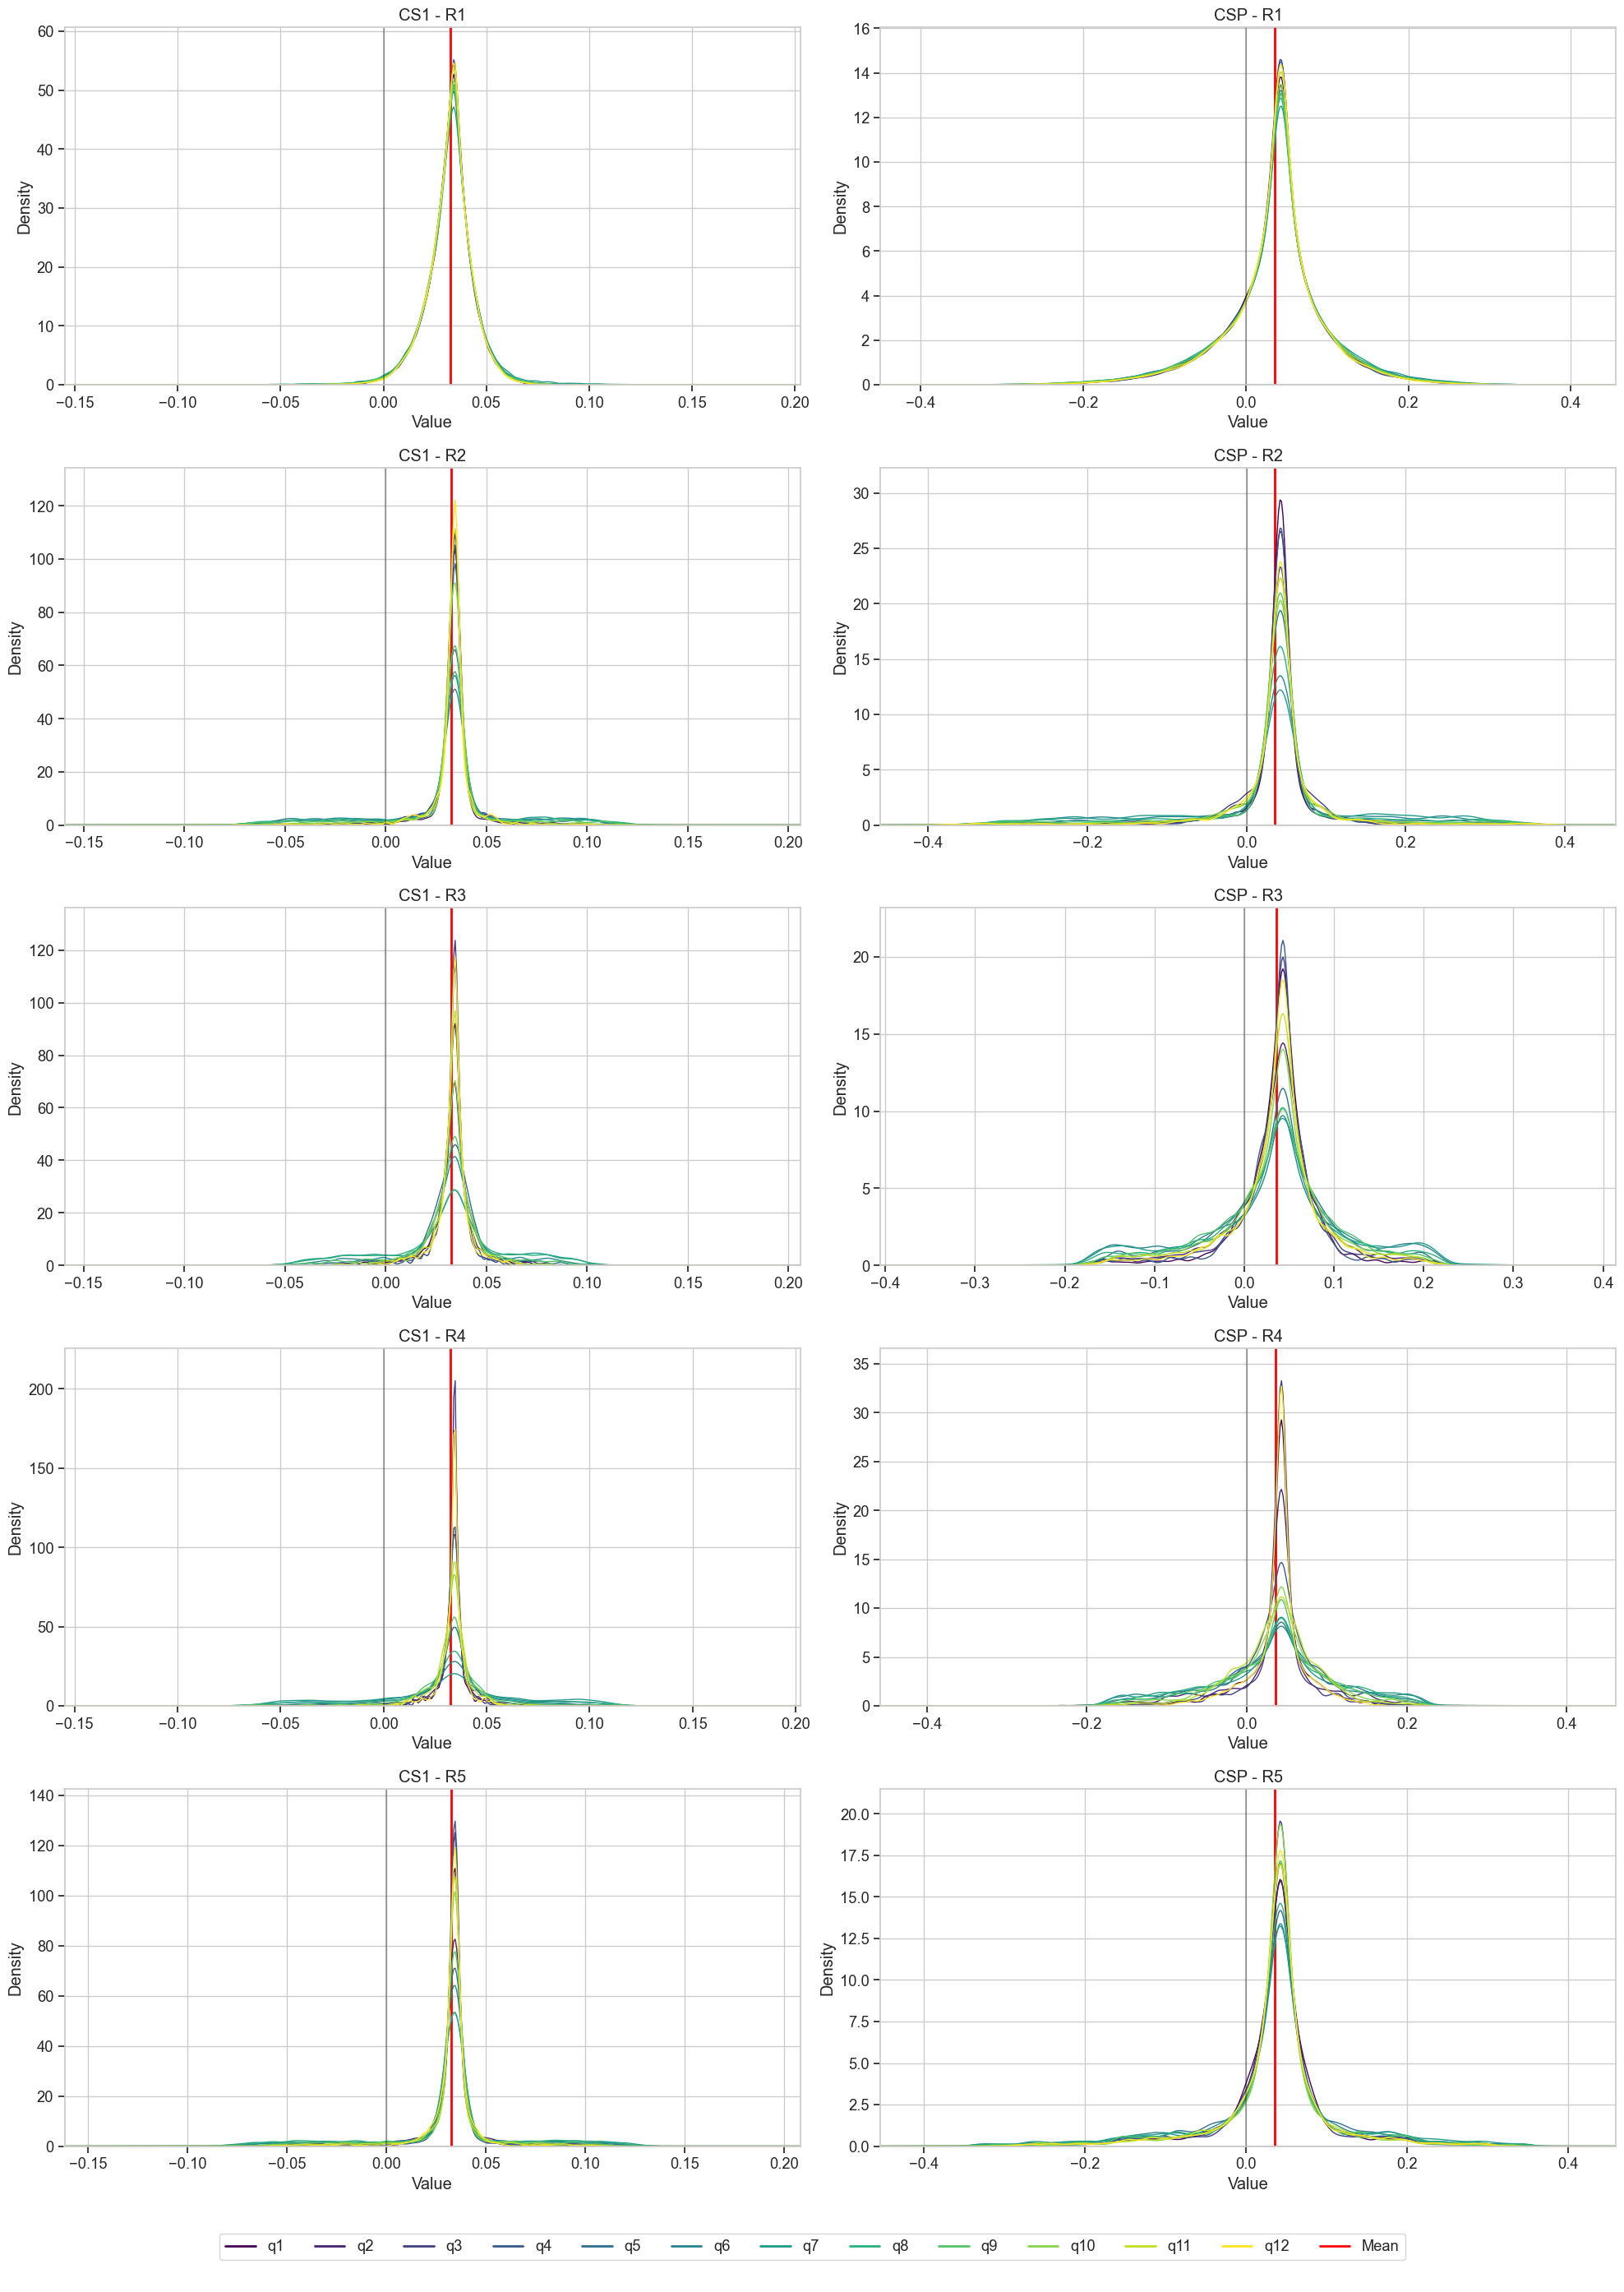

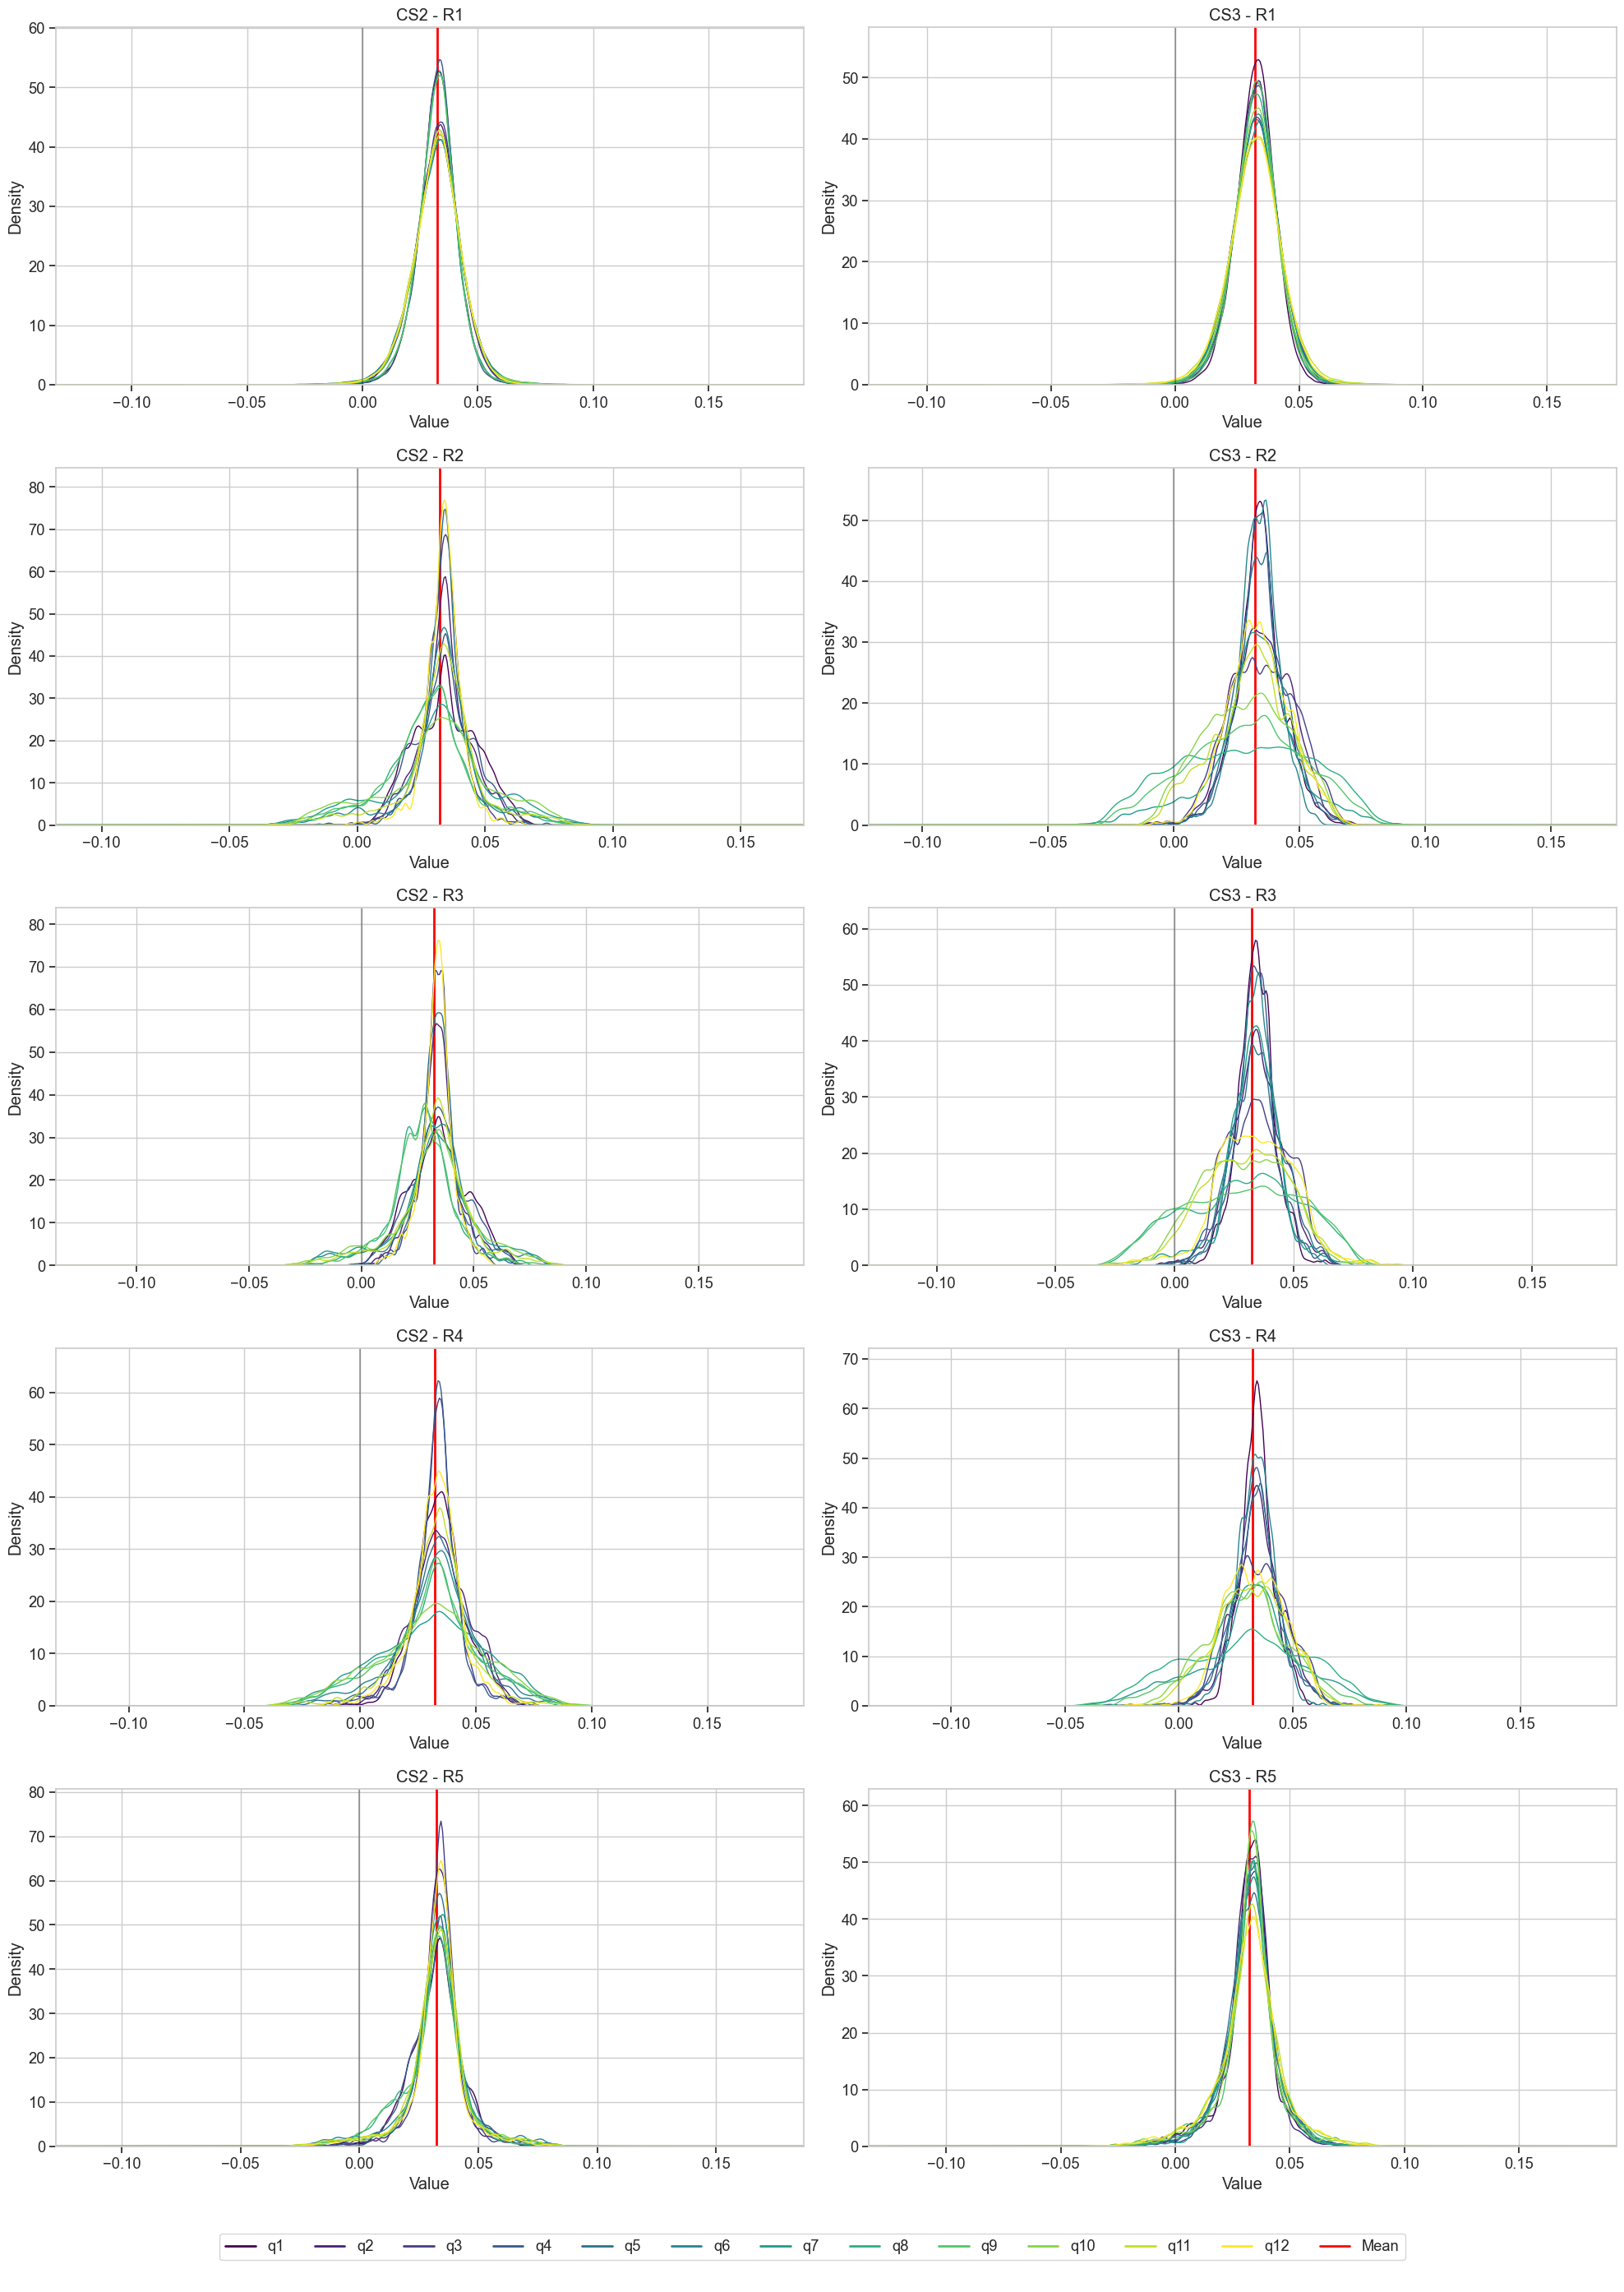

In [268]:
# Your original datasets list
datasets = [
    full_sim_tz(pops_random_c2_th, 15),
    full_sim_tz(pops_greedy_c2_th, 15),
    full_sim_tz(pops_landmax_c2_th, 15),
    full_sim_tz(pops_strongmax_c2_th, 15),
    full_sim_tz(pops_mimic_c2_th, 15),
    full_sim_tz(pops_random_c2_v1, 15),
    full_sim_tz(pops_greedy_c2_v1, 15),
    full_sim_tz(pops_landmax_c2_v1, 15),
    full_sim_tz(pops_strongmax_c2_v1, 15),
    full_sim_tz(pops_mimic_c2_v1, 15),
    full_sim_tz(pops_random_c2_v2, 15),
    full_sim_tz(pops_greedy_c2_v2, 15),
    full_sim_tz(pops_landmax_c2_v2, 15),
    full_sim_tz(pops_strongmax_c2_v2, 15),
    full_sim_tz(pops_mimic_c2_v2, 15),
    full_sim_tz(pops_random_c2_pure, 15),
    full_sim_tz(pops_greedy_c2_pure, 15),
    full_sim_tz(pops_landmax_c2_pure, 15),
    full_sim_tz(pops_strongmax_c2_pure, 15),
    full_sim_tz(pops_mimic_c2_pure, 15)
]

# Call with non-uniform axes
plot_multiple_datasets_two_figures(datasets, labels=None, 
                                  fig_width_per_col=10, fig_height_per_row=6,
                                  uniform_x_axis=False, uniform_y_axis=False)

# Call with uniform axes - will only show labels on edges
#plot_multiple_datasets_two_figures(datasets, labels, 
#                                  fig_width_per_col=10, fig_height_per_row=6,
#                                  uniform_x_axis=True, uniform_y_axis=True)

0.006798140924882309
0.01363990985210656
0.005553895851611074
0.006731709403929053
0.016151148966614258
0.005045409903953071
0.007007511125738349
0.008338457964802945
0.004775168411194551
0.004907606039134534
0.004901070791792788
0.00932812266378412
0.0096241057040109
0.004838459271381889
0.005464227218624238
0.06364876902800738
0.08773176254938125
0.043016351058527566
0.059025443127769084
0.073886422111496
[[np.float64(0.06820270558287758), np.float64(0.0743397189133759), np.float64(0.06583875270588094), np.float64(0.0879008899604524), np.float64(0.08493058371566667)], [np.float64(0.05136119768553891), np.float64(0.0544169649892842), np.float64(0.05368311833664217), np.float64(0.05544830949733851), np.float64(0.05260715572138417)], [np.float64(0.05339717657421975), np.float64(0.052558648894694394), np.float64(0.0556828536431118), np.float64(0.05250543868594907), np.float64(0.057674486295082796)], [np.float64(0.14754728778057272), np.float64(0.15609521236276816), np.float64(0.171367500

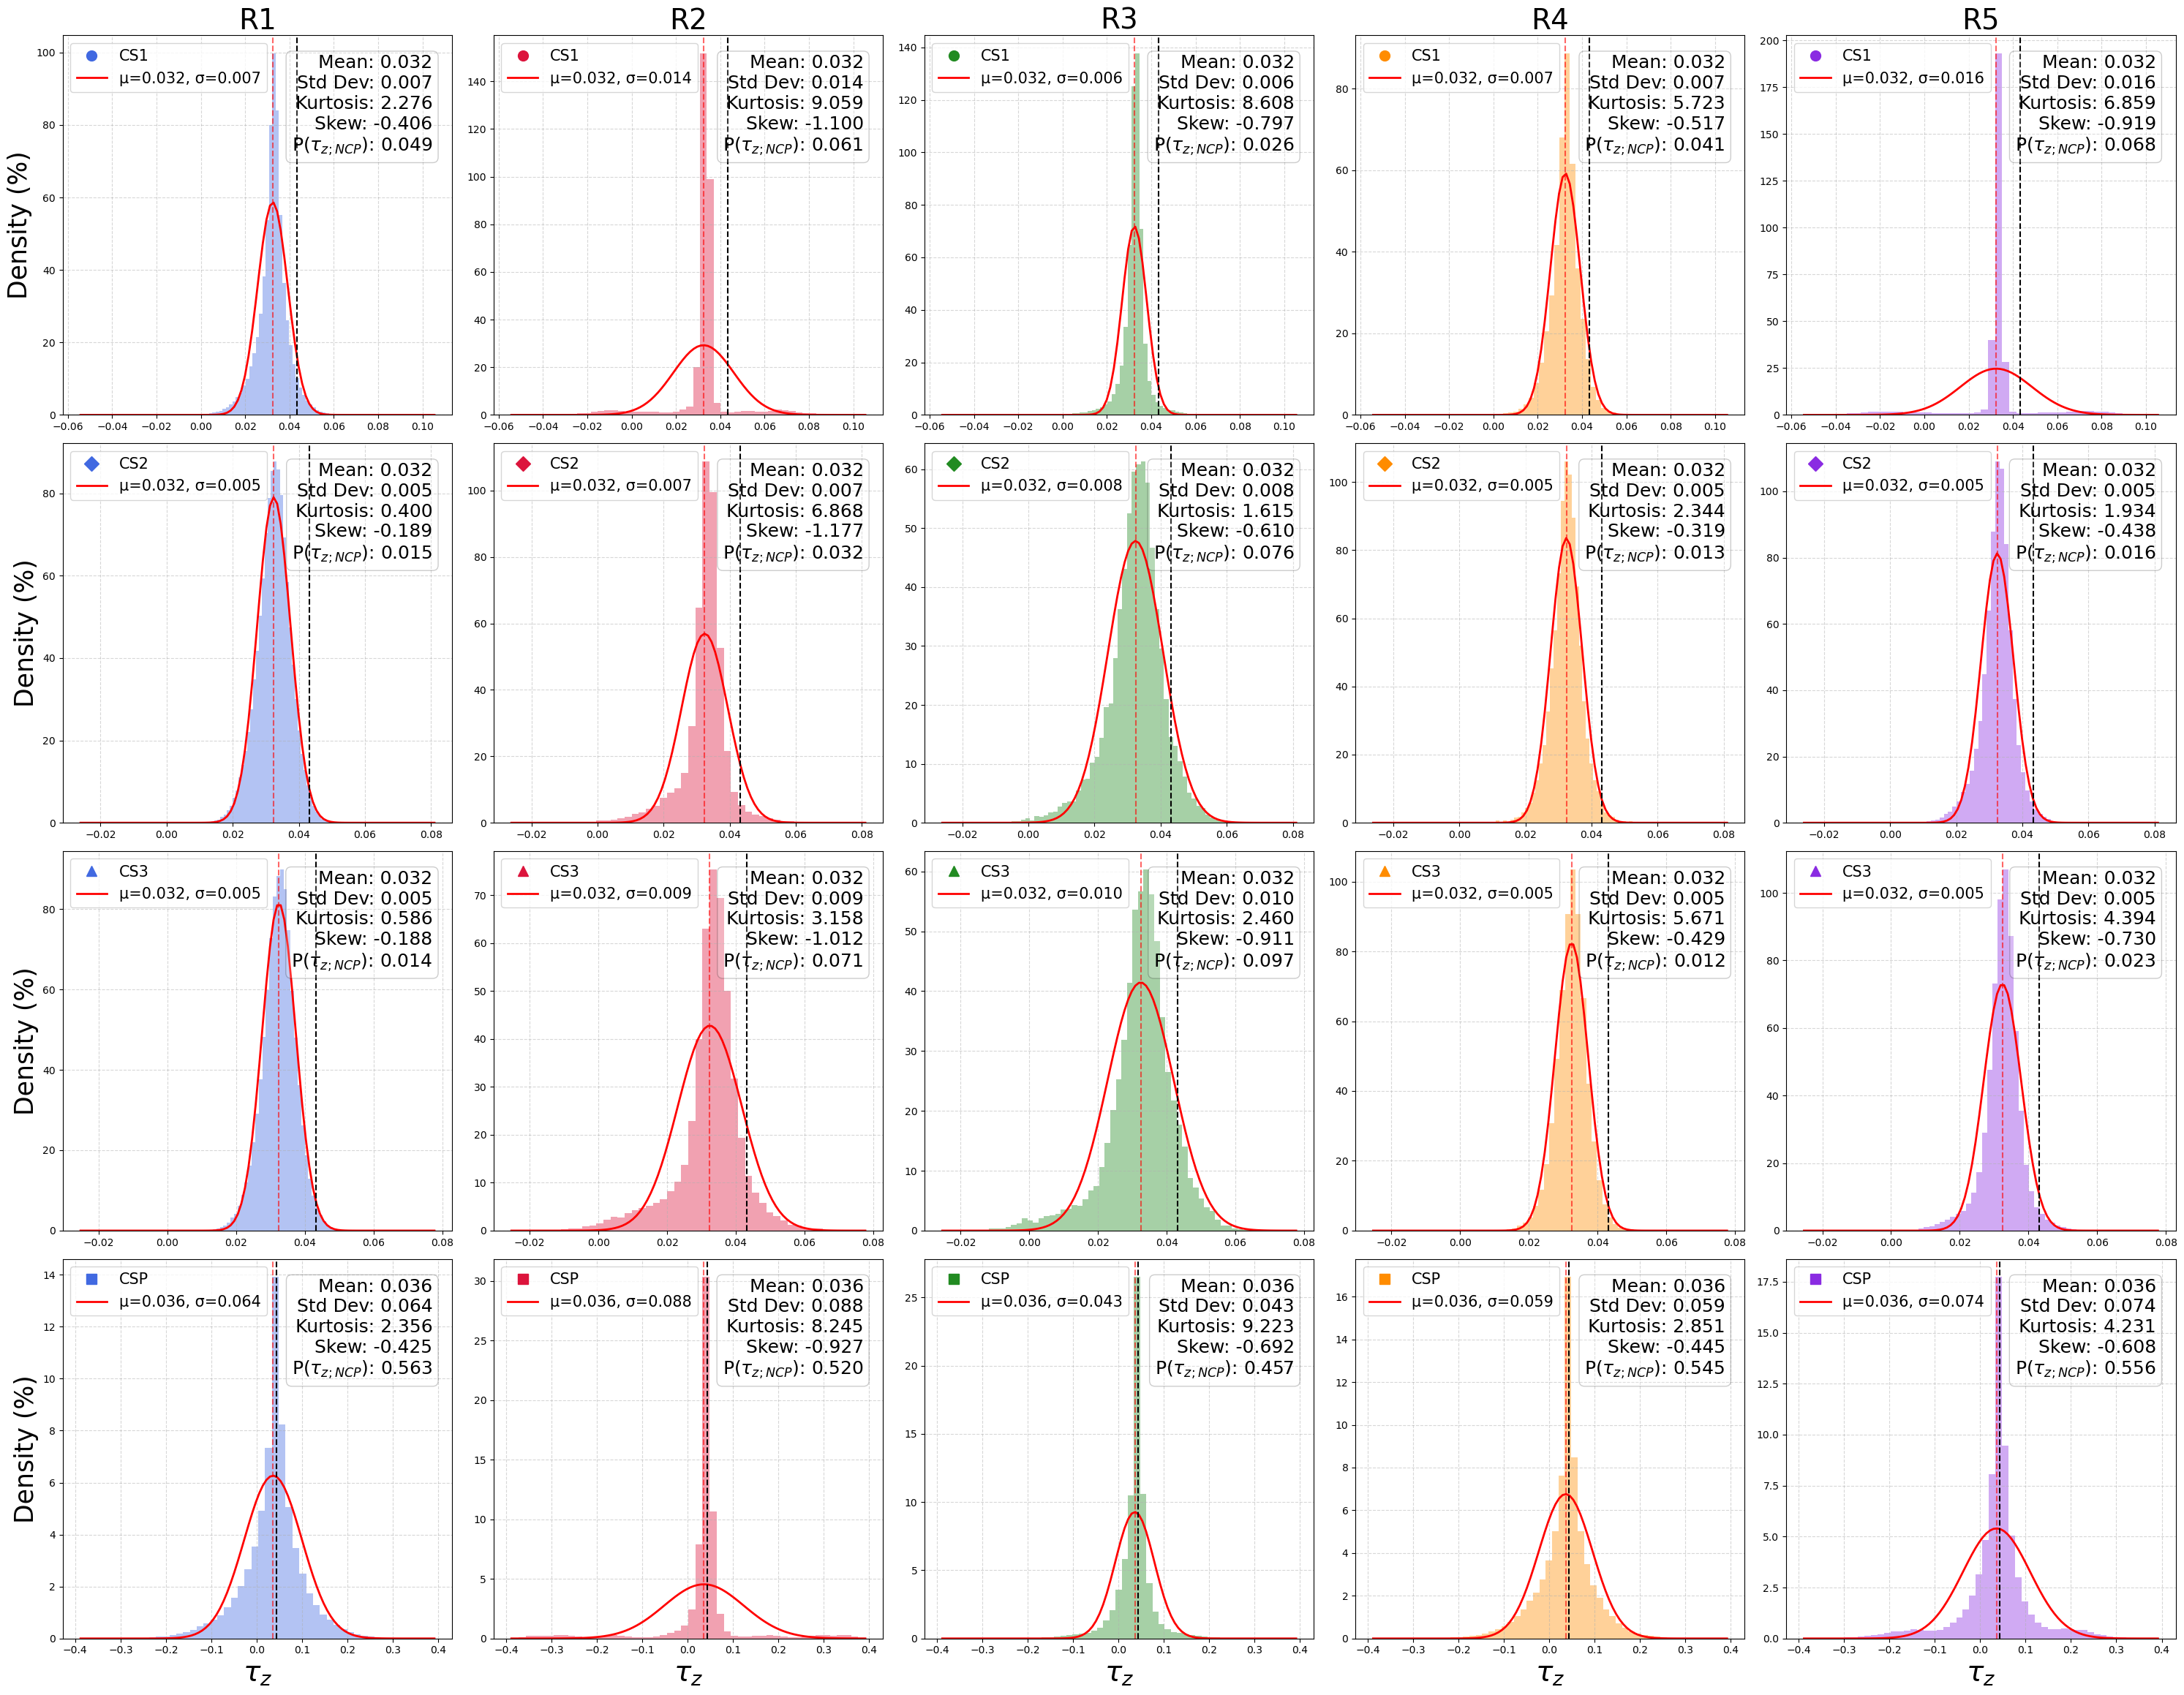

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

datasets = [
    full_sim_tz(pops_random_c4_th, 15),
    full_sim_tz(pops_greedy_c4_th, 15),
    full_sim_tz(pops_landmax_c4_th, 15),
    full_sim_tz(pops_strongmax_c4_th, 15),
    full_sim_tz(pops_mimic_c4_th, 15),
    full_sim_tz(pops_random_c4_v1, 15),
    full_sim_tz(pops_greedy_c4_v1, 15),
    full_sim_tz(pops_landmax_c4_v1, 15),
    full_sim_tz(pops_strongmax_c4_v1, 15),
    full_sim_tz(pops_mimic_c4_v1, 15),
    full_sim_tz(pops_random_c4_v2, 15),
    full_sim_tz(pops_greedy_c4_v2, 15),
    full_sim_tz(pops_landmax_c4_v2, 15),
    full_sim_tz(pops_strongmax_c4_v2, 15),
    full_sim_tz(pops_mimic_c4_v2, 15),
    full_sim_tz(pops_random_c4_pure, 15),
    full_sim_tz(pops_greedy_c4_pure, 15),
    full_sim_tz(pops_landmax_c4_pure, 15),
    full_sim_tz(pops_strongmax_c4_pure, 15),
    full_sim_tz(pops_mimic_c4_pure, 15)
]

def plot_histograms_grid(datasets, time_range=(300, 499), figsize=(30, 24)):
    """
    Plot histograms with fit curves for multiple datasets in a grid layout.
    
    Parameters:
    -----------
    datasets : list
        List of datasets, each with shape (n_trials, n_timesteps, n_dimensions)
    time_range : tuple
        Range of time steps to include (start, end)
    figsize : tuple
        Figure size for the plot
    """
    n_datasets = len(datasets)
    start_time, end_time = time_range
    
    # Define grid layout
    n_rows = 4
    n_cols = 5
    
    if n_datasets > n_rows * n_cols:
        raise ValueError(f"Can only display {n_rows * n_cols} datasets in the grid, but got {n_datasets}")
    
    # Define colors for each column
    colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    
    # Define markers for each row
    markers = ['o', 'D', '^', 's']  # circle, diamond, triangle, square

    threshold = 0.04322
    # Create figure with grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to make indexing easier
    
    # Find the min and max x values for each row to make x-axes uniform per row
    row_min_x = [float('inf')] * n_rows
    row_max_x = [float('-inf')] * n_rows
    
    # First pass: find min and max x values for each row
    for i, data in enumerate(datasets):
        if i >= n_rows * n_cols:
            continue
            
        row_idx = i // n_cols
        
        # Extract data for the specified time range
        time_slice = slice(start_time, end_time + 1)
        selected_data = data[:, time_slice, :]
        
        # Flatten the data for histogram
        flat_data = selected_data.reshape(-1)
        
        # Update min and max for the row
        row_min_x[row_idx] = min(row_min_x[row_idx], np.min(flat_data))
        row_max_x[row_idx] = max(row_max_x[row_idx], np.max(flat_data))
    # Process each dataset
    max_density=[max_th,max_v1,max_v2,max_p]
    for i, data in enumerate(datasets):
        if i >= n_datasets:
            break
            
        n_trials, n_timesteps, n_dimensions = data.shape
        
        if n_dimensions != 12:
            raise ValueError(f"Dataset {i+1}: Expected 12 dimensions, but got {n_dimensions}")
        
        # Extract data for the specified time range
        time_slice = slice(start_time, end_time + 1)
        selected_data = data[:, time_slice, :]
        
        # Flatten the data for histogram
        flat_data = selected_data.reshape(-1)
        
        # Get the current subplot
        ax = axes[i]
        
        # Determine column index for color and row index for marker
        col_idx = i % n_cols
        row_idx = i // n_cols
        hist_color = colors[col_idx]
        
        # Create legend label based on row (CS1, CS2, CS3, CSP)
        if row_idx == 3:
            legend_label = f'CSP'
        else:
            legend_label = f'CS{row_idx+1}'
        
        # Create histogram with normalized y-axis (0-100)
        hist_values, bin_edges, patches = ax.hist(flat_data, bins=50, density=True, 
                                          alpha=0.4, color=hist_color, 
                                          label=legend_label)
                                          
        # Scale the y-axis values to range from 0 to 100
       # max_density = np.max([np.float64(48.98734484454637), np.float64(99.47113439635753), np.float64(73.97348246976217), np.float64(85.57198150664834), np.float64(111.69010767074764), np.float64(46.33570305988926), np.float64(48.9320488885684), np.float64(43.50713108942431), np.float64(35.64586632164801), np.float64(56.48715115034697), np.float64(46.30078458090764), np.float64(32.83104206837531), np.float64(32.73852054189013), np.float64(34.0456856172911), np.float64(52.345517352909724), np.float64(14.307420373054745), np.float64(25.980772528956667), np.float64(15.575665982851712), np.float64(18.41183738390349), np.float64(18.624787264412724)])
        #max_hist.append(max_density)
        #if max_density > 0:  # Avoid division by zero
            #for rect, height in zip(patches, hist_values):
                #rect.set_height(height / max_density * 100)
        
        # Set y-axis limits to 0-100 for all plots
        #if i in range(0,5):
        #    ax.set_ylim(0, max_th+5)
        #if i in range(5,10):
        #    ax.set_ylim(0, max_v1+5)
        #if i in range(10,15):
        #    ax.set_ylim(0, max_v2+5)
        #if i in range(15,20):
        #    ax.set_ylim(0, max_p+5)
        
        # Set uniform x-axis for all plots in this row
        #ax.set_xlim(row_min_x[row_idx], row_max_x[row_idx])
        
        # Calculate bin centers for curve fitting
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Fit normal distribution
        mu, sigma = stats.norm.fit(flat_data)
        kurtosis = stats.kurtosis(flat_data)  # This calculates the excess kurtosis
        skew = stats.skew(flat_data)  # This calculates the excess kurtosis
        actual_kurtosis = stats.kurtosis(flat_data) + 3
        prob_above_threshold = np.mean(np.abs(flat_data) > threshold)
        print(sigma)
        
        # Plot the fit curve
        x = np.linspace(row_min_x[row_idx], row_max_x[row_idx], 100)
        y = stats.norm.pdf(x, mu, sigma)
        
        # Scale the y values of the normal curve to the 0-100 range
        
            
        ax.plot(x, y, 'r-', linewidth=2, label=f'μ={mu:.3f}, σ={sigma:.3f}')
        
        # Add a point with the appropriate marker for the legend
        # This is a dummy point just for the marker in the legend
        ax.scatter([], [], color=hist_color, marker=markers[row_idx], s=100, label='_nolegend_')
        
        # Calculate additional statistics
        median = np.median(flat_data)
        min_val = np.min(flat_data)
        max_val = np.max(flat_data)
        p25 = np.percentile(flat_data, 25)
        p75 = np.percentile(flat_data, 75)
        
        # Add text box with statistics - fixed the LaTeX formatting
        stats_text = (f"Mean: {mu:.3f}\n"
                      f"Std Dev: {sigma:.3f}\n"
                      f"Kurtosis: {kurtosis:.3f}\n"
                      f"Skew: {skew:.3f}\n"
                      f"P($\\tau_{{z;NCP}}$): {prob_above_threshold:.3f}")
        
        # Add stats text box
        ax.text(0.95, 0.95, stats_text, 
                transform=ax.transAxes,
                fontsize=18,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.2))
        
        # Add vertical lines for mean and median
        ax.axvline(x=mu, color='red', linestyle='--', alpha=0.6)
        ax.axvline(x=0.04322, color='black', linestyle='--', alpha=1)
        
        # Set titles and labels
        if i<5:
            ax.set_title(f'R{i+1}', fontsize=28)
        
        # Only add x-axis label to bottom row
        if i >= n_datasets - n_cols:
            ax.set_xlabel(r'$\tau_z$', fontsize=28)
        
        # Only add y-axis label to leftmost column
        if i % n_cols == 0:
            ax.set_ylabel('Density (%)', fontsize=25)
        
        # Create custom legend with marker and label
        handles, labels = ax.get_legend_handles_labels()
        # Only keep the first handle (histogram) and its label
        legend_handle = handles[0]
        # Modify the legend handle to use the appropriate marker
        from matplotlib.lines import Line2D
        custom_handle = Line2D([0], [0], marker=markers[row_idx], color=hist_color, 
                             markersize=10, linestyle='None')
        
        ax.legend(handles=[custom_handle, handles[1]], 
                  labels=[legend_label, labels[1]], 
                  loc='upper left', fontsize=15)
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.5)
    
    # Hide any unused subplots
    for j in range(n_datasets, n_rows * n_cols):
        axes[j].set_visible(False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout
    print(max_density)
    return fig


# Example usage:
# Assuming datasets is a list of 20 numpy arrays, each with shape (100, 500, 12)
#ensemble average histogram

fig = plot_histograms_grid(datasets)
plt.savefig('tz_histogram_per_rule_per_IC_ens_avg_c4.png', dpi=300, bbox_inches='tight')
plt.show()




In [21]:
max_vals = [
    [np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_th)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_th)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_th)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_th)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_th)[0]], 15))],
    [np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v1)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v1)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v1)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v1)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v1)[0]], 15))],
    [np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v2)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v2)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v2)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v2)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v2)[0]], 15))],
    [np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_pure)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_pure)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_pure)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_pure)[0]], 15)),
    np.max(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_pure)[0]], 15))]
]
max_th=max_vals[0]
max_v1=max_vals[1]
max_v2=max_vals[2]
max_p=max_vals[3]

max_th

[np.float64(0.06820270558287758),
 np.float64(0.0743397189133759),
 np.float64(0.06583875270588094),
 np.float64(0.0879008899604524),
 np.float64(0.08493058371566667)]

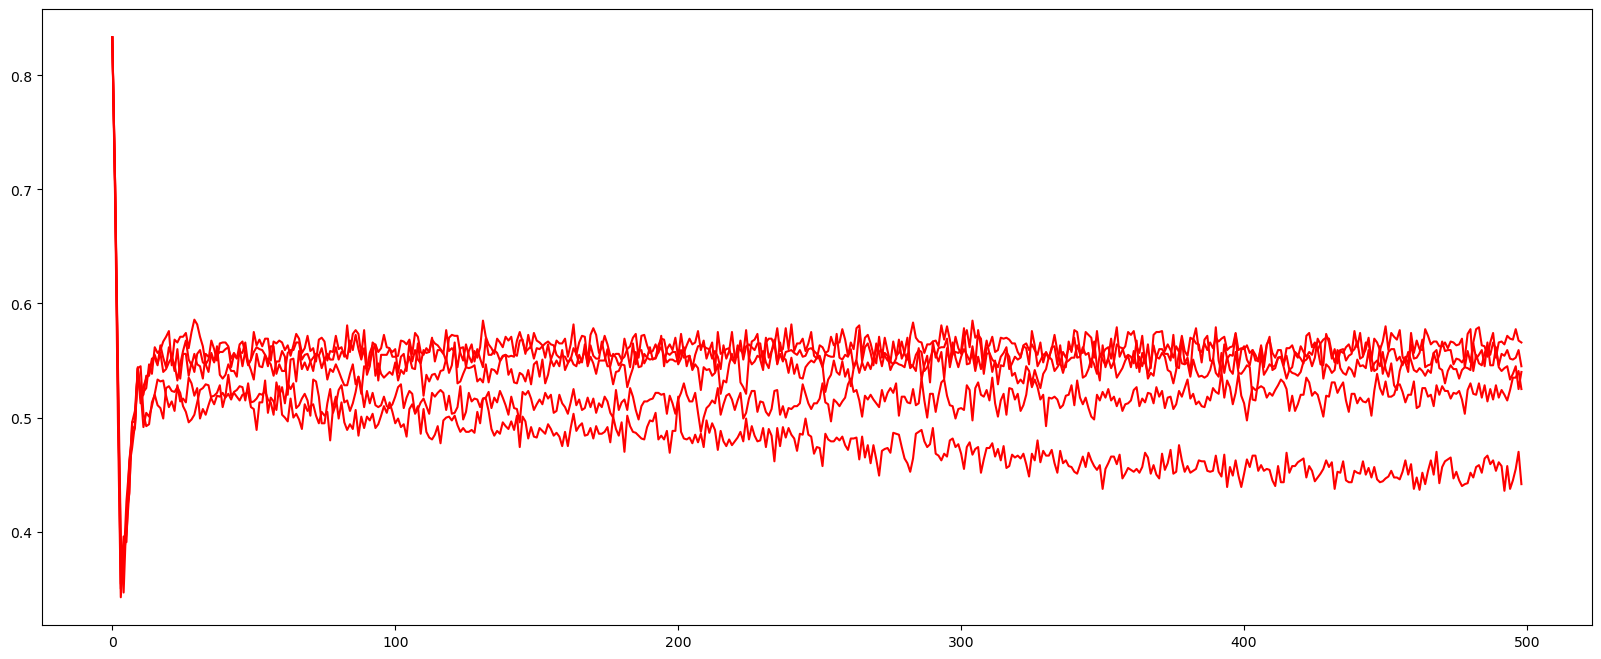

In [31]:
t = np.arange(499)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]
    
datas_pure=[np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_random_c4_pure,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_greedy_c4_pure,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_landmax_c4_pure,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_strongmax_c4_pure,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_mimic_c4_pure,15)),axis=0),axis=1)]
plt.figure(figsize=(20, 8))
for data in datas_pure:
    data_transposed = data.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]  
    plt.plot(t, data_transposed, label=f'w', color='r')

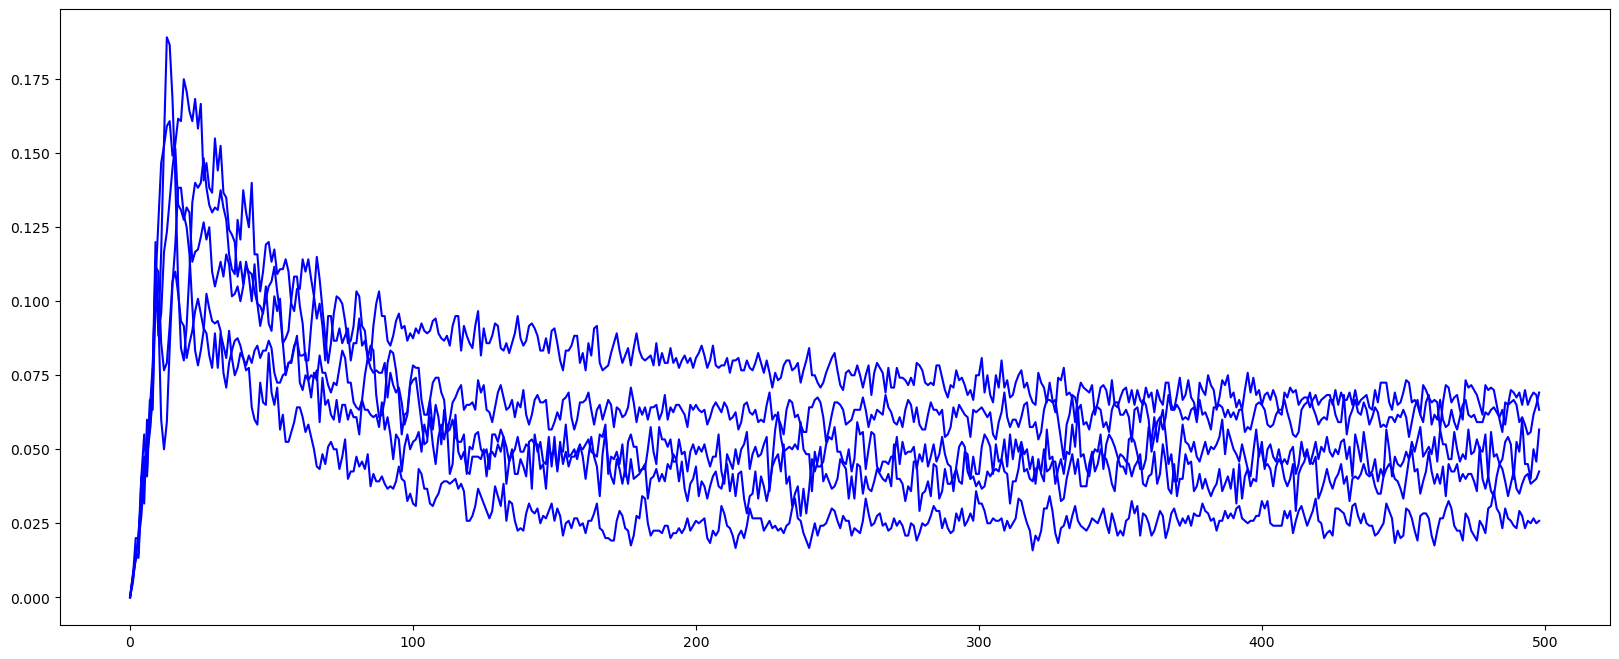

In [32]:
t = np.arange(499)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]
    
datas_th=[np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_random_c4_th,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_greedy_c4_th,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_landmax_c4_th,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_strongmax_c4_th,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_mimic_c4_th,15)),axis=0),axis=1)]
plt.figure(figsize=(20, 8))
for data in datas_th:
    data_transposed = data.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]  
    plt.plot(t, data_transposed, label=f'w', color='b')

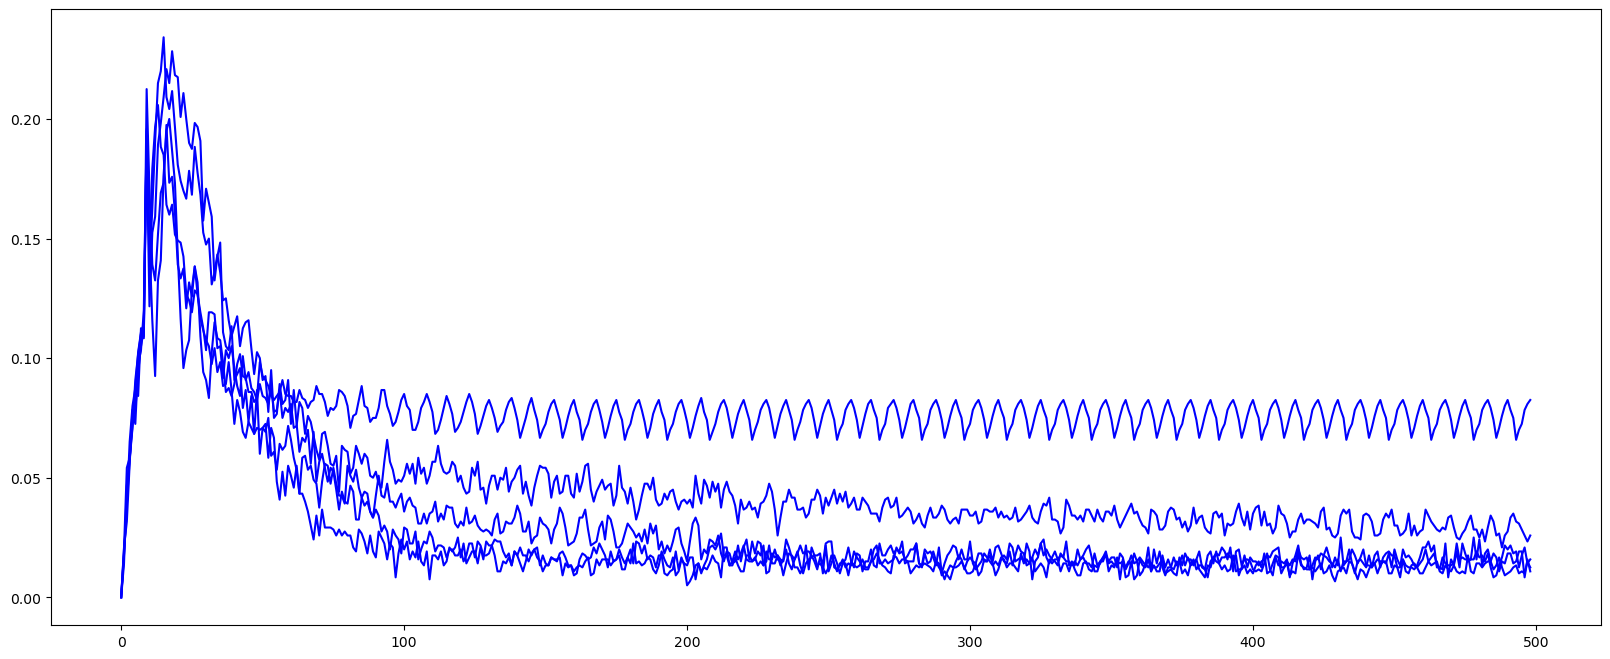

In [34]:
t = np.arange(499)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]
    
datas_v1=[np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_random_c4_v1,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_greedy_c4_v1,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_landmax_c4_v1,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_strongmax_c4_v1,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_mimic_c4_v1,15)),axis=0),axis=1)]
plt.figure(figsize=(20, 8))
for data in datas_v1:
    data_transposed = data.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]  
    plt.plot(t, data_transposed, label=f'w', color='b')

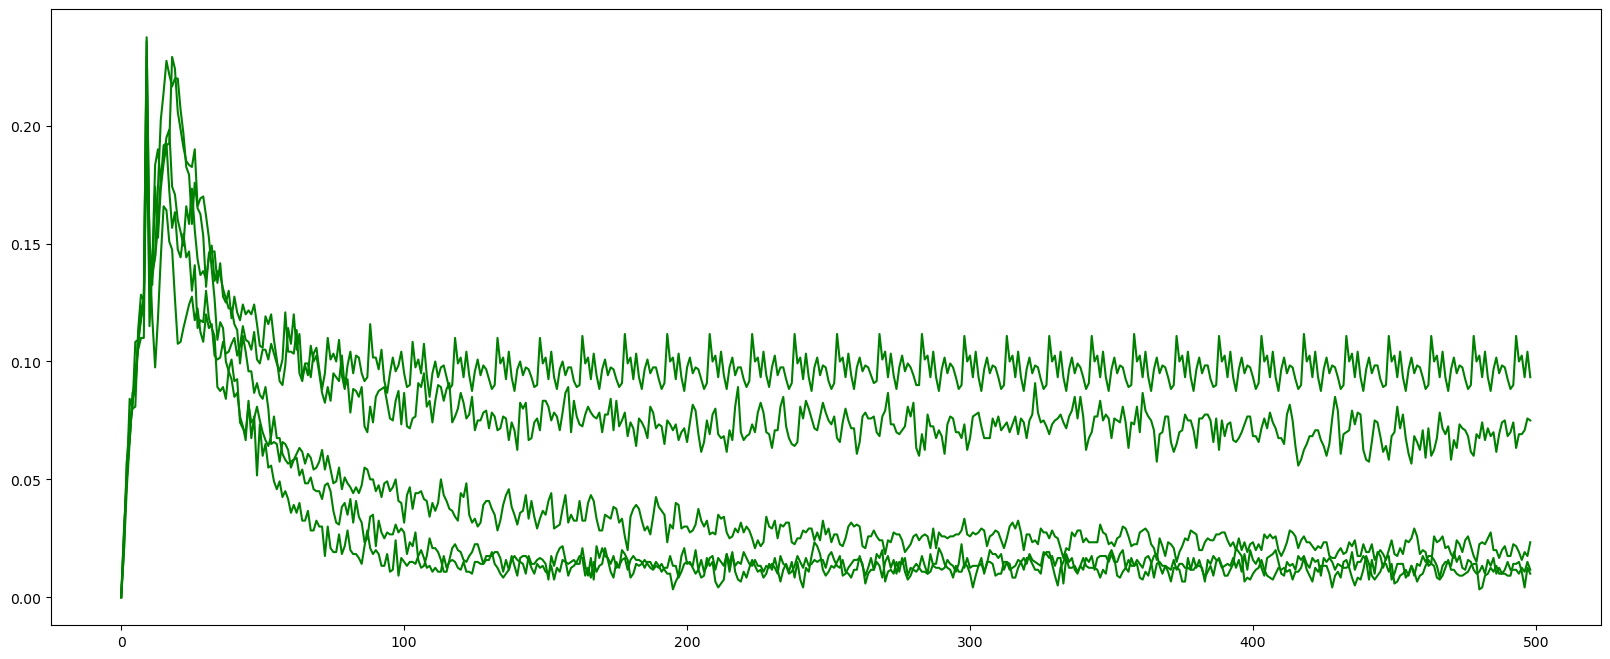

In [33]:
t = np.arange(499)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]
    
datas_v2=[np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_random_c4_v2,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_greedy_c4_v2,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_landmax_c4_v2,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_strongmax_c4_v2,15)),axis=0),axis=1),
       np.mean(np.mean(np.array(full_sim_tz_NP_prob(pops_mimic_c4_v2,15)),axis=0),axis=1)]
plt.figure(figsize=(20, 8))
for data in datas_v2:
    data_transposed = data.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]  
    plt.plot(t, data_transposed, label=f'w', color='g')

In [24]:
from matplotlib.lines import Line2D
def time_averaged_one_point_measures_at_t(dataset, t, n):
    # Assuming dataset is list of time series data
    # Calculate the time average using window size n
    # Make sure we don't go below index 0
    start_idx = max(0, t-n)
    sum_till_t = np.sum(dataset[start_idx:t], axis=0)
    # The actual window size might be smaller if t < n
    actual_window_size = t - start_idx
    # Avoid division by zero
    if actual_window_size == 0:
        return np.zeros_like(dataset[0])
    time_average_t = (1/actual_window_size) * sum_till_t
    return np.array(time_average_t)
    
def time_averaged_one_point_measures_matrix_full_sim(dataset, n):
    # Calculate time averages for all time points with window size n
    time_average = []
    for t in range(len(dataset)):
        time_average.append(time_averaged_one_point_measures_at_t(dataset, t, n))
    return time_average

def create_NCP_prob_visualization(datas_all_ics, titles, denom):
    """
    Create visualization for NCP probability across multiple datasets,
    showing both raw data (lower alpha) and time-averaged data.
    
    Parameters:
    -----------
    datas_all_ics : list of lists
        Each inner list contains 5 datasets for one initial condition
    titles : list
        Titles for each subplot (one per initial condition)
    denom : float
        Denominator value for normalization
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.lines import Line2D
    
    colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    markers = ['o', 'D',"^", 's']
    t = np.arange(499)  # Create a list of time steps [0, 1, 2, ..., 498]
    num_datasets = len(datas_all_ics)
    print(f"Number of initial conditions: {num_datasets}")
    
    # Create figure and axes - column layout (num_datasets rows, 1 column)
    fig, axes = plt.subplots(num_datasets, 1, figsize=(4, 8))
    
    # If only one dataset, axes won't be an array
    if num_datasets == 1:
        axes = [axes]
    
    # Find global y-axis limits for consistent scaling across subplots
    global_ymax = 0
    for dataset_group in datas_all_ics:
        for data in dataset_group:
            # Check original data maximum
            original_max = np.max(data)
            if original_max > global_ymax:
                global_ymax = original_max
            
            # Also check time-averaged data maximum
            time_avg_data = time_averaged_one_point_measures_matrix_full_sim(data, 20)
            avg_max = np.max(time_avg_data)
            if avg_max > global_ymax:
                global_ymax = avg_max
    
    global_ymax = global_ymax + 0.05 * global_ymax  # Add 5% padding
    global_ymin = 0
    
    # List to store line objects for the first legend (R1-R5)
    line_objects = []
    
    # Process each initial condition dataset
    for i, dataset_group in enumerate(datas_all_ics):
        subplot_lines = []  # Store lines for this subplot
        
        # Process each of the 5 data types within this initial condition
        for j, data in enumerate(dataset_group):
            # Store original data for raw plot
            original_data = np.array(data)
            original_transposed = original_data.T
            
            # Plot the raw data with lower alpha
            axes[i].plot(t, original_transposed, color=colors[j], alpha=0.2)
            
            # Time average the data
            avg_data = time_averaged_one_point_measures_matrix_full_sim(data, 30)
            avg_data = np.array(avg_data)
            
            # Transpose data for plotting time series
            avg_data_transposed = avg_data.T
            
            # Plot the time-averaged data and store the line object
            line, = axes[i].plot(t, avg_data_transposed, label=f'R{j+1}', color=colors[j], alpha=0.7)
            
            # For the first subplot, collect line objects for the legend
            if i == 0:
                line_objects.append(line)
                
            # Store the line for this subplot's local legend
            subplot_lines.append(line)

        if i < 3:
            axes[i].set_ylim(0, 0.35)
            axes[i].set_yticks([0, 0.1, 0.2,0.3])
        if i == 3:
            axes[i].set_ylim(0, 0.85)
            axes[i].set_yticks([0, 0.25, 0.5,0.8])
        
        # Add vertical line at t=10
        axes[i].axvline(x=10, color='red', linestyle='--', alpha=0.5)
        
        # Set axis labels - only bottom subplot gets x-label now
        if i == num_datasets - 1:
            axes[i].set_xlabel(r'$\ell$', fontsize=14)
        
        # All subplots get y-label in column layout
        axes[i].set_ylabel(r'$P(\Lambda_{NCP})$', fontsize=16)
        
        # Create the CS legend (control strategy legend)
        legend_name = ["CS1", "CS2", "CS3","CSP"]
        cs_legend = Line2D([0], [0], marker=markers[i], color='gray', 
                           linestyle='-', linewidth=0.5, markersize=8, 
                           label=legend_name[i])
        
        # Add the CS legend to each subplot (except the first one, which is handled separately)
        if i < 3:
            axes[i].legend(handles=[cs_legend], fontsize=12, loc="upper right")
        
        # Add grid
        axes[i].grid(True, alpha=0.5)
    
    # Add both legends to the last subplot
    if line_objects:
        # First add the R1-R5 legend
        r_legend = axes[3].legend(handles=line_objects, fontsize=8, loc="lower right", 
                                 title="")
        # Add the R legend as a separate artist to the axes
        axes[3].add_artist(r_legend)
        
        # Now create and add the CS legend for the first subplot
        legend_name = ["CS1", "CS2", "CS3","CSP"]
        cs_legend = Line2D([0], [0], marker=markers[3], color='gray', 
                           linestyle='-', linewidth=0.5, markersize=10, 
                           label=legend_name[3])
        axes[3].legend(handles=[cs_legend], fontsize=12, loc="upper right")
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig("probability_of_NCP_maps_CS123P_all_rules_12Q_column_c4.png", dpi=300, bbox_inches='tight')
    
    return fig


Number of initial conditions: 4


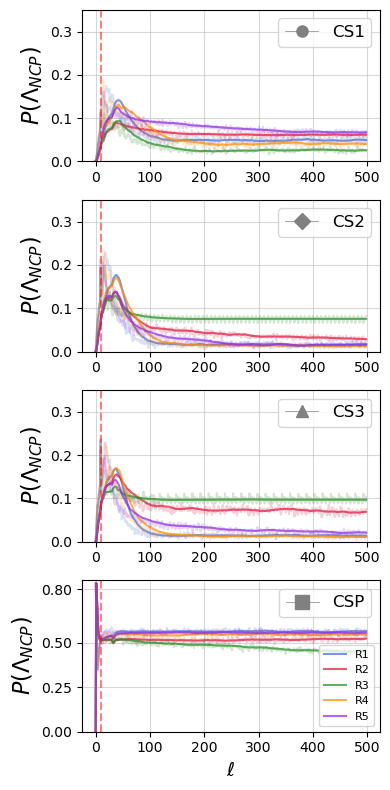

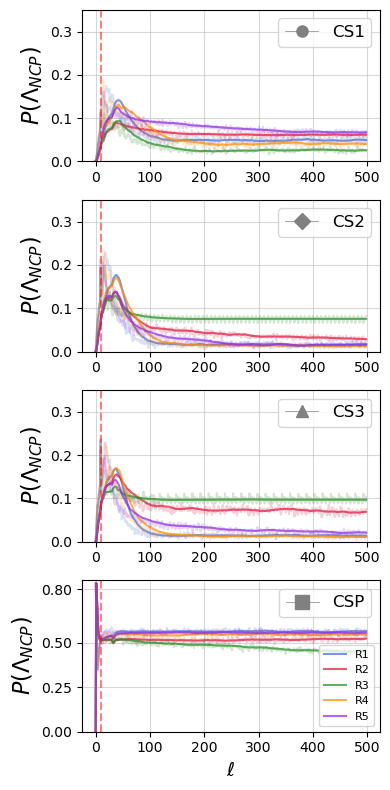

In [35]:
datas_all_ics = [datas_th,datas_v1,datas_v2,datas_pure]
titles=["CS1","CS2","CS3","CSP"]
denom=15
create_NCP_prob_visualization(datas_all_ics,titles,denom)

In [52]:
datas_th=[pops_random_c4_th,pops_greedy_c4_th,pops_landmax_c4_th,pops_strongmax_c4_th,pops_mimic_c4_th]
#datas_pure=[pops_random_c4_pure,pops_greedy_c4_pure,pops_landmax_c4_pure,pops_strongmax_c4_pure,pops_mimic_c4_pure]
datas_v1=[pops_random_c4_v1,pops_greedy_c4_v1,pops_landmax_c4_v1,pops_strongmax_c4_v1,pops_mimic_c4_v1]
datas_v2=[pops_random_c4_v2,pops_greedy_c4_v2,pops_landmax_c4_v2,pops_strongmax_c4_v2,pops_mimic_c4_v2]
all_datas = [datas_th, datas_v1,datas_v2]
all_datas_proc=[]
for datas in all_datas:
    datas_ic=[]
    for data_r in datas:
        datas_ic.append(ensemble_averaged_one_point_measures_mean_std(data_r)[0])
    all_datas_proc.append(datas_ic)
len(all_datas_proc)
def process_data(datas):
    global_max = 0
    all_processed_data = []
    
    for pops in datas:
        es_avg = ensemble_averaged_one_point_measures_mean_std(pops)[0]
        fulllist = []
        fulllist_1=[]
        
        for timestep in CPcond(abs_tz(es_avg, denom)):
            timesteplist = []
            timesteplist_1s=[]
            for ele in timestep:
                if ele <= 1:
                    ele = 0
                    ele1=0
                else:
                    ele1=1
                timesteplist.append(ele)
                timesteplist_1s.append(ele)
            fulllist.append(timesteplist)
            fulllist_1.append(timesteplist_1s)
        
        rotated_data = (fulllist_1[0:499])
        all_processed_data.append(rotated_data)
        current_max = np.max(rotated_data)
        if current_max > global_max:
            global_max = current_max
        
            
    return all_processed_data, global_max

# Process all datasets and find overall global max
processed_data_sets = []
overall_global_max = 0

for datas in all_datas:
    processed_data, global_max = process_data(datas)
    processed_data_sets.append(processed_data)
    if global_max > overall_global_max:
        overall_global_max = global_max

In [54]:
data_sets = [
    [ens_avg_change_in_ext_work_random_c4_th, ens_avg_change_in_ext_work_greedy_c4_th, 
     ens_avg_change_in_ext_work_landscape_maximizes_c4_th, ens_avg_change_in_ext_work_strongest_maximizes_c4_th,
     ens_avg_change_in_ext_work_mimic_c4_th],
    
    [ens_avg_change_in_ext_work_random_c4_v1, ens_avg_change_in_ext_work_greedy_c4_v1, 
     ens_avg_change_in_ext_work_landscape_maximizes_c4_v1, ens_avg_change_in_ext_work_strongest_maximizes_c4_v1,
     ens_avg_change_in_ext_work_mimic_c4_v1],

    [ens_avg_change_in_ext_work_random_c4_v2, ens_avg_change_in_ext_work_greedy_c4_v2, 
     ens_avg_change_in_ext_work_landscape_maximizes_c4_v2, ens_avg_change_in_ext_work_strongest_maximizes_c4_v2,
     ens_avg_change_in_ext_work_mimic_c4_v2]

    ##[ens_avg_change_in_ext_work_random_c4_pure, ens_avg_change_in_ext_work_greedy_c4_pure, 
     #ens_avg_change_in_ext_work_landscape_maximizes_c4_pure, ens_avg_change_in_ext_work_strongest_maximizes_c4_pure,
     #ens_avg_change_in_ext_work_mimic_c4_pure]
]

pops_datasets = [
    [ensemble_averaged_one_point_measures_mean_std(pops_random_c4_th)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_th)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_th)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_th)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_th)[0]],
    [ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v1)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v1)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v1)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v1)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v1)[0]],
    [ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v2)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v2)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v2)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v2)[0],
    ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v2)[0]]
    #[ensemble_averaged_one_point_measures_mean_std(pops_random_c4_pure)[0],
    #ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_pure)[0],
    #ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_pure)[0],
    #ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_pure)[0],
    #ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_pure)[0]]
]

def late_time_std(data_list):
    """
    Calculate the mean standard deviation for the late-time portion of each row.
    
    Parameters:
    - data_list: List of 500 rows 
    
    Returns:
    - Array of standard deviations for the late-time portion of each row
    """
    # Convert to numpy array if not already
    data = np.array(data_list[0])
    
    # Define late-time portion (e.g., last 100 rows)
    late_time_portion = data
    
    # Calculate standard deviation for each row of the late-time portion
    late_time_stds = np.std(late_time_portion, axis=1)
    
    return np.mean(late_time_stds[300:])



1.4309161314806968e-05


ValueError: x and y must be the same size

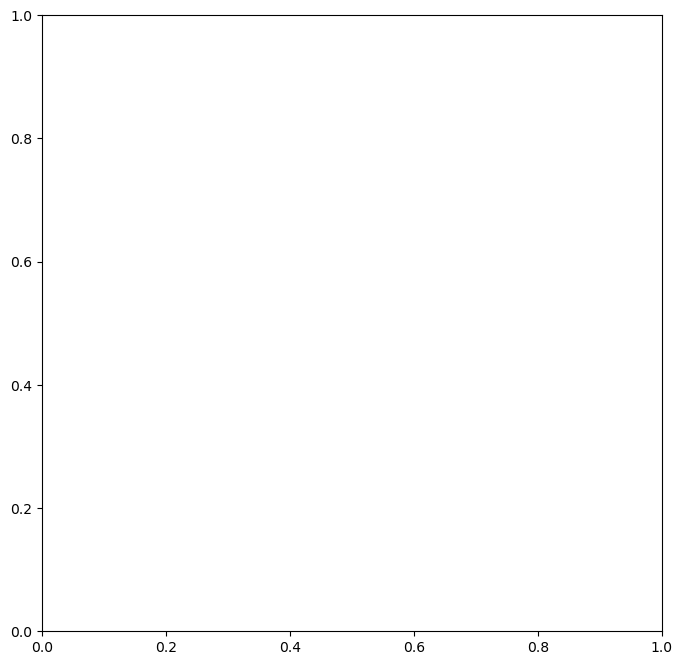

In [65]:
import numpy as np
import matplotlib.pyplot as plt



def cumulative_sum_positive_scatter(datas1_allIC, datas2_allIC):
    """
    Create a scatter plot of cumulative sums for a specific index,
    considering only positive values in data2.
    
    Parameters:
    - datas1: First dataset (numpy array of shape (time_steps, N))
    - datas2: Second dataset (numpy array of shape (time_steps, N))
    """
    colors=['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    markers=["o","D","^","s"]
    tz_datasets = [
    [late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_th)[0]], 15))],
    [late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v1)[0]], 15))],
    [late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v2)[0]], 15))]
    #[late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_pure)[0]], 15)),
    #late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_pure)[0]], 15)),
    #late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_pure)[0]], 15)),
    #late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_pure)[0]], 15)),
    #late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_pure)[0]], 15))]
    ]
    
    # Create the plot
    plt.figure(figsize=(8, 8))
    
    for j, (datas1, datas2) in enumerate(zip(datas1_allIC, datas2_allIC)):
        for i, (data1, data2) in enumerate(zip(datas1, datas2)):
            
            
            # Extract specific index time series
            data1 = np.array(data1)
            data2 = np.array(data2)
            ext_step_in=np.sum(data2[1])
            
            data2_pos = []
            for data in data2:
                datat = []
                for data_i in data:
                    if data_i > 0:
                        datat.append(data_i)
                    if data_i <= 0:
                        datat.append(0)
                data2_pos.append(datat)
            if j==3:
                print(data2_pos)
            
            # Compute cumulative sums for positive values
            cumsum1_positive = np.mean(data1, axis=0)
            cumsum1_positive_mean=np.mean(cumsum1_positive)
            cumsum2_positive = np.mean(data2_pos, axis=0)
            cumsum2_positive_mean=np.mean(cumsum2_positive)
            if i == 0:
                cumsum_2_max = np.mean(cumsum2_positive)
            print(cumsum_2_max)
            
            # Scatter plot for this dataset
            plt.scatter(datasets[j][i]/datasets[j][0], (cumsum2_positive_mean)/cumsum_2_max, 
                        alpha=0.7, color=colors[i], label=f'Dataset {i+1} (IC{j+1})', 
                        marker=markers[j],s=100)
    
    # Customize plot (moved outside the loops)
    #plt.title(r'$\langle \langle \Delta W^{\rm ex}\rangle_q\rangle_{\rm ens}$')
    plt.xlabel(r'$\frac{\langle\sigma_{\tau_z}\rangle}{\langle\sigma_{\tau_z}\rangle}$',fontsize=30)
    plt.ylabel(r'$\frac{\langle \langle \Delta_{+} W^{\rm ex}\rangle_q\rangle_{\rm ens}}{\langle \langle \Delta W^{\rm ex}\rangle_q\rangle_{\rm ens}}$',fontsize=30)
    
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



datas1_allIC = processed_data_sets
datas2_allIC = data_sets

cumulative_sum_positive_scatter(datas1_allIC, datas2_allIC)



1.4309161314806968e-05
1.4309161314806968e-05
1.4309161314806968e-05
1.4309161314806968e-05
1.4309161314806968e-05
7.263566646800769e-06
7.263566646800769e-06
7.263566646800769e-06
7.263566646800769e-06
7.263566646800769e-06
6.2912535340265075e-06
6.2912535340265075e-06
6.2912535340265075e-06
6.2912535340265075e-06
6.2912535340265075e-06


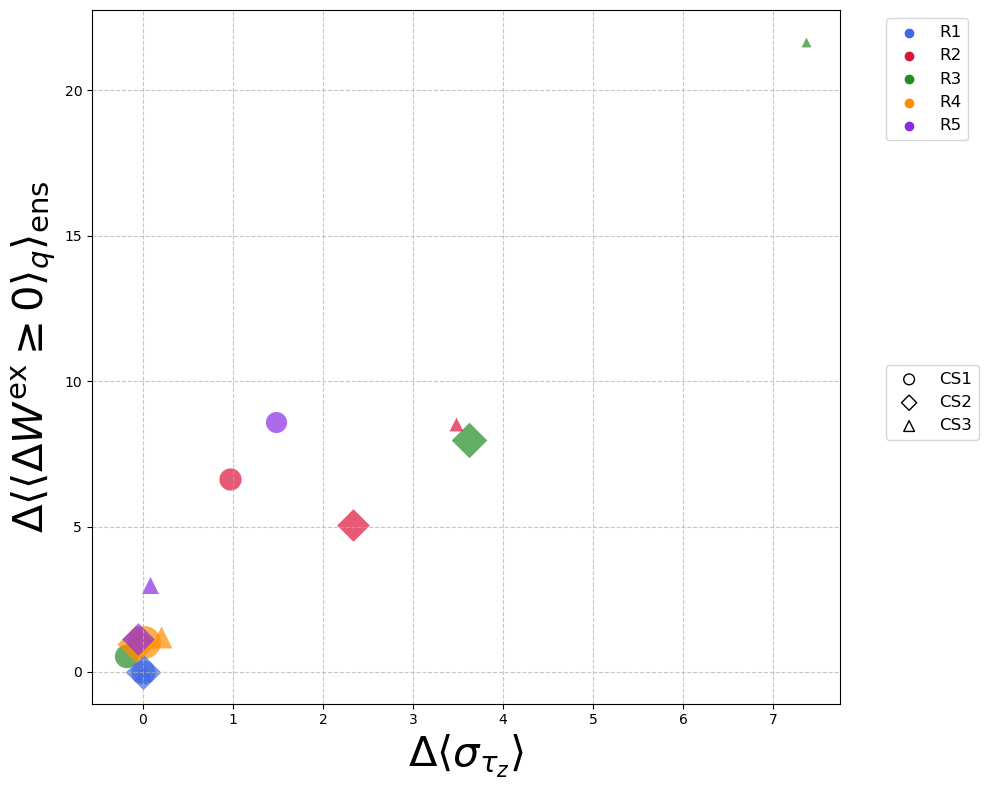

In [90]:
def cumulative_sum_positive_scatter(datas1_allIC, datas2_allIC):
    """
    Create a scatter plot with marker size representing cumsum1_positive_mean.
    
    Parameters:
    - datas1: First dataset (numpy array of shape (time_steps, N))
    - datas2: Second dataset (numpy array of shape (time_steps, N))
    """
    colors=['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    markers=["o","D","^","s"]
    CSlabels=["CS1","CS2","CS3"]
    rules=["R1","R2","R3","R4","R5"]
    tzs = [[late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_th)[0]], 15))],
    [late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v1)[0]], 15))],
    [late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v2)[0]], 15))]]
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Handles for legends
    color_handles = []
    marker_handles = []
    marker_handles_cs = []
    
    for j, (datas1, datas2) in enumerate(zip(datas1_allIC, datas2_allIC)):
        for i, (data1, data2) in enumerate(zip(datas1, datas2)):
            
            # Extract specific index time series
            data1 = np.array(data1)
            data2 = np.array(data2)
            ext_step_in = np.sum(data2[1])
            
            data2_pos = []
            for data in data2:
                datat = []
                for data_i in data:
                    if data_i > 0:
                        datat.append(data_i)
                    if data_i <= 0:
                        datat.append(0)
                data2_pos.append(datat)
            
            if j == 3:
                print(data2_pos)
            
            # Compute cumulative sums for positive values
            cumsum1_positive = np.mean(data1, axis=0)
            cumsum1_positive_mean = np.mean(cumsum1_positive)
            cumsum2_positive = np.mean(data2_pos, axis=0)
            cumsum2_positive_mean = np.mean(cumsum2_positive)
            
            if i == 0:
                cumsum_2_max = np.mean(cumsum2_positive)
            print(cumsum_2_max)
            
            # Normalize marker size
            # Use a scaling factor to make marker sizes more distinguishable
            marker_size = 100 * np.log(1 + np.abs(cumsum1_positive_mean))
            
            # Scatter plot for this dataset
            scatter = plt.scatter((tzs[j][i]-tzs[j][0])/tzs[j][0], (cumsum2_positive_mean-cumsum_2_max)/cumsum_2_max, 
                        alpha=0.7, color=colors[i], 
                        marker=markers[j], s=abs(marker_size*1500), 
                        linewidth=0, edgecolor='gray')
            
            # Collect handles for legends
            # Color legend handles
            if j == 0:
                color_handle = plt.scatter([], [], color=colors[i], label=f'{rules[i]}')
                color_handles.append(color_handle)
                
            # Marker legend handles for ICs
            if i == 0:
                marker_handle = plt.scatter([], [], marker=markers[j], s=60,facecolors='none', 
                                            edgecolors='black', label=f'{CSlabels[j]}')
                marker_handles.append(marker_handle)
        
    
    # Customize plot
    plt.xlabel(r'$\Delta\langle\sigma_{\tau_z}\rangle$', fontsize=30)
    plt.ylabel(r'$\Delta\langle \langle \Delta W^{\rm ex}\geq0\rangle_q\rangle_{\rm ens}$',fontsize=30)
    # Create two separate legends
    first_legend = plt.legend(handles=color_handles, title='', loc='upper left', bbox_to_anchor=(1.05, 1),fontsize=12)
    plt.gca().add_artist(first_legend)
    plt.legend(handles=marker_handles, title='', loc='upper left', bbox_to_anchor=(1.05, 0.5),fontsize=12)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("change_in_extractable_work_tz_std_fraction_of_NCP_ens_avg_CS1_2_3_c4.png",bbox_inches="tight",dpi=300)
    plt.show()


    
cumulative_sum_positive_scatter(datas1_allIC, datas2_allIC)





In [91]:
def cumulative_sum_positive_scatter(datas1_allIC, datas2_allIC):
    """
    Create a scatter plot with marker size representing cumsum1_positive_mean.
    
    Parameters:
    - datas1: First dataset (numpy array of shape (time_steps, N))
    - datas2: Second dataset (numpy array of shape (time_steps, N))
    """
    colors=['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    markers=["o","D","^","s"]
    CSlabels=["CS1","CS2","CS3"]
    rules=["R1","R2","R3","R4","R5"]
    tzs=[tz_therm_12_Q_c2,tz_v1_12_Q_c2,tz_v2_12_Q_c2,tz_pure_12_Q_c2]
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Handles for legends
    color_handles = []
    marker_handles = []
    marker_handles_cs = []
    
    for j, (datas1, datas2) in enumerate(zip(datas1_allIC, datas2_allIC)):
        for i, (data1, data2) in enumerate(zip(datas1, datas2)):
            
            # Extract specific index time series
            data1 = np.array(data1)
            data2 = np.array(data2)
            ext_step_in = np.sum(data2[1])
            
            data2_pos = []
            for data in data2:
                datat = []
                for data_i in data:
                    if data_i > 0:
                        datat.append(data_i)
                    if data_i <= 0:
                        datat.append(0)
                data2_pos.append(datat)
            
            if j == 3:
                print(data2_pos)
            
            # Compute cumulative sums for positive values
            cumsum1_positive = np.mean(data1, axis=0)
            cumsum1_positive_mean = np.mean(cumsum1_positive)
            cumsum2_positive = np.mean(data2_pos, axis=0)
            cumsum2_positive_mean = np.mean(cumsum2_positive)
            
            if i == 0:
                cumsum_2_max = np.mean(cumsum2_positive)
            print(cumsum_2_max)
            
            # Normalize marker size
            # Use a scaling factor to make marker sizes more distinguishable
            marker_size = 50 * (np.abs(cumsum1_positive_mean))
            
            # Scatter plot for this dataset
            scatter = plt.scatter((datasets[j][i]-datasets[j][0])/datasets[j][0], (cumsum2_positive_mean-cumsum_2_max)/cumsum_2_max, 
                        alpha=0.7, color=colors[i], 
                        marker=markers[j], s=abs(marker_size*100), 
                        linewidth=0, edgecolor='gray')
            
            # Collect handles for legends
            # Color legend handles
            if j == 0:
                color_handle = plt.scatter([], [], color=colors[i], label=f'{rules[i]}')
                color_handles.append(color_handle)
                
            # Marker legend handles for ICs
            if i == 0:
                marker_handle = plt.scatter([], [], marker=markers[j], s=60,facecolors='none', 
                                            edgecolors='black', label=f'{CSlabels[j]}')
                marker_handles.append(marker_handle)
        
    
    # Customize plot
    plt.xlabel(r'$\langle\sigma_{\tau_z}\rangle$', fontsize=30)
    plt.ylabel(r'$\frac{\langle \langle \Delta W^{\rm ex}\geq0\rangle_q\rangle_{\rm ens}}{\langle \langle \Delta W^{\rm ex}_{R1}\geq 0 \rangle_q\rangle_{\rm ens}}$', fontsize=30)
    
    # Create two separate legends
    first_legend = plt.legend(handles=color_handles, title='', loc='upper left', bbox_to_anchor=(1.05, 1),fontsize=12)
    plt.gca().add_artist(first_legend)
    plt.legend(handles=marker_handles, title='', loc='upper left', bbox_to_anchor=(1.05, 0.5),fontsize=12)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("change_in_extractable_work_tz_std_fraction_of_NCP_ens_avg_CS1_2_3.png",bbox_inches="tight",dpi=300)
    plt.show()
cumulative_sum_positive_scatter(datas1_allIC, datas2_allIC)

NameError: name 'tz_therm_12_Q_c2' is not defined

500
0.011140057
500
0.024420548
500
0.014132658
500
0.015561441
500
0.02945634
500
0.0086016
500
0.16982597
500
0.22042835
500
0.02968788
500
0.011120284
500
0.008028455
500
0.2471328
500
0.31364688
500
0.022003887
500
0.013782748


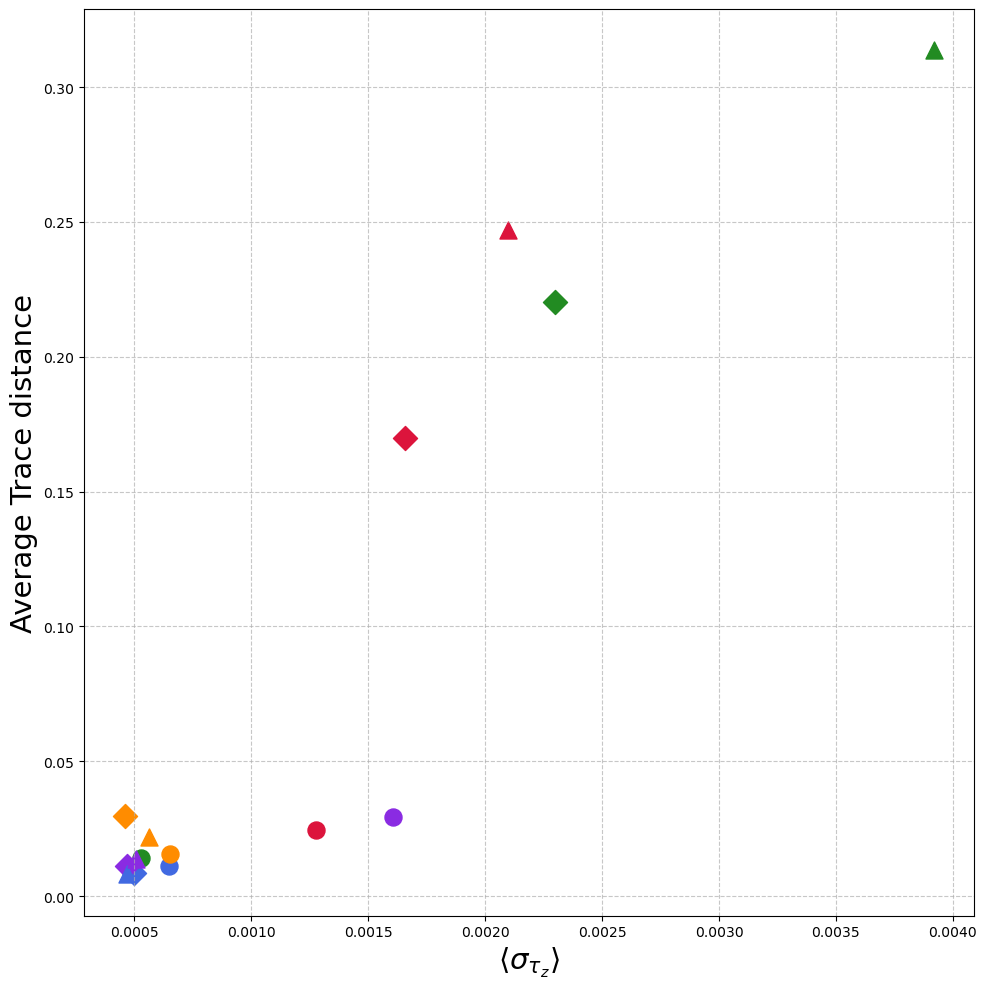

In [102]:
def compute_distance_metrics(pops, N=12, late_time_fraction=0.25):
    raw_data = pops
    reference_p = np.mean(pops[0])
    late_time_td = []
    late_time_kl = []
    
    for t in range(500 - 100, 500):
        pops_at_t = raw_data[t, :]  # Population at time t for single simulation
        
        # Calculate trace distance
        td_t = np.abs(pops_at_t - reference_p).sum()
        late_time_td.append(td_t)
        
        # Calculate KL divergence with numerical stability
        epsilon = 1e-10
        p_safe = np.clip(pops_at_t, epsilon, 1-epsilon)
        ref_p_safe = np.clip(reference_p, epsilon, 1-epsilon)
        kl_div = p_safe * np.log(p_safe / ref_p_safe) + (1 - p_safe) * np.log((1 - p_safe) / (1 - ref_p_safe))
        late_time_kl.append(np.sum(kl_div))
    
    # Return both metrics
    #return np.mean(late_time_kl)
    return np.mean(late_time_td)
        
def create_trace_distance_scatter(pops_list, tzs):
    """
    Create a scatter plot of trace distance vs tzs with CSP inset.
    
    Parameters:
    - pops_list: List of population datasets
      Structure: List of 4 CSs, each containing 5 rules' populations
    - tzs: List of 4 datasets (CS), each containing 5 rules' temperature values
    """
    colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    markers = ["o", "D", "^", "s", "*"]
    
    # Create main figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Compute and plot trace distances
    for cs_idx, (cs_pops, cs_tzs) in enumerate(zip(pops_list, tzs)):
        if cs_idx<3:
            trace_d_r1=0
            for rule_idx, (rule_pops, rule_tz) in enumerate(zip(cs_pops, cs_tzs)):
                trace_d_r1=compute_distance_metrics(cs_pops[0])
                print(len(rule_pops))
                trace_distance = compute_distance_metrics(rule_pops)
                print(trace_distance)
                
                # Scatter plot
                ax.scatter(rule_tz,trace_distance, 
                           color=colors[rule_idx], 
                           marker=markers[cs_idx], 
                           s=150, 
                           label=f'Rule {rule_idx+1}, CS {cs_idx+1}')
    
    ax.set_xlabel(r'$\langle\sigma_{\tau_z}\rangle$',fontsize=21)
    ax.set_ylabel('Average Trace distance',fontsize=21)
    #ax.set_title('Trace Distance vs Normalized Temperature')
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("scatter_trace_dist_sigma_tau_z_C4.png",bbox_inches="tight",dpi=300)
    
    plt.show()
    

                
tz_datasets = [
    [late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_th)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_th)[0]], 15))],
    [late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v1)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v1)[0]], 15))],
    [late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v2)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v2)[0]], 15))],
    [late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_random_c4_pure)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_pure)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_pure)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_pure)[0]], 15)),
    late_time_std(full_sim_tz([ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_pure)[0]], 15))]
    ]
create_trace_distance_scatter(pops_datasets,tz_datasets )

IC CS1, Rule R1: Components needed for 80% variance: 2
IC CS2, Rule R1: Components needed for 80% variance: 2
IC CS3, Rule R1: Components needed for 80% variance: 2
IC CSP, Rule R1: Components needed for 80% variance: 6
IC CS1, Rule R2: Components needed for 80% variance: 2
IC CS2, Rule R2: Components needed for 80% variance: 2
IC CS3, Rule R2: Components needed for 80% variance: 2
IC CSP, Rule R2: Components needed for 80% variance: 6
IC CS1, Rule R3: Components needed for 80% variance: 2
IC CS2, Rule R3: Components needed for 80% variance: 2
IC CS3, Rule R3: Components needed for 80% variance: 2
IC CSP, Rule R3: Components needed for 80% variance: 6
IC CS1, Rule R4: Components needed for 80% variance: 2
IC CS2, Rule R4: Components needed for 80% variance: 2
IC CS3, Rule R4: Components needed for 80% variance: 2
IC CSP, Rule R4: Components needed for 80% variance: 6
IC CS1, Rule R5: Components needed for 80% variance: 2
IC CS2, Rule R5: Components needed for 80% variance: 2
IC CS3, Ru

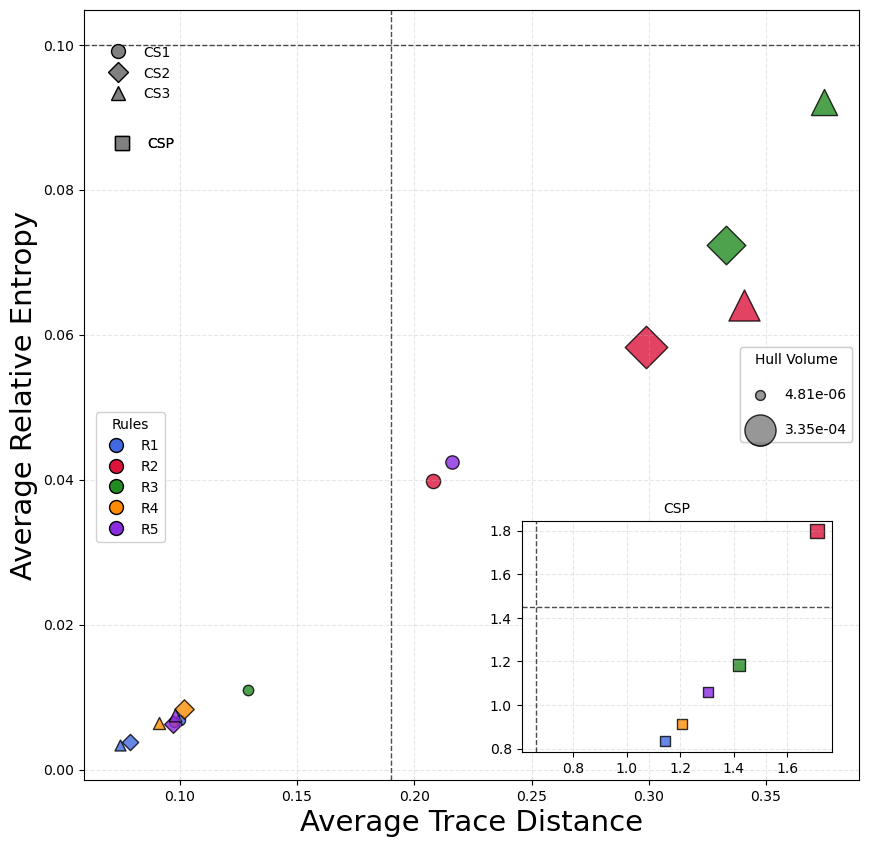

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter

n = 200
data = {
    'R1': {
        'CS1': [trial[n:] for trial in pops_random_c4_th],
        'CS2': [trial[n:] for trial in pops_random_c4_v1],
        'CS3': [trial[n:] for trial in pops_random_c4_v2],
        'CSP': [trial[n:] for trial in pops_random_c4_pure]
    },
    'R2': {
        'CS1': [trial[n:] for trial in pops_greedy_c4_th],
        'CS2': [trial[n:] for trial in pops_greedy_c4_v1],
        'CS3': [trial[n:] for trial in pops_greedy_c4_v2],
        'CSP': [trial[n:] for trial in pops_greedy_c4_pure]        
    },
    'R3': {
        'CS1': [trial[n:] for trial in pops_landmax_c4_th],
        'CS2': [trial[n:] for trial in pops_landmax_c4_v1],
        'CS3': [trial[n:] for trial in pops_landmax_c4_v2],
        'CSP': [trial[n:] for trial in pops_landmax_c4_pure] 
    },
    'R4': {
        'CS1': [trial[n:] for trial in pops_strongmax_c4_th],
        'CS2': [trial[n:] for trial in pops_strongmax_c4_v1],
        'CS3': [trial[n:] for trial in pops_strongmax_c4_v2],
        'CSP': [trial[n:] for trial in pops_strongmax_c4_pure]
    },
    'R5': {
        'CS1': [trial[n:] for trial in pops_mimic_c4_th],
        'CS2': [trial[n:] for trial in pops_mimic_c4_v1],
        'CS3': [trial[n:] for trial in pops_mimic_c4_v2],
        'CSP': [trial[n:] for trial in pops_mimic_c4_pure] 
    }
    # Add more rules as needed
}
n=10
data_10_steps = {
    'R1': {
        'CS1': [trial[:n] for trial in pops_random_c4_th],
        'CS2': [trial[:n] for trial in pops_random_c4_v1],
        'CS3': [trial[:n] for trial in pops_random_c4_v2]
    },
    'R2': {
        'CS1': [trial[:n] for trial in pops_greedy_c4_th],
        'CS2': [trial[:n] for trial in pops_greedy_c4_v1],
        'CS3': [trial[:n] for trial in pops_greedy_c4_v2]
    },
    'R3': {
        'CS1': [trial[:n] for trial in pops_landmax_c4_th],
        'CS2': [trial[:n] for trial in pops_landmax_c4_v1],
        'CS3': [trial[:n] for trial in pops_landmax_c4_v2]
    },
    'R4': {
        'CS1': [trial[:n] for trial in pops_strongmax_c4_th],
        'CS2': [trial[:n] for trial in pops_strongmax_c4_v1],
        'CS3': [trial[:n] for trial in pops_strongmax_c4_v2]
    },
    'R5': {
        'CS1': [trial[:n] for trial in pops_mimic_c4_th],
        'CS2': [trial[:n] for trial in pops_mimic_c4_v1],
        'CS3': [trial[:n] for trial in pops_mimic_c4_v2]
    }
    # Add more rules as needed
}



def preprocess_data(data_dict, structure='time_first'):
    """
    Preprocess the data to get the correct structure for PCA.
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary of rules, each containing a dictionary of ICs, each containing raw data
    structure : str
        'time_first' if data is organized as (trials, time_steps, variables)
        'trial_first' if data is organized as (time_steps, trials, variables)
    
    Returns:
    --------
    processed_data : dict
        Dictionary of rules, each containing a dictionary of ICs, each containing flattened data
    """
    processed_data = {}
    
    for rule, rule_data in data_dict.items():
        processed_data[rule] = {}
        
        for ic, ic_data in rule_data.items():
            data_array = np.array(ic_data)
            
            if structure == 'time_first':
                # Data is (trials, time_steps, variables)
                n_trials, n_time_steps, n_vars = data_array.shape
                # Reshape to (trials * time_steps, variables)
                flattened = data_array.reshape(n_trials * n_time_steps, n_vars)
            else:  # 'trial_first'
                # Data is (time_steps, trials, variables)
                n_time_steps, n_trials, n_vars = data_array.shape
                # Transpose to (trials, time_steps, variables)
                data_array = data_array.transpose(1, 0, 2)
                # Reshape to (trials * time_steps, variables)
                flattened = data_array.reshape(n_trials * n_time_steps, n_vars)
            
            processed_data[rule][ic] = flattened
    
    return processed_data

def manual_uncentered_pca(data):
    """
    Perform uncentered PCA manually.
    
    Parameters:
    -----------
    data : ndarray
        Data matrix of shape (n_samples, n_features)
    
    Returns:
    --------
    eigenvalues : ndarray
        Eigenvalues in descending order
    eigenvectors : ndarray
        Eigenvectors corresponding to eigenvalues
    projections : ndarray
        Data projected onto eigenvectors
    explained_variance_ratio : ndarray
        Ratio of explained variance for each component
    """
    # Compute covariance matrix without centering
    cov_matrix = data.T @ data / (data.shape[0] - 1)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Project data onto eigenvectors
    projections = data @ eigenvectors
    
    # Calculate explained variance ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    
    return eigenvalues, eigenvectors, projections, explained_variance_ratio

def calculate_robust_volume(points, percentile=95):
    """
    Calculate a robust estimate of the convex hull volume by:
    1. Removing outliers based on percentile
    2. Computing the convex hull volume if enough points remain
    
    Parameters:
    -----------
    points : ndarray
        Points in n-dimensional space
    percentile : float
        Percentile threshold for outlier removal
    
    Returns:
    --------
    volume : float
        Robust estimate of convex hull volume
    """
    from scipy.spatial import ConvexHull
    
    if len(points) < 4:
        return 0.0
    
    try:
        # Calculate distances from centroid
        centroid = np.mean(points, axis=0)
        distances = np.sqrt(np.sum((points - centroid)**2, axis=1))
        
        # Determine threshold for outlier removal
        threshold = np.percentile(distances, percentile)
        
        # Remove outliers
        filtered_points = points[distances <= threshold]
        
        # Calculate convex hull volume if enough points remain
        if len(filtered_points) >= 4:
            hull = ConvexHull(filtered_points)
            return hull.volume
        else:
            return 0.0
    except Exception as e:
        print(f"Error in volume calculation: {e}")
        return 0.0

def extract_late_time_metrics(data_dict, ics, rules, N=12, n_components=3, structure='time_first', late_time_fraction=0.25):
    """
    Extract late-time metrics for each rule and IC.
    Returns a list of dictionaries with KL divergence, trace distance, and hull volume.
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary of rules, each containing a dictionary of ICs, each containing raw data
    ics : list
        List of initial conditions to analyze
    rules : list
        List of rules to analyze
    N : int
        Number of states in the system
    n_components : int
        Number of PCA components to use
    structure : str
        'time_first' or 'trial_first' for data organization
    late_time_fraction : float
        Fraction of time steps to consider as late time (from the end)
        
    Returns:
    --------
    late_time_metrics : list
        List of dictionaries, one per rule, each containing KL divergence, trace distance, 
        and hull volume for each IC
    """
    import numpy as np
    
    # Preprocess data with the provided function
    processed_data = preprocess_data(data_dict, structure)
    
    # Filter out ICs that don't have enough rules
    available_ics = []
    for ic in ics:
        available_rules = [rule for rule in rules if ic in data_dict.get(rule, {})]
        if len(available_rules) >= 2:
            available_ics.append(ic)
        else:
            print(f"Skipping IC {ic}: not available in enough rules")
    
    if not available_ics:
        print("No ICs available in enough rules to plot.")
        return []
    
    # List to store metrics for each rule
    late_time_metrics = []
    
    # Process each rule
    for rule_idx, rule in enumerate(rules):
        if rule not in data_dict:
            print(f"Rule {rule} not in data dictionary. Skipping.")
            continue
            
        # Initialize dictionaries for this rule's metrics
        hull_volumes = {}
        kl_divergence = {}
        trace_distance = {}
        
        # Process each IC
        for ic in available_ics:
            if ic not in data_dict[rule]:
                print(f"IC {ic} not available for rule {rule}. Skipping.")
                continue
                
            # Extract raw data
            raw_data = np.array(data_dict[rule][ic])
            
            if structure == 'time_first':
                # Data is (trials, time_steps, variables)
                n_trials, n_time_steps, n_vars = raw_data.shape
            else:  # 'trial_first'
                # Data is (time_steps, trials, variables)
                n_time_steps, n_trials, n_vars = raw_data.shape
                # Transpose to (trials, time_steps, variables)
                raw_data = raw_data.transpose(1, 0, 2)
            
            # Combine data from all rules for this IC for PCA fitting
            available_rules = [r for r in rules if ic in data_dict.get(r, {})]
            combined_data = np.vstack([processed_data[r][ic] for r in available_rules])
            
            # Apply manual uncentered PCA
            eigenvalues, eigenvectors, combined_projections, explained_variance_ratio = manual_uncentered_pca(combined_data)
            
            # Find how many components needed for 90% variance
            cumulative_variance = np.cumsum(explained_variance_ratio)
            n_components_90 = np.argmax(cumulative_variance >= 0.5) + 2
            print(f"IC {ic}, Rule {rule}: Components needed for 80% variance: {n_components_90}")
            
            # Get projections for this rule with the required number of components
            rule_data = processed_data[rule][ic]
            projections = rule_data @ eigenvectors[:, :n_components_90]
            
            # Calculate the number of time steps considered "late time"
            late_time_steps = int(n_time_steps * late_time_fraction)
            
            # Calculate metrics for late time only
            # 1. Calculate convex hull volume
            late_time_volumes = []
            for t in range(n_time_steps - late_time_steps, n_time_steps):
                # Get all points at time step t across trials
                time_points = []
                for trial in range(n_trials):
                    time_idx = trial * n_time_steps + t
                    if time_idx < len(projections):
                        time_points.append(projections[time_idx])
                
                time_points = np.array(time_points)
                volume = calculate_robust_volume(time_points)
                late_time_volumes.append(volume)
            
            # Average volume over late time
            hull_volumes[ic] = np.mean(late_time_volumes)
            
            # 2. Calculate KL divergence (relative entropy)
            late_time_rel_entropy = []
            for t in range(n_time_steps - late_time_steps, n_time_steps):
                pops_at_t = raw_data[:, t, :]  # Populations across all simulations at time t
                reference_p = ((N-1) * 0.1 + 0.4) / N
                
                # Vectorized calculation of KL divergence (relative entropy)
                # Avoid log(0) errors with small epsilon
                epsilon = 1e-10
                p_safe = np.clip(pops_at_t, epsilon, 1-epsilon)
                ref_p_safe = np.clip(reference_p, epsilon, 1-epsilon)
                
                # Calculate KL divergence: p*log(p/q) + (1-p)*log((1-p)/(1-q))
                kl_div = p_safe * np.log(p_safe / ref_p_safe) + (1 - p_safe) * np.log((1 - p_safe) / (1 - ref_p_safe))
                mean_kl = np.mean(np.sum(kl_div, axis=1))
                late_time_rel_entropy.append(mean_kl)
            
            # Average KL divergence over late time
            kl_divergence[ic] = np.mean(late_time_rel_entropy)
            
            # 3. Calculate trace distance
            late_time_td = []
            for t in range(n_time_steps - late_time_steps, n_time_steps):
                pops_at_t = raw_data[:, t, :]  # Populations across all simulations at time t
                reference_p = ((N-1) * 0.1 + 0.4) / N
                td_t = np.abs(pops_at_t - reference_p).sum(axis=1)
                late_time_td.append(np.mean(td_t))
            
            # Average trace distance over late time
            trace_distance[ic] = np.mean(late_time_td)
        
        # Store all metrics for this rule
        rule_metrics = {
            'rule': rule,
            'hull_volumes': hull_volumes,
            'kl_divergence': kl_divergence,
            'trace_distance': trace_distance
        }
        
        late_time_metrics.append(rule_metrics)
    
    return late_time_metrics

def plot_kl_vs_trace_scatter(late_time_means, rules, inset_ics=None):
    """
    Create a scatter plot with KL divergence on y-axis, trace distance on x-axis,
    and convex hull volume represented by marker size, with an inset for CSP data.
    
    Parameters:
    -----------
    late_time_means : list
        List of dictionaries containing metrics for each rule
    rules : list
        List of rule names corresponding to the late_time_means
    inset_ics : list
        List of initial conditions to be plotted in an inset
    """
    import matplotlib.pyplot as plt
    from matplotlib.ticker import ScalarFormatter
    import numpy as np
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    # Set up colors for each rule
    rule_colors = {
        'R1': '#4169E1',   # Blue
        'R2': '#DC143C',   # Orange
        'R3': '#228B22',   # Green
        'R4': '#FF8C00',   # Red
        'R5': '#8A2BE2'    # Purple
    }
    
    # Set up markers for each IC - using the actual IC keys from your data
    ic_markers = {
        'CS1': 'o',      # Circle
        'CS2': 'D',      # Diamond
        'CS3': '^',      # Triangle
        'CSP': 's'       # Square
    }
    
    # Create a figure with a larger right margin to accommodate the legend
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Find the min and max hull volumes to scale marker sizes appropriately
    min_hull = float('inf')
    max_hull = float('-inf')
    
    # First, determine what ICs are actually in the data
    all_ics = set()
    for rule_means in late_time_means:
        hull_volumes = rule_means['hull_volumes']
        for ic in hull_volumes.keys():
            all_ics.add(ic)
    
    print(f"Found these ICs in data: {all_ics}")
    
    # Find min and max hull volumes
    for rule_means in late_time_means:
        hull_volumes = rule_means['hull_volumes']
        for ic, value in hull_volumes.items():
            # Convert numpy float to Python float if needed
            if hasattr(value, 'item'):
                value = value.item()
            min_hull = min(min_hull, value)
            max_hull = max(max_hull, value)
    
    print(f"Hull volume range: {min_hull} to {max_hull}")
    
    # Size scaling function
    def scale_size(hull_volume):
        # Convert numpy float to Python float if needed
        if hasattr(hull_volume, 'item'):
            hull_volume = hull_volume.item()
            
        # Scale between 50 and 500 for better visibility
        min_size = 50
        max_size = 500
        # Add a small value to avoid division by zero
        if max_hull == min_hull:
            return (min_size + max_size) / 2
        return min_size + (hull_volume - min_hull) / (max_hull - min_hull) * (max_size - min_size)
    
    # Track handles for legend
    rule_handles = []
    rule_labels = []
    ic_handles = []
    ic_labels = []
    inset_ic_handles = []
    inset_ic_labels = []
    
    # Create an inset axes for the CSP data
    if inset_ics:
        axins = inset_axes(ax, width="40%", height="30%", loc="lower right", borderpad=2)

    
    # Create the scatter plot for each rule and IC
    for i, (rule_means, rule) in enumerate(zip(late_time_means, rules)):
        hull_volumes = rule_means['hull_volumes']
        kl_divergence = rule_means['kl_divergence']
        trace_distance = rule_means['trace_distance']
        
        for ic in hull_volumes.keys():
            if ic in kl_divergence and ic in trace_distance:
                # Calculate marker size based on hull volume
                size = scale_size(hull_volumes[ic])
                
                # Get marker for this IC
                marker = ic_markers.get(ic, 'o')  # Default to circle if not found
                
                # Determine whether to plot in main axes or inset
                target_ax = axins if inset_ics and ic in inset_ics else ax
                
                # Plot point
                point = target_ax.scatter(
                    trace_distance[ic],  # x-axis: trace distance
                    kl_divergence[ic],   # y-axis: KL divergence
                    s=size,              # size: hull volume
                    color=rule_colors.get(rule, 'black'),
                    marker=marker,
                    alpha=0.8,
                    edgecolors='black',
                    linewidth=1,
                    label=f'{rule}, {ic}'
                )
                
                # Track handles for custom legend
                if inset_ics and ic in inset_ics:
                    # For inset legend
                    if ic not in inset_ic_labels:
                        inset_ic_handles.append(plt.Line2D([0], [0], color='gray', marker=marker, 
                                                 linestyle='', markersize=10, markeredgecolor='black'))
                        inset_ic_labels.append(ic)
                elif ic not in ic_labels:
                    # For main plot legend
                    ic_handles.append(plt.Line2D([0], [0], color='gray', marker=marker, 
                                             linestyle='', markersize=10, markeredgecolor='black'))
                    ic_labels.append(ic)
                
                if rule not in rule_labels:
                    rule_handles.append(plt.Line2D([0], [0], color=rule_colors.get(rule, 'black'), marker='o', 
                                               linestyle='', markersize=10, markeredgecolor='black'))
                    rule_labels.append(rule)
    
    # Style the inset axes
    if inset_ics:
        axins.set_title("CSP", fontsize=10)
        axins.grid(True, linestyle='--', alpha=0.3)
        axins.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
        axins.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    
    
    # Set titles and labels
    ax.set_xlabel('Average Trace Distance', fontsize=21)
    ax.set_ylabel('Average Relative Entropy', fontsize=21)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Set up formatting for axes
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    
    # Add reference lines
    ax.axvline(x=0.19, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")
    ax.axhline(y=0.1, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")
    
    if inset_ics:
        axins.axvline(x=0.66, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")
        axins.axhline(y=1.45, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")
    
    # Create a size legend - place it directly on the plot
    size_handles = []
    size_labels = []
    size_values = [min_hull, max_hull]
    
    for val in size_values:
        size_handles.append(plt.scatter([], [], s=scale_size(val), color='gray', alpha=0.8, edgecolors='black'))
        size_labels.append(f'{val:.2e}')  # Using scientific notation for small values
        
    # Place the size legend inside the plot in the lower right corner
    # This ensures it will be visible regardless of how the figure is saved
    size_legend = ax.legend(size_handles, size_labels,
                       loc='center right',  # Position inside the plot
                       fontsize=10, title="Hull Volume", framealpha=0.9,
                       scatterpoints=1, labelspacing=1.5, ncol=1)
    ax.add_artist(size_legend)
    ax.add_artist(size_legend)
    
    # Rule legend (colors)
    if rule_handles:
        rule_legend = ax.legend(rule_handles, rule_labels,
                               loc='lower center', bbox_to_anchor=(0.06, 0.3),
                               fontsize=10, title="Rules", framealpha=0.9, ncol=1)
        ax.add_artist(rule_legend)
    
    # IC legend (markers) for main plot
    if ic_handles:
        ic_legend = ax.legend(ic_handles, ic_labels,
                             loc='upper left', bbox_to_anchor=(0.01, 0.97),
                             fontsize=10, title="", framealpha=0, ncol=1)
        ax.add_artist(ic_legend)
    
    # IC legend for inset plot
    if inset_ics and inset_ic_handles:
        inset_ic_legend = ax.legend(inset_ic_handles, inset_ic_labels,
                                   loc='lower center', bbox_to_anchor=(0.073, 0.8),
                                   fontsize=10, title="", framealpha=0, ncol=1)
        ax.add_artist(inset_ic_legend)
    
    # Adjust layout to make room for legends on the right
    
    # Remove tight_layout() call as it conflicts with manually set margins
    
    # Save the figure - remove bbox_inches parameter which might be causing issues
    plt.savefig("kl_vs_trace_scatter_with_inset_c4.png", bbox_inches='tight',dpi=300)
    
    return fig
    


# Example of how to update the run_full_analysis function
def run_full_analysis(data_dict, ics, rules, inset_ics=None, N=12, structure='time_first'):
    """
    Run the full analysis pipeline:
    1. Extract late time metrics
    2. Create and save the scatter plot with inset
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary of rules, each containing a dictionary of ICs, each containing raw data
    ics : list
        List of initial conditions to analyze
    rules : list
        List of rules to analyze
    inset_ics : list
        List of initial conditions to plot in inset
    N : int
        Number of states in the system
    structure : str
        'time_first' or 'trial_first' for data organization
    
    Returns:
    --------
    fig : Figure
        The generated scatter plot figure
    """
    # Extract late time metrics for main ICs
    late_time_metrics = extract_late_time_metrics(
        data_dict, ics + (inset_ics if inset_ics else []), rules, N=N, structure=structure, late_time_fraction=0.25
    )
    
    # Create and save scatter plot with inset
    fig = plot_kl_vs_trace_scatter(late_time_metrics, rules, inset_ics)
    
    return fig, late_time_metrics


ics = ['CS1', 'CS2', 'CS3']
inset_ics = ['CSP']
rules = ['R1', 'R2', 'R3', 'R4', 'R5']
fig, metrics = run_full_analysis(data, ics, rules, inset_ics, N=12, structure='time_first')

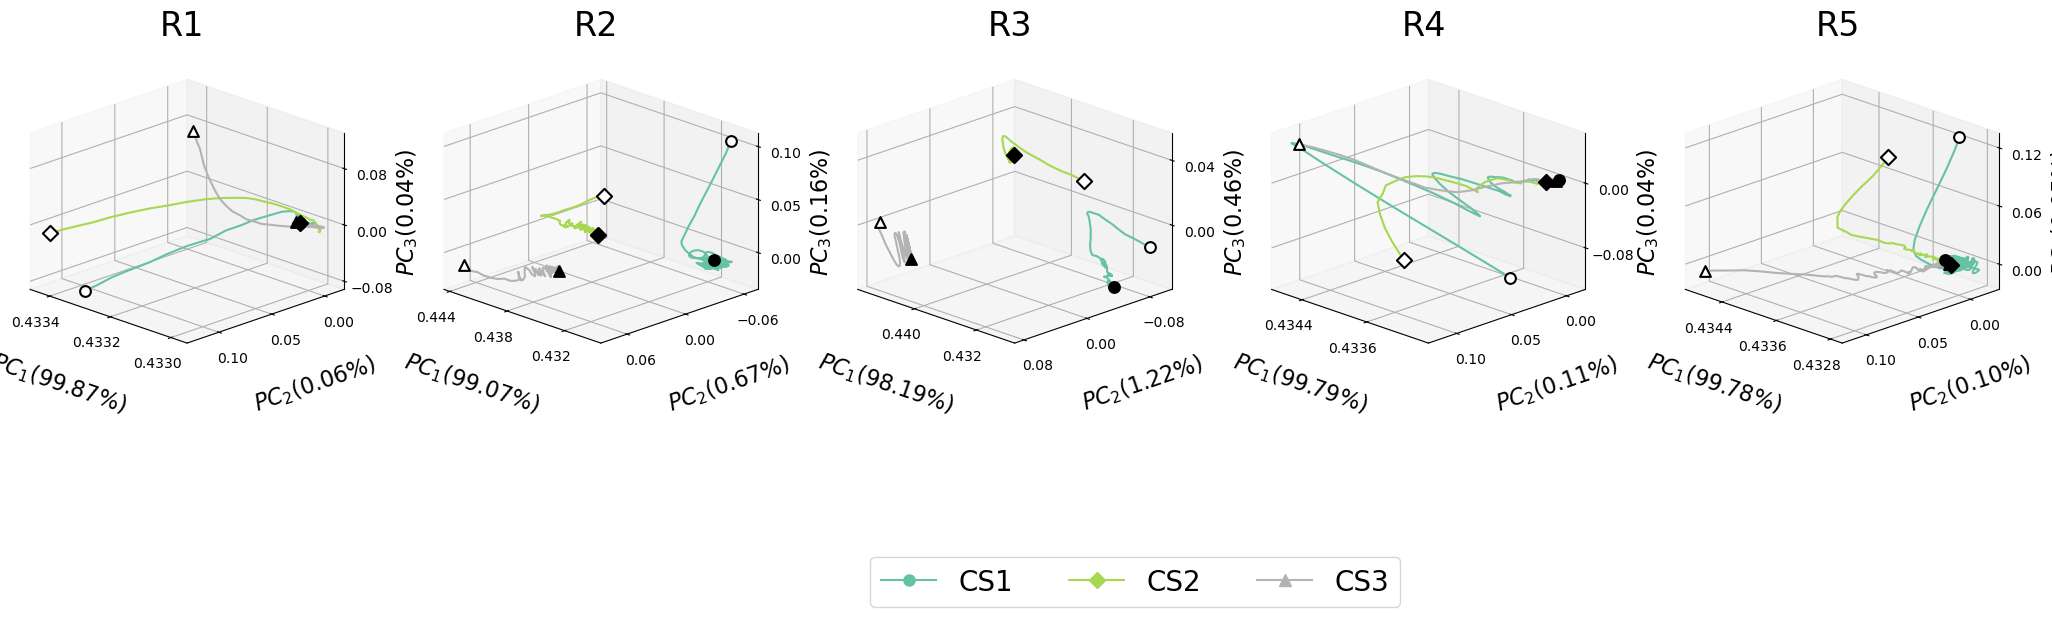

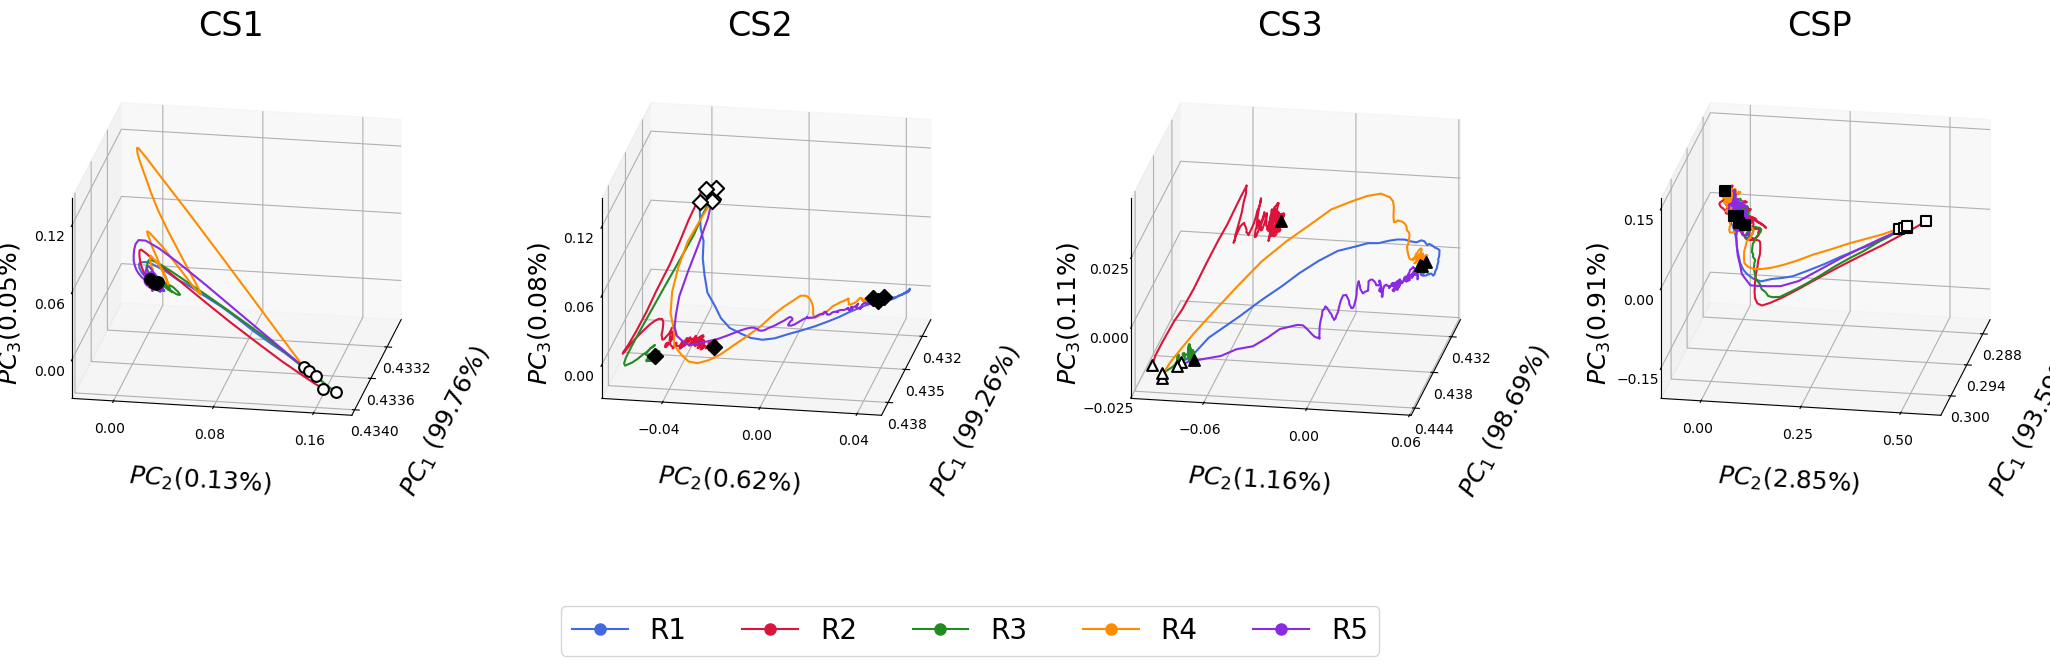

In [42]:

def ensemble_averaged_one_point_measures_mean_std(datasets):
    # Assuming datasets is a list of 100 datasets, where each dataset is a 2D array of shape (100, N)
    # Stack datasets into a 3D array
    stacked_data = np.stack(datasets)  # Shape (100, 100, N)

    # Take the ensemble average along the first axis (averaging over all datasets)
    ensemble_average = np.mean(stacked_data, axis=0)  # Shape (100, N)

    # Calculate the standard deviation along the first axis
    ensemble_std = np.std(stacked_data, axis=0) 
    return (ensemble_average, ensemble_std)

pops_random_c4_th_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_random_c4_th)
pops_greedy_c4_th_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_th)
pops_mimic_c4_th_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_th)
pops_landmax_c4_th_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_th)
pops_strongmax_c4_th_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_th)

pops_random_c4_v1_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v1)
pops_greedy_c4_v1_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v1)
pops_mimic_c4_v1_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v1)
pops_landmax_c4_v1_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v1)
pops_strongmax_c4_v1_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v1)

pops_random_c4_v2_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_random_c4_v2)
pops_greedy_c4_v2_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_v2)
pops_mimic_c4_v2_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_v2)
pops_landmax_c4_v2_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_v2)
pops_strongmax_c4_v2_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_v2)

pops_random_c4_pure_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_random_c4_pure)
pops_greedy_c4_pure_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_greedy_c4_pure)
pops_mimic_c4_pure_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_mimic_c4_pure)
pops_landmax_c4_pure_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_landmax_c4_pure)
pops_strongmax_c4_pure_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_strongmax_c4_pure)
n=11
data_ens_avg = {
        'R1': {
            'CS1': pops_random_c4_th_ens_avg[0][n:],
            'CS2': pops_random_c4_v1_ens_avg[0][n:],
            'CS3': pops_random_c4_v2_ens_avg[0][n:],
            'CSP': pops_random_c4_pure_ens_avg[0][n:]
            },
        'R2': {
            'CS1': pops_greedy_c4_th_ens_avg[0][n:],
            'CS2': pops_greedy_c4_v1_ens_avg[0][n:],
            'CS3': pops_greedy_c4_v2_ens_avg[0][n:],  
            'CSP': pops_greedy_c4_pure_ens_avg[0][n:]},
         'R3': {
            'CS1': pops_landmax_c4_th_ens_avg[0][n:],
            'CS2': pops_landmax_c4_v1_ens_avg[0][n:],
            'CS3': pops_landmax_c4_v2_ens_avg[0][n:],
             'CSP': pops_landmax_c4_pure_ens_avg[0][n:]},
         'R4': {
            'CS1': pops_strongmax_c4_th_ens_avg[0][n:],
            'CS2': pops_strongmax_c4_v1_ens_avg[0][n:],
            'CS3': pops_strongmax_c4_v2_ens_avg[0][n:],
         'CSP': pops_strongmax_c4_pure_ens_avg[0][n:]},
         'R5': {
            'CS1': pops_mimic_c4_th_ens_avg[0][n:],
            'CS2': pops_mimic_c4_v1_ens_avg[0][n:],
            'CS3': pops_mimic_c4_v2_ens_avg[0][n:],
         'CSP': pops_mimic_c4_pure_ens_avg[0][n:]}
        # Add more rules as needed
            }

def plot_uncentered_pca_comparison(data_dict, rules, ics, n_components=3, structure='time_first'):
    """
    Create comprehensive visualization with uncentered PCA:
    - First figure: Uncentered PCA across ICs for each rule (all rules in one row)
    - Second figure: Uncentered PCA across rules for each IC (all ICs in one row)
    
    Args:
        data_dict: Dictionary with structure rule -> ic -> single trajectory
        rules: List of rules to compare
        ics: List of IC indices to analyze
        n_components: Number of PCA components
        structure: Data structure format ('time_first', 'trial_first', or 'qubit_first')
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.gridspec as gridspec
    from matplotlib.lines import Line2D
    
    # Filter ICs for PCA per rule (only use CS1, CS2, CS3)
    ics_for_per_rule = [ic for ic in ics if ic in ['CS1', 'CS2', 'CS3']]
    
    # Map IC names to more descriptive labels
    ic_name_map = {'CS1': "CS1", 'CS2': "CS2", 'CS3': "CS3", 'CSP': "CSP"}
    
    # Specific colors for ICs and rules
    ic_colors = ["#66c4a5","#a6d850","#b3b3b3","#6B8FAD"]
    rule_colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    
    # Map colors to rules and ICs
    rule_color_map = {rule: rule_colors[i % len(rule_colors)] for i, rule in enumerate(rules)}
    ic_color_map = {ic: ic_colors[i % len(ic_colors)] for i, ic in enumerate(ics)}
    
    # Define marker shapes for ICs
    ic_marker_map = {'CS1': 'o', 'CS2': 'D', 'CS3': '^', 'CSP': 's'}
    
    # Preprocess data to ensure consistent format
    processed_dict = {}
    n_time_steps = None
    n_qubits = None
    
    for rule in rules:
        processed_dict[rule] = {}
        for ic in ics:
            if ic in data_dict.get(rule, {}):
                # Get the data (ensemble-averaged trajectory)
                data = np.array(data_dict[rule][ic])
                
                # Determine time steps and qubits if not already set
                if n_time_steps is None or n_qubits is None:
                    if structure == 'time_first':  # (time_steps, n_qubits)
                        n_time_steps = data.shape[0]
                        n_qubits = data.shape[1]
                    elif structure == 'qubit_first':  # (n_qubits, time_steps)
                        n_qubits = data.shape[0]
                        n_time_steps = data.shape[1]
                    else:  # trial_first
                        n_time_steps = data.shape[1]
                        n_qubits = data.shape[2]  
                
                # Process according to structure
                if structure == 'qubit_first':  # (n_qubits, time_steps)
                    processed_dict[rule][ic] = data.T
                elif structure == 'time_first':  # Already (time_steps, features)
                    processed_dict[rule][ic] = data
                else:  # trial_first, squeeze out singleton dimension
                    processed_dict[rule][ic] = np.squeeze(data)
    
    # Function to compute uncentered PCA
    def uncentered_pca(data, n_components=3):
        # Compute uncentered second moment matrix
        sigma = (1/data.shape[0]) * data.T @ data
        
        # Compute eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(sigma)
        
        # Sort by decreasing eigenvalue
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Select top components
        components = eigenvectors[:, :n_components]
        
        # Project data onto components
        projections = data @ components
        
        # Calculate explained variance ratio
        explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
        
        return projections, components, explained_variance_ratio
    
    # ---- FIRST FIGURE: Uncentered PCA across ICs for each rule (all in one row) ----
    fig_pca_by_rule = plt.figure(figsize=(25, 6))
    gs_pca_by_rule = gridspec.GridSpec(1, len(rules))
    gs_pca_by_rule.update(wspace=0.2, hspace=0.4)
    
    # Create custom legend elements for this figure
    legend_elements_by_rule = []
    
    for r_idx, rule in enumerate(rules):
        ax = fig_pca_by_rule.add_subplot(gs_pca_by_rule[0, r_idx], projection='3d')
        ax.dist = 11
        
        # Get all ICs for this rule (only the specified ones for per-rule plot)
        available_ics = [ic for ic in ics_for_per_rule if ic in processed_dict[rule]]
        
        if not available_ics:
            # For 3D axes, we need to provide x, y, z coordinates for the text
            ax.text(0, 0, 0, f"No data for rule {rule}", 
                   horizontalalignment='center', verticalalignment='center')
            ax.set_title(f"Rule: {rule}")
            continue
        
        # Combine data from all ICs for PCA fitting
        combined_data = np.vstack([processed_dict[rule][ic] for ic in available_ics])
        
        # Perform uncentered PCA
        combined_projections, _, explained_variance_ratio = uncentered_pca(combined_data, n_components)
        
        # Split projections back by IC
        ic_projections = {}
        start_idx = 0
        for ic in available_ics:
            ic_data_size = processed_dict[rule][ic].shape[0]
            end_idx = start_idx + ic_data_size
            ic_projections[ic] = combined_projections[start_idx:end_idx]
            start_idx = end_idx
        
        # Plot each IC trajectory
        for ic in available_ics:
            proj = ic_projections[ic]
            color = ic_color_map[ic]
            marker = ic_marker_map[ic]
            
            # Plot trajectory
            ax.plot(proj[:, 0], proj[:, 1], proj[:, 2], '-', 
                   linewidth=1.5, color=color, label=f'{ic_name_map[ic]}')
            
            # Add markers for start (unfilled) and end (filled) points
            ax.scatter(proj[0, 0], proj[0, 1], proj[0, 2], 
                      color='white', marker=marker, s=60, edgecolors='black', linewidth=1.5)
            ax.scatter(proj[-1, 0], proj[-1, 1], proj[-1, 2], 
                      color='black', marker=marker, s=60, edgecolors='black', linewidth=1.5)
            
            # Add to legend elements (only once)
            if r_idx == 0:
                legend_elements_by_rule.append(Line2D([0], [0], color=color, marker=marker, 
                                             linestyle='-', linewidth=1.5, markersize=8,
                                             label=f'{ic_name_map[ic]}'))
        
        # Set labels and title
        ax.set_xlabel(r'$PC_1$'f'({explained_variance_ratio[0]:.2%})',fontsize=16)
        ax.set_ylabel(r'$PC_2$'f'({explained_variance_ratio[1]:.2%})',fontsize=16)
        ax.set_zlabel(r'$PC_3$'f'({explained_variance_ratio[2]:.2%})',fontsize=16)
        ax.zaxis.set_rotate_label(False)
        ax.zaxis.label.set_rotation(90)
        ax.zaxis.label.set_horizontalalignment('center')
        ax.set_title(f'{rule}',fontsize=24)
        ax.view_init(elev=20, azim=135)
        ax.set_proj_type('ortho')

        ax.xaxis.labelpad = 20
        ax.yaxis.labelpad = 20
        ax.zaxis.labelpad = 5
        
        # Reduce number of ticks
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.zaxis.set_major_locator(plt.MaxNLocator(3))
    
    # Add a single legend for all subplots
    fig_pca_by_rule.legend(handles=legend_elements_by_rule, loc='lower center', 
                         bbox_to_anchor=(0.5, -0.15), ncol=len(ics_for_per_rule), fontsize=20)
    
    plt.subplots_adjust(bottom=0.15, right=0.85, left=0.05, top=0.9, wspace=0.3)
    plt.savefig('uncentered_pca_all_ics_per_rule_c4.png', dpi=300, bbox_inches='tight',pad_inches=1)
    
    # ---- SECOND FIGURE: Uncentered PCA across rules for each IC (all in one row) ----
    # Use the specific ICs: CS1, CS2, CS3, CSP
    specific_ics = ['CS1', 'CS2', 'CS3', 'CSP']
    available_specific_ics = [ic for ic in specific_ics if ic in ics]
    
    fig_pca_by_ic = plt.figure(figsize=(32, 6))
    gs_pca_by_ic = gridspec.GridSpec(1, len(available_specific_ics)+1)
    gs_pca_by_ic.update(wspace=0.2, hspace=0.1) 
    
    # Create custom legend elements for this figure
    legend_elements_by_ic = []
    
    for ic_idx, ic in enumerate(available_specific_ics):
        marker = ic_marker_map[ic]
        ax = fig_pca_by_ic.add_subplot(gs_pca_by_ic[0, ic_idx], projection='3d')
        ax.dist = 11
        
        # Get all rules that have this IC
        available_rules = [rule for rule in rules if ic in processed_dict.get(rule, {})]
        
        if not available_rules:
            # Fixed: Add z-coordinate for 3D text
            ax.text(0, 0, 0, f"No data for IC {ic_name_map[ic]}", 
                   horizontalalignment='center', verticalalignment='center')
            ax.set_title(f"IC: {ic_name_map[ic]}")
            continue
        
        # Combine data from all rules for PCA fitting
        combined_data = np.vstack([processed_dict[rule][ic] for rule in available_rules])
        
        # Perform uncentered PCA
        combined_projections, _, explained_variance_ratio = uncentered_pca(combined_data, n_components)
        
        # Split projections back by rule
        rule_projections = {}
        start_idx = 0
        for rule in available_rules:
            rule_data_size = processed_dict[rule][ic].shape[0]
            end_idx = start_idx + rule_data_size
            rule_projections[rule] = combined_projections[start_idx:end_idx]
            start_idx = end_idx
        
        # Plot each rule trajectory
        for rule in available_rules:
            proj = rule_projections[rule]
            color = rule_color_map[rule]
            
            # Plot trajectory
            ax.plot(proj[:, 0], proj[:, 1], proj[:, 2], '-', 
                   linewidth=1.5, color=color, label=f'Rule {rule}')
            
            # Add markers for start (unfilled) and end (filled) points
            ax.scatter(proj[0, 0], proj[0, 1], proj[0, 2], 
                      color='white', marker=marker, s=60, edgecolors='black', linewidth=1.5)
            ax.scatter(proj[-1, 0], proj[-1, 1], proj[-1, 2], 
                      color='black', marker=marker, s=60, edgecolors='black', linewidth=1.5)
            
            # Add to legend elements (only once per rule)
            if ic_idx == 0 and rule not in [elem.get_label().split()[-1] for elem in legend_elements_by_ic]:
                legend_elements_by_ic.append(Line2D([0], [0], color=color, marker='o', 
                                             linestyle='-', linewidth=1.5, markersize=8,
                                             label=f'{rule}'))
        ax.xaxis.labelpad = 20
        ax.yaxis.labelpad = 20
        ax.zaxis.labelpad = 10

        
        ax.set_xlabel(r'$PC_1$'f' ({explained_variance_ratio[0]:.2%})',fontsize=18)
        ax.set_ylabel(r'$PC_2$'f'({explained_variance_ratio[1]:.2%})',fontsize=18)
        ax.set_zlabel(r'$PC_3$'f'({explained_variance_ratio[2]:.2%})',fontsize=18)
        ax.zaxis.set_rotate_label(False)
        ax.zaxis.label.set_rotation(90)
        ax.zaxis.label.set_horizontalalignment('center')
        ax.set_title(f'{ic_name_map[ic]}',fontsize=24)
        ax.view_init(elev=20, azim=10)
        ax.set_proj_type('ortho')
        
        # Reduce number of ticks
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.zaxis.set_major_locator(plt.MaxNLocator(3))
    
    # Add a single legend for all subplots
    fig_pca_by_ic.legend(handles=legend_elements_by_ic, loc='lower center', 
                        bbox_to_anchor=(0.35, -0.15), ncol=len(rules), fontsize=20)
    
    plt.subplots_adjust(bottom=0.15, right=0.85, left=0.05, top=0.9, wspace=0.3)
    plt.savefig('uncentered_pca_all_rules_per_c4_ic.png', dpi=300, bbox_inches='tight',pad_inches=1)
    
    return fig_pca_by_rule, fig_pca_by_ic
N=12
reference_p = ((N-1) * 0.1 + 0.4) / N
fig, fig_entropy = plot_uncentered_pca_comparison(
     data_ens_avg, 
     rules=['R1', 'R2', 'R3','R4','R5'], 
     ics=['CS1', 'CS2', 'CS3','CSP'])

In [78]:
ens_avg_change_in_ext_work_random_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c2_th))[0]
ens_avg_change_in_ext_work_random_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c4_th))[0]
ens_avg_change_in_ext_work_greedy_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c2_th))[0]
ens_avg_change_in_ext_work_greedy_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c4_th))[0]
ens_avg_change_in_ext_work_mimic_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c2_th))[0]
ens_avg_change_in_ext_work_mimic_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c4_th))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c2_th))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c4_th))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c2_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c2_th))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c4_th=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c4_th))[0]

ens_avg_change_in_ext_work_random_c2_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c2_v1))[0]
ens_avg_change_in_ext_work_random_c4_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c4_v1))[0]
ens_avg_change_in_ext_work_greedy_c2_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c2_v1))[0]
ens_avg_change_in_ext_work_greedy_c4_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c4_v1))[0]
ens_avg_change_in_ext_work_mimic_c2_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c2_v1))[0]
ens_avg_change_in_ext_work_mimic_c4_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c4_v1))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c2_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c2_v1))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c4_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c4_v1))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c2_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c2_v1))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c4_v1=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c4_v1))[0]

ens_avg_change_in_ext_work_random_c2_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c2_v2))[0]
ens_avg_change_in_ext_work_random_c4_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_random_c4_v2))[0]
ens_avg_change_in_ext_work_greedy_c2_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c2_v2))[0]
ens_avg_change_in_ext_work_greedy_c4_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_greedy_c4_v2))[0]
ens_avg_change_in_ext_work_mimic_c2_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c2_v2))[0]
ens_avg_change_in_ext_work_mimic_c4_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_mimic_c4_v2))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c2_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c2_v2))[0]
ens_avg_change_in_ext_work_landscape_maximizes_c4_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_landscape_maximizes_c4_v2))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c2_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c2_v2))[0]
ens_avg_change_in_ext_work_strongest_maximizes_c4_v2=ensemble_averaged_one_point_measures_mean_std(change_in_ext_work_all_trials(ext_work_all_strongest_maximizes_c4_v2))[0]

NameError: name 'ext_work_all_random_c2_th' is not defined

In [ ]:
datas_th=[pops_mimic_c4_th,pops_strongest_maximizes_c4_th,pops_landscape_maximizes_c4_th,pops_greedy_c4_th,pops_random_c4_th]
datas_p=[pops_mimic_c4_pure,pops_strongest_maximizes_c4_pure,pops_landscape_maximizes_c4_pure,pops_greedy_c4_pure,pops_random_c4_pure]
datas_v1=[pops_mimic_c4_v1,pops_strongest_maximizes_c4_v1,pops_landscape_maximizes_c4_v1,pops_greedy_c4_v1,pops_random_c4_v1]
datas_v2=[pops_mimic_c4_v2,pops_strongest_maximizes_c4_v2,pops_landscape_maximizes_c4_v2,pops_greedy_c4_v2,pops_random_c2_v2]
all_datas = [datas_th, datas_v1, datas_p]
set_titles = ["CS1", "CS2", "CSP"]  # Replace with your actual set titles
dataset_names = ["$R_{1}$", "$R_{2}$", "$R_{3}$", "$R_{4}$", "$R_{5}$"]

# Set denominator for normalization
denom = 15  # Replace with your actual denominator value

# Function to process data
def process_data(datas):
    global_max = 0
    all_processed_data = []
    
    for pops in datas:
        es_avg = ensemble_averaged_one_point_measures_mean_std(pops)[0]
        fulllist = []
        fulllist_1=[]
        
        for timestep in CPcond(abs_tz(es_avg, denom)):
            timesteplist = []
            timesteplist_1s=[]
            for ele in timestep:
                if ele <= 1:
                    ele = 0
                    ele1=0
                else:
                    ele1=1
                timesteplist.append(ele)
                timesteplist_1s.append(ele)
            fulllist.append(timesteplist)
            fulllist_1.append(timesteplist_1s)
        
        rotated_data = np.rot90(fulllist_1[20:499])
        all_processed_data.append(rotated_data)
        current_max = np.max(rotated_data)
        if current_max > global_max:
            global_max = current_max
        
            
    return all_processed_data, global_max

# Process all datasets and find overall global max
processed_data_sets = []
overall_global_max = 0

for datas in all_datas:
    processed_data, global_max = process_data(datas)
    processed_data_sets.append(processed_data)
    if global_max > overall_global_max:
        overall_global_max = global_max